The code in the following sections comes mainly from [this repository](https://github.com/tkipf/pygcn) and it is inspired by the paper [Semi-Supervised Classification with Graph Convolutional Networks](https://arxiv.org/abs/1609.02907), where Thomas Kipf presents the Graph Convolutional Networks in PyTorch.

In [1]:
import pandas
import numpy as np
import scipy.sparse as sp
import torch


#The Cora Dataset

##Datset format

The `cora.content` contains the description of each node. For each line it contains:
 - The id of the node.
 - The [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model) text representation.
 - The label of that node.

In [2]:
headers = ['PaperID'] + [f'word{i}' for i in range(1433)] + ['label']
cora_content=pandas.read_csv('cora.content', sep="\t", names=headers)
cora_content.head()

,PaperID,word0,word1,word2,word3,word4,word5,word6,word7,word8,...,word1424,word1425,word1426,word1427,word1428,word1429,word1430,word1431,word1432,label
0,31336,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,Neural_Networks
1,1061127,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,Rule_Learning
2,1106406,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
3,13195,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Reinforcement_Learning
4,37879,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,Probabilistic_Methods


The `cora.cites` contains the relationships between nodes. For each line it contains:

- The first entry is id of the cited paper
- The second entry id of the citing paper

That is, the direction of the entry is right to left.

In [3]:
headers = ['Cited PaperID', 'Citing PaperID']
cora_cites=pandas.read_csv('cora.cites', sep="\t", names=headers)
cora_cites.head()

,Cited PaperID,Citing PaperID
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


In [4]:
classes = [
    'Case_Based',
    'Genetic_Algorithms',
    'Neural_Networks',
    'Probabilistic_Methods',
    'Reinforcement_Learning',
    'Rule_Learning',
    'Theory',
]

## Dataset Loading

Until now we have seen building graphs in networkx. However in Pytorch, we need the data in the form of tensors. For this, we need some pre-processing

In [5]:
def encode_onehot(labels):
    """ Converts categorical labels into a one-hot encoded format"""
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot

In [6]:
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1)) # 1. Calculate the sum of each row
    r_inv = np.power(rowsum, -1).flatten() # 2. Calculate the inverse of each row sum
    r_inv[np.isinf(r_inv)] = 0. # 3. Handle cases where the row sum was zero
    r_mat_inv = sp.diags(r_inv) # 4. Create a diagonal sparse matrix with the inverse row sums
    mx = r_mat_inv.dot(mx) # 5. Multiply the inverse diagonal matrix by the original sparse matrix
    return mx # 6. Return the row-normalized sparse matrix

#Row-normalizes a sparse matrix.
#To ensure that the sum of weights for edges originating from a node is 1.

In [7]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse_coo_tensor(indices, values, shape)

In [8]:
def load_data(cora_cites, cora_content):
    """Load citation network dataset from pandas DataFrames."""
    print('Loading dataset from DataFrames...')

    # Extract data from cora_content DataFrame
    idx_features_labels = cora_content.values
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}

    # Extract data from cora_cites DataFrame and build edges
    edges_unordered = cora_cites.values
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    adj = normalize(adj + sp.eye(adj.shape[0]))

    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)

    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test

# Now you can call the function with your existing dataframes:
# adj, features, labels, idx_train, idx_val, idx_test = load_data(cora_cites, cora_content)

In [9]:
adj, features, labels, idx_train, idx_val, idx_test = load_data(cora_cites, cora_content)

Loading dataset from DataFrames...


In [10]:
# As expected its shape is num_paper*num_paper
adj.shape

torch.Size([2708, 2708])

In [11]:
print(torch.sum(adj.to_dense(), 0)) #summing across the rows, calculating, sum of each column
print(torch.sum(adj.to_dense(), 1)) #summing across the column, calculating sum of each row

tensor([0.8333, 0.5312, 0.5276,  ..., 1.1444, 1.1524, 1.2000])
tensor([1., 1., 1.,  ..., 1., 1., 1.])


The row normalization makes the "outgoing" weights from each node sum to 1, but it doesn't force the "incoming" weights (represented by column sums) to also sum to 1.

In [12]:
# Each paper has 1433 features. The BOW representation of its text
features.shape

torch.Size([2708, 1433])

## Graph Convolution


In [13]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 54.4 MB/s eta 0:00:00


In [14]:
from torch import nn
import torch.nn.functional as F # Also import F for ReLU
from torch.nn import Parameter, Module
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, nfeat, nhid, nclass,dropout):
        super().__init__()
        self.gcn = GCNConv(nfeat, nhid)
        self.out = Linear(nhid, nclass)

    def forward(self, x, adj):
        h = self.gcn(x, adj).relu()
        z = self.out(h)
        return z


In [15]:
#gcn = GCN(1433, 50, 7)

dropout_rate = 0.5
gcn = GCN(nfeat=features.shape[1], nhid=50, nclass=labels.max().item() + 1, dropout=dropout_rate)


In [16]:

def compute_accuracy(model, features, adj, labels, indices):
    """
    Computes the accuracy of the model on the data specified by indices.
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation
        output = model(features, adj)
        sliced_output = output[indices]
        sliced_labels = labels[indices]
        preds = sliced_output.max(1)[1].type_as(sliced_labels)
        correct = preds.eq(sliced_labels).double()
        correct = correct.sum()
        acc = correct / len(sliced_labels)
    return acc



In [17]:
import torch.optim as optim # Import the optim module
from tqdm import trange
import torch.nn.functional as F # Make sure F is imported


# Initialize the optimizer with weight decay
# Choose a weight decay value, e.g., 5e-4
weight_decay_value = 5e-4
opt = optim.Adam(gcn.parameters(), lr=0.01, weight_decay=weight_decay_value) # Add weight_decay

losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Add lists to store best validation accuracy and corresponding test accuracy for early stopping
best_val_acc = 0
best_test_acc = 0
epochs_no_improve = 0
patience = 100 # Number of epochs to wait for improvement before stopping

for epoch in trange(1000):
    gcn.train() # Set model to training mode
    opt.zero_grad()
    output = gcn(features, adj)
    loss = F.cross_entropy(output[idx_train], labels[idx_train])

    loss.backward()
    opt.step()

    losses.append(loss.item())

    # Calculate accuracies
    train_acc = compute_accuracy(gcn, features, adj, labels, idx_train)
    val_acc = compute_accuracy(gcn, features, adj, labels, idx_val)
    test_acc = compute_accuracy(gcn, features, adj, labels, idx_test)


    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    test_accuracies.append(test_acc.item())

    # Check for early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc # Store the test accuracy when validation accuracy improves
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print loss and accuracies for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")


# After the training loop, you can access the lists and the best test accuracy
print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy at Best Validation: {best_test_acc:.4f}")



  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch_geometric/utils/_spmm.py:66: UserWarning: Converting sparse tensor to CSR format for more efficient processing. Consider converting your sparse tensor to CSR format beforehand to avoid repeated conversion (got 'torch.sparse_coo')
  warnings.warn(f"Converting sparse tensor to CSR format for more "
/usr/local/lib/python3.11/dist-packages/torch_geometric/utils/_spmm.py:70: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  src = src.to_sparse_csr()
  0%|          | 3/1000 [00:00<01:43,  9.67it/s]

Epoch 1, Loss: 1.9672, Train Acc: 0.2000, Val Acc: 0.1567, Test Acc: 0.1380
Epoch 2, Loss: 1.9517, Train Acc: 0.2000, Val Acc: 0.1567, Test Acc: 0.1380
Epoch 3, Loss: 1.9329, Train Acc: 0.2000, Val Acc: 0.1567, Test Acc: 0.1380


  0%|          | 5/1000 [00:00<01:28, 11.27it/s]

Epoch 4, Loss: 1.9101, Train Acc: 0.2000, Val Acc: 0.1567, Test Acc: 0.1380
Epoch 5, Loss: 1.8838, Train Acc: 0.2000, Val Acc: 0.1567, Test Acc: 0.1380
Epoch 6, Loss: 1.8546, Train Acc: 0.2571, Val Acc: 0.1600, Test Acc: 0.1390


  1%|          | 9/1000 [00:00<01:17, 12.76it/s]

Epoch 7, Loss: 1.8228, Train Acc: 0.4214, Val Acc: 0.2133, Test Acc: 0.1730
Epoch 8, Loss: 1.7889, Train Acc: 0.4857, Val Acc: 0.3767, Test Acc: 0.3410
Epoch 9, Loss: 1.7535, Train Acc: 0.5071, Val Acc: 0.4567, Test Acc: 0.3900


  1%|          | 11/1000 [00:00<01:15, 13.18it/s]

Epoch 10, Loss: 1.7172, Train Acc: 0.4786, Val Acc: 0.4300, Test Acc: 0.3670
Epoch 11, Loss: 1.6811, Train Acc: 0.4500, Val Acc: 0.3900, Test Acc: 0.3420
Epoch 12, Loss: 1.6459, Train Acc: 0.4286, Val Acc: 0.3733, Test Acc: 0.3290


  2%|▏         | 15/1000 [00:01<01:11, 13.76it/s]

Epoch 13, Loss: 1.6116, Train Acc: 0.4214, Val Acc: 0.3633, Test Acc: 0.3210
Epoch 14, Loss: 1.5783, Train Acc: 0.3929, Val Acc: 0.3533, Test Acc: 0.3200
Epoch 15, Loss: 1.5455, Train Acc: 0.3929, Val Acc: 0.3533, Test Acc: 0.3180


  2%|▏         | 17/1000 [00:01<01:13, 13.36it/s]

Epoch 16, Loss: 1.5119, Train Acc: 0.3929, Val Acc: 0.3533, Test Acc: 0.3200
Epoch 17, Loss: 1.4765, Train Acc: 0.4357, Val Acc: 0.3567, Test Acc: 0.3210
Epoch 18, Loss: 1.4385, Train Acc: 0.4500, Val Acc: 0.3667, Test Acc: 0.3260


  2%|▏         | 21/1000 [00:01<01:12, 13.52it/s]

Epoch 19, Loss: 1.3981, Train Acc: 0.4643, Val Acc: 0.3767, Test Acc: 0.3310
Epoch 20, Loss: 1.3559, Train Acc: 0.4929, Val Acc: 0.3833, Test Acc: 0.3400
Epoch 21, Loss: 1.3126, Train Acc: 0.5214, Val Acc: 0.4033, Test Acc: 0.3540


  2%|▏         | 23/1000 [00:01<01:11, 13.68it/s]

Epoch 22, Loss: 1.2693, Train Acc: 0.5786, Val Acc: 0.4367, Test Acc: 0.3610
Epoch 23, Loss: 1.2261, Train Acc: 0.6214, Val Acc: 0.4600, Test Acc: 0.3790
Epoch 24, Loss: 1.1833, Train Acc: 0.7429, Val Acc: 0.4867, Test Acc: 0.3870


  3%|▎         | 27/1000 [00:02<01:09, 13.94it/s]

Epoch 25, Loss: 1.1408, Train Acc: 0.7857, Val Acc: 0.5300, Test Acc: 0.4020
Epoch 26, Loss: 1.0990, Train Acc: 0.8357, Val Acc: 0.5500, Test Acc: 0.4220
Epoch 27, Loss: 1.0574, Train Acc: 0.8500, Val Acc: 0.5667, Test Acc: 0.4400


  3%|▎         | 29/1000 [00:02<01:09, 13.97it/s]

Epoch 28, Loss: 1.0161, Train Acc: 0.8643, Val Acc: 0.5833, Test Acc: 0.4550
Epoch 29, Loss: 0.9751, Train Acc: 0.8786, Val Acc: 0.5867, Test Acc: 0.4610
Epoch 30, Loss: 0.9348, Train Acc: 0.8786, Val Acc: 0.5933, Test Acc: 0.4620


  3%|▎         | 33/1000 [00:02<01:10, 13.73it/s]

Epoch 31, Loss: 0.8955, Train Acc: 0.8857, Val Acc: 0.6033, Test Acc: 0.4660
Epoch 32, Loss: 0.8568, Train Acc: 0.8857, Val Acc: 0.6000, Test Acc: 0.4700
Epoch 33, Loss: 0.8190, Train Acc: 0.8929, Val Acc: 0.6067, Test Acc: 0.4780


  4%|▎         | 35/1000 [00:02<01:11, 13.51it/s]

Epoch 34, Loss: 0.7822, Train Acc: 0.9143, Val Acc: 0.6167, Test Acc: 0.4920
Epoch 35, Loss: 0.7464, Train Acc: 0.9143, Val Acc: 0.6267, Test Acc: 0.5110
Epoch 36, Loss: 0.7118, Train Acc: 0.9214, Val Acc: 0.6400, Test Acc: 0.5250


  4%|▍         | 39/1000 [00:02<01:10, 13.65it/s]

Epoch 37, Loss: 0.6785, Train Acc: 0.9286, Val Acc: 0.6633, Test Acc: 0.5360
Epoch 38, Loss: 0.6468, Train Acc: 0.9500, Val Acc: 0.6767, Test Acc: 0.5550
Epoch 39, Loss: 0.6168, Train Acc: 0.9500, Val Acc: 0.6800, Test Acc: 0.5750


  4%|▍         | 41/1000 [00:03<01:09, 13.79it/s]

Epoch 40, Loss: 0.5885, Train Acc: 0.9571, Val Acc: 0.6800, Test Acc: 0.5900
Epoch 41, Loss: 0.5618, Train Acc: 0.9643, Val Acc: 0.6833, Test Acc: 0.6040
Epoch 42, Loss: 0.5364, Train Acc: 0.9643, Val Acc: 0.6933, Test Acc: 0.6090


  4%|▍         | 45/1000 [00:03<01:10, 13.48it/s]

Epoch 43, Loss: 0.5126, Train Acc: 0.9786, Val Acc: 0.6900, Test Acc: 0.6180
Epoch 44, Loss: 0.4903, Train Acc: 0.9786, Val Acc: 0.6967, Test Acc: 0.6290
Epoch 45, Loss: 0.4694, Train Acc: 0.9857, Val Acc: 0.7033, Test Acc: 0.6310


  5%|▍         | 47/1000 [00:03<01:09, 13.66it/s]

Epoch 46, Loss: 0.4498, Train Acc: 0.9857, Val Acc: 0.7067, Test Acc: 0.6350
Epoch 47, Loss: 0.4315, Train Acc: 0.9857, Val Acc: 0.7100, Test Acc: 0.6400
Epoch 48, Loss: 0.4144, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.6440


  5%|▌         | 51/1000 [00:03<01:08, 13.86it/s]

Epoch 49, Loss: 0.3984, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.6540
Epoch 50, Loss: 0.3835, Train Acc: 1.0000, Val Acc: 0.7233, Test Acc: 0.6590
Epoch 51, Loss: 0.3696, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6620


  5%|▌         | 53/1000 [00:03<01:08, 13.88it/s]

Epoch 52, Loss: 0.3566, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.6660
Epoch 53, Loss: 0.3445, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.6640
Epoch 54, Loss: 0.3332, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.6700


  6%|▌         | 57/1000 [00:04<01:07, 14.02it/s]

Epoch 55, Loss: 0.3227, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.6750
Epoch 56, Loss: 0.3129, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.6770
Epoch 57, Loss: 0.3038, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.6830


  6%|▌         | 59/1000 [00:04<01:09, 13.47it/s]

Epoch 58, Loss: 0.2953, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.6860
Epoch 59, Loss: 0.2875, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.6880
Epoch 60, Loss: 0.2803, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.6920


  6%|▋         | 63/1000 [00:04<01:08, 13.59it/s]

Epoch 61, Loss: 0.2736, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.6950
Epoch 62, Loss: 0.2673, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.6980
Epoch 63, Loss: 0.2615, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.6990


  6%|▋         | 65/1000 [00:04<01:08, 13.69it/s]

Epoch 64, Loss: 0.2560, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7010
Epoch 65, Loss: 0.2508, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7000
Epoch 66, Loss: 0.2459, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7000


  7%|▋         | 69/1000 [00:05<01:06, 13.96it/s]

Epoch 67, Loss: 0.2412, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.6990
Epoch 68, Loss: 0.2368, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7010
Epoch 69, Loss: 0.2325, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7020


  7%|▋         | 71/1000 [00:05<01:07, 13.84it/s]

Epoch 70, Loss: 0.2285, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7030
Epoch 71, Loss: 0.2247, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7050
Epoch 72, Loss: 0.2210, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7060


  8%|▊         | 75/1000 [00:05<01:08, 13.51it/s]

Epoch 73, Loss: 0.2175, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7080
Epoch 74, Loss: 0.2141, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7080
Epoch 75, Loss: 0.2109, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7100


  8%|▊         | 77/1000 [00:05<01:08, 13.40it/s]

Epoch 76, Loss: 0.2078, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7130
Epoch 77, Loss: 0.2048, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7150
Epoch 78, Loss: 0.2020, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7150


  8%|▊         | 81/1000 [00:06<01:08, 13.32it/s]

Epoch 79, Loss: 0.1992, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7150
Epoch 80, Loss: 0.1966, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7140
Epoch 81, Loss: 0.1940, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7140


  8%|▊         | 83/1000 [00:06<01:07, 13.55it/s]

Epoch 82, Loss: 0.1915, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.7140
Epoch 83, Loss: 0.1892, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7160
Epoch 84, Loss: 0.1869, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7180


  9%|▊         | 87/1000 [00:06<01:10, 12.96it/s]

Epoch 85, Loss: 0.1847, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7210
Epoch 86, Loss: 0.1825, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7230
Epoch 87, Loss: 0.1804, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7240


  9%|▉         | 89/1000 [00:06<01:09, 13.09it/s]

Epoch 88, Loss: 0.1784, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7240
Epoch 89, Loss: 0.1765, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7240
Epoch 90, Loss: 0.1746, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7240


  9%|▉         | 93/1000 [00:06<01:07, 13.51it/s]

Epoch 91, Loss: 0.1728, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7230
Epoch 92, Loss: 0.1710, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7250
Epoch 93, Loss: 0.1693, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7250


 10%|▉         | 95/1000 [00:07<01:06, 13.66it/s]

Epoch 94, Loss: 0.1676, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7250
Epoch 95, Loss: 0.1660, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7240
Epoch 96, Loss: 0.1645, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7230


 10%|▉         | 99/1000 [00:07<01:06, 13.47it/s]

Epoch 97, Loss: 0.1629, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7230
Epoch 98, Loss: 0.1615, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7220
Epoch 99, Loss: 0.1600, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7220


 10%|█         | 101/1000 [00:07<01:09, 12.91it/s]

Epoch 100, Loss: 0.1586, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7210
Epoch 101, Loss: 0.1572, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7210
Epoch 102, Loss: 0.1559, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7210


 10%|█         | 105/1000 [00:07<01:06, 13.48it/s]

Epoch 103, Loss: 0.1546, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7210
Epoch 104, Loss: 0.1533, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7230
Epoch 105, Loss: 0.1521, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7230


 11%|█         | 107/1000 [00:07<01:05, 13.63it/s]

Epoch 106, Loss: 0.1509, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7240
Epoch 107, Loss: 0.1497, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7270
Epoch 108, Loss: 0.1486, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7270


 11%|█         | 111/1000 [00:08<01:04, 13.77it/s]

Epoch 109, Loss: 0.1474, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7280
Epoch 110, Loss: 0.1463, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7300
Epoch 111, Loss: 0.1453, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7300


 11%|█▏        | 113/1000 [00:08<01:04, 13.71it/s]

Epoch 112, Loss: 0.1442, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7300
Epoch 113, Loss: 0.1432, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7300
Epoch 114, Loss: 0.1422, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7300


 12%|█▏        | 117/1000 [00:08<01:05, 13.44it/s]

Epoch 115, Loss: 0.1412, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310
Epoch 116, Loss: 0.1403, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310
Epoch 117, Loss: 0.1393, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310


 12%|█▏        | 119/1000 [00:08<01:05, 13.54it/s]

Epoch 118, Loss: 0.1384, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310
Epoch 119, Loss: 0.1375, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310
Epoch 120, Loss: 0.1366, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310


 12%|█▏        | 121/1000 [00:09<01:08, 12.81it/s]

Epoch 121, Loss: 0.1358, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310
Epoch 122, Loss: 0.1349, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 12%|█▏        | 123/1000 [00:09<01:17, 11.34it/s]

Epoch 123, Loss: 0.1341, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310
Epoch 124, Loss: 0.1333, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 12%|█▎        | 125/1000 [00:09<01:23, 10.53it/s]

Epoch 125, Loss: 0.1325, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310
Epoch 126, Loss: 0.1317, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 13%|█▎        | 127/1000 [00:09<01:27,  9.94it/s]

Epoch 127, Loss: 0.1309, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310
Epoch 128, Loss: 0.1301, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310


 13%|█▎        | 130/1000 [00:10<01:31,  9.53it/s]

Epoch 129, Loss: 0.1294, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310
Epoch 130, Loss: 0.1287, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310


 13%|█▎        | 132/1000 [00:10<01:34,  9.19it/s]

Epoch 131, Loss: 0.1280, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310
Epoch 132, Loss: 0.1272, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310


 13%|█▎        | 134/1000 [00:10<01:36,  9.00it/s]

Epoch 133, Loss: 0.1266, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330
Epoch 134, Loss: 0.1259, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7340


 14%|█▎        | 136/1000 [00:10<01:38,  8.73it/s]

Epoch 135, Loss: 0.1252, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330
Epoch 136, Loss: 0.1246, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330


 14%|█▍        | 138/1000 [00:10<01:38,  8.75it/s]

Epoch 137, Loss: 0.1239, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330
Epoch 138, Loss: 0.1233, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330


 14%|█▍        | 140/1000 [00:11<01:37,  8.78it/s]

Epoch 139, Loss: 0.1226, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330
Epoch 140, Loss: 0.1220, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7320


 14%|█▍        | 142/1000 [00:11<01:38,  8.71it/s]

Epoch 141, Loss: 0.1214, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7320
Epoch 142, Loss: 0.1208, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7320


 14%|█▍        | 144/1000 [00:11<01:38,  8.65it/s]

Epoch 143, Loss: 0.1203, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330
Epoch 144, Loss: 0.1197, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330


 15%|█▍        | 147/1000 [00:11<01:27,  9.74it/s]

Epoch 145, Loss: 0.1191, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7330
Epoch 146, Loss: 0.1186, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330
Epoch 147, Loss: 0.1180, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330


 15%|█▍        | 149/1000 [00:12<01:17, 11.00it/s]

Epoch 148, Loss: 0.1175, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330
Epoch 149, Loss: 0.1170, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330
Epoch 150, Loss: 0.1164, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340


 15%|█▌        | 153/1000 [00:12<01:07, 12.48it/s]

Epoch 151, Loss: 0.1159, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340
Epoch 152, Loss: 0.1154, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340
Epoch 153, Loss: 0.1149, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340


 16%|█▌        | 155/1000 [00:12<01:05, 12.81it/s]

Epoch 154, Loss: 0.1145, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340
Epoch 155, Loss: 0.1140, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340
Epoch 156, Loss: 0.1135, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340


 16%|█▌        | 159/1000 [00:12<01:04, 13.00it/s]

Epoch 157, Loss: 0.1130, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340
Epoch 158, Loss: 0.1126, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330
Epoch 159, Loss: 0.1121, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330


 16%|█▌        | 161/1000 [00:12<01:03, 13.19it/s]

Epoch 160, Loss: 0.1117, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330
Epoch 161, Loss: 0.1112, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 162, Loss: 0.1108, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 16%|█▋        | 163/1000 [00:13<01:04, 12.92it/s]

Epoch 163, Loss: 0.1104, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340
Epoch 164, Loss: 0.1099, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340


 16%|█▋        | 165/1000 [00:13<01:18, 10.65it/s]

Epoch 165, Loss: 0.1095, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330
Epoch 166, Loss: 0.1091, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330


 17%|█▋        | 167/1000 [00:13<01:31,  9.15it/s]

Epoch 167, Loss: 0.1087, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 168, Loss: 0.1083, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 17%|█▋        | 170/1000 [00:14<01:58,  7.01it/s]

Epoch 169, Loss: 0.1079, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 170, Loss: 0.1075, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 17%|█▋        | 172/1000 [00:14<02:10,  6.33it/s]

Epoch 171, Loss: 0.1071, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 172, Loss: 0.1068, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 17%|█▋        | 174/1000 [00:15<02:21,  5.83it/s]

Epoch 173, Loss: 0.1064, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 174, Loss: 0.1060, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 18%|█▊        | 176/1000 [00:15<01:58,  6.98it/s]

Epoch 175, Loss: 0.1057, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 176, Loss: 0.1053, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 18%|█▊        | 178/1000 [00:15<01:57,  7.02it/s]

Epoch 177, Loss: 0.1049, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 178, Loss: 0.1046, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 18%|█▊        | 180/1000 [00:15<02:24,  5.69it/s]

Epoch 179, Loss: 0.1042, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 180, Loss: 0.1039, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 18%|█▊        | 182/1000 [00:16<02:27,  5.55it/s]

Epoch 181, Loss: 0.1036, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320
Epoch 182, Loss: 0.1032, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 18%|█▊        | 183/1000 [00:16<02:13,  6.12it/s]

Epoch 183, Loss: 0.1029, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 18%|█▊        | 185/1000 [00:16<02:15,  6.03it/s]

Epoch 184, Loss: 0.1026, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310
Epoch 185, Loss: 0.1023, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 19%|█▊        | 186/1000 [00:16<02:07,  6.40it/s]

Epoch 186, Loss: 0.1020, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 19%|█▉        | 188/1000 [00:17<02:28,  5.48it/s]

Epoch 187, Loss: 0.1016, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310
Epoch 188, Loss: 0.1013, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 19%|█▉        | 190/1000 [00:17<02:06,  6.38it/s]

Epoch 189, Loss: 0.1010, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310
Epoch 190, Loss: 0.1007, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 19%|█▉        | 192/1000 [00:17<01:56,  6.91it/s]

Epoch 191, Loss: 0.1004, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310
Epoch 192, Loss: 0.1001, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 19%|█▉        | 194/1000 [00:18<02:13,  6.04it/s]

Epoch 193, Loss: 0.0999, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310
Epoch 194, Loss: 0.0996, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7310


 20%|█▉        | 196/1000 [00:18<02:12,  6.05it/s]

Epoch 195, Loss: 0.0993, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 196, Loss: 0.0990, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310


 20%|█▉        | 198/1000 [00:18<02:17,  5.81it/s]

Epoch 197, Loss: 0.0987, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 198, Loss: 0.0985, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310


 20%|█▉        | 199/1000 [00:19<02:11,  6.11it/s]

Epoch 199, Loss: 0.0982, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310


 20%|██        | 201/1000 [00:19<02:38,  5.04it/s]

Epoch 200, Loss: 0.0979, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 201, Loss: 0.0977, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310


 20%|██        | 203/1000 [00:19<02:09,  6.15it/s]

Epoch 202, Loss: 0.0974, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 203, Loss: 0.0972, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310


 20%|██        | 205/1000 [00:20<02:06,  6.28it/s]

Epoch 204, Loss: 0.0969, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310
Epoch 205, Loss: 0.0967, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7310


 21%|██        | 207/1000 [00:20<02:13,  5.95it/s]

Epoch 206, Loss: 0.0964, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 207, Loss: 0.0962, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310


 21%|██        | 209/1000 [00:20<02:19,  5.68it/s]

Epoch 208, Loss: 0.0959, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7310
Epoch 209, Loss: 0.0957, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 21%|██        | 211/1000 [00:21<02:03,  6.39it/s]

Epoch 210, Loss: 0.0954, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310
Epoch 211, Loss: 0.0952, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 21%|██▏       | 213/1000 [00:21<02:12,  5.95it/s]

Epoch 212, Loss: 0.0950, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310
Epoch 213, Loss: 0.0948, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 22%|██▏       | 215/1000 [00:21<02:15,  5.80it/s]

Epoch 214, Loss: 0.0945, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310
Epoch 215, Loss: 0.0943, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 22%|██▏       | 216/1000 [00:22<03:01,  4.31it/s]

Epoch 216, Loss: 0.0941, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 22%|██▏       | 217/1000 [00:22<03:00,  4.33it/s]

Epoch 217, Loss: 0.0939, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 22%|██▏       | 218/1000 [00:22<03:16,  3.99it/s]

Epoch 218, Loss: 0.0937, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 22%|██▏       | 219/1000 [00:23<03:45,  3.47it/s]

Epoch 219, Loss: 0.0934, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 22%|██▏       | 220/1000 [00:23<04:09,  3.13it/s]

Epoch 220, Loss: 0.0932, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7320


 22%|██▏       | 221/1000 [00:23<04:06,  3.16it/s]

Epoch 221, Loss: 0.0930, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7320


 22%|██▏       | 222/1000 [00:24<04:35,  2.82it/s]

Epoch 222, Loss: 0.0928, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7310


 22%|██▏       | 223/1000 [00:24<04:15,  3.04it/s]

Epoch 223, Loss: 0.0926, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7320


 22%|██▏       | 224/1000 [00:24<04:15,  3.03it/s]

Epoch 224, Loss: 0.0924, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330


 22%|██▎       | 225/1000 [00:25<04:10,  3.09it/s]

Epoch 225, Loss: 0.0922, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 23%|██▎       | 227/1000 [00:25<03:25,  3.76it/s]

Epoch 226, Loss: 0.0920, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 227, Loss: 0.0918, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330


 23%|██▎       | 229/1000 [00:25<02:44,  4.68it/s]

Epoch 228, Loss: 0.0916, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 229, Loss: 0.0915, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330


 23%|██▎       | 231/1000 [00:26<02:12,  5.78it/s]

Epoch 230, Loss: 0.0913, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 231, Loss: 0.0911, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 23%|██▎       | 233/1000 [00:26<01:53,  6.75it/s]

Epoch 232, Loss: 0.0909, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 233, Loss: 0.0907, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 24%|██▎       | 235/1000 [00:26<01:48,  7.04it/s]

Epoch 234, Loss: 0.0905, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 235, Loss: 0.0904, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330


 24%|██▎       | 237/1000 [00:26<01:37,  7.79it/s]

Epoch 236, Loss: 0.0902, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 237, Loss: 0.0900, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 24%|██▍       | 239/1000 [00:27<01:33,  8.15it/s]

Epoch 238, Loss: 0.0898, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 239, Loss: 0.0897, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 24%|██▍       | 241/1000 [00:27<01:44,  7.27it/s]

Epoch 240, Loss: 0.0895, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 241, Loss: 0.0893, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 24%|██▍       | 242/1000 [00:27<02:19,  5.43it/s]

Epoch 242, Loss: 0.0892, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 24%|██▍       | 244/1000 [00:28<02:23,  5.26it/s]

Epoch 243, Loss: 0.0890, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 244, Loss: 0.0888, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 25%|██▍       | 246/1000 [00:28<02:09,  5.82it/s]

Epoch 245, Loss: 0.0887, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 246, Loss: 0.0885, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330


 25%|██▍       | 248/1000 [00:28<02:15,  5.56it/s]

Epoch 247, Loss: 0.0884, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 248, Loss: 0.0882, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330


 25%|██▌       | 250/1000 [00:29<02:08,  5.82it/s]

Epoch 249, Loss: 0.0881, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 250, Loss: 0.0879, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330


 25%|██▌       | 252/1000 [00:29<02:03,  6.05it/s]

Epoch 251, Loss: 0.0878, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 252, Loss: 0.0876, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330


 25%|██▌       | 254/1000 [00:29<01:45,  7.07it/s]

Epoch 253, Loss: 0.0875, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 254, Loss: 0.0873, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 255, Loss: 0.0872, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 26%|██▌       | 258/1000 [00:30<01:10, 10.50it/s]

Epoch 256, Loss: 0.0870, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 257, Loss: 0.0869, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 258, Loss: 0.0867, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 26%|██▌       | 260/1000 [00:30<01:04, 11.41it/s]

Epoch 259, Loss: 0.0866, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7330
Epoch 260, Loss: 0.0865, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7350
Epoch 261, Loss: 0.0863, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7350


 26%|██▋       | 264/1000 [00:30<00:58, 12.51it/s]

Epoch 262, Loss: 0.0862, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 263, Loss: 0.0861, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7330
Epoch 264, Loss: 0.0859, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7330


 27%|██▋       | 266/1000 [00:30<00:57, 12.72it/s]

Epoch 265, Loss: 0.0858, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7330
Epoch 266, Loss: 0.0857, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7330
Epoch 267, Loss: 0.0856, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 27%|██▋       | 270/1000 [00:30<00:55, 13.09it/s]

Epoch 268, Loss: 0.0854, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7350
Epoch 269, Loss: 0.0853, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7350
Epoch 270, Loss: 0.0852, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7350


 27%|██▋       | 272/1000 [00:31<00:54, 13.25it/s]

Epoch 271, Loss: 0.0851, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 272, Loss: 0.0849, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 273, Loss: 0.0848, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 28%|██▊       | 276/1000 [00:31<00:53, 13.60it/s]

Epoch 274, Loss: 0.0847, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 275, Loss: 0.0846, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 276, Loss: 0.0845, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 28%|██▊       | 278/1000 [00:31<00:53, 13.51it/s]

Epoch 277, Loss: 0.0844, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 278, Loss: 0.0842, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 279, Loss: 0.0841, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 28%|██▊       | 282/1000 [00:31<00:53, 13.53it/s]

Epoch 280, Loss: 0.0840, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 281, Loss: 0.0839, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 282, Loss: 0.0838, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 28%|██▊       | 284/1000 [00:32<00:53, 13.26it/s]

Epoch 283, Loss: 0.0837, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 284, Loss: 0.0836, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 285, Loss: 0.0835, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 29%|██▉       | 288/1000 [00:32<00:52, 13.49it/s]

Epoch 286, Loss: 0.0834, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 287, Loss: 0.0833, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 288, Loss: 0.0832, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 29%|██▉       | 290/1000 [00:32<00:52, 13.51it/s]

Epoch 289, Loss: 0.0831, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 290, Loss: 0.0830, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 291, Loss: 0.0829, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 29%|██▉       | 294/1000 [00:32<00:52, 13.47it/s]

Epoch 292, Loss: 0.0828, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 293, Loss: 0.0827, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 294, Loss: 0.0826, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 30%|██▉       | 296/1000 [00:32<00:52, 13.42it/s]

Epoch 295, Loss: 0.0825, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 296, Loss: 0.0824, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 297, Loss: 0.0823, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 30%|███       | 300/1000 [00:33<00:52, 13.39it/s]

Epoch 298, Loss: 0.0822, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 299, Loss: 0.0821, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 300, Loss: 0.0820, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 30%|███       | 302/1000 [00:33<00:51, 13.47it/s]

Epoch 301, Loss: 0.0819, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 302, Loss: 0.0818, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 303, Loss: 0.0817, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340


 31%|███       | 306/1000 [00:33<00:51, 13.51it/s]

Epoch 304, Loss: 0.0817, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 305, Loss: 0.0816, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340
Epoch 306, Loss: 0.0815, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7340


 31%|███       | 308/1000 [00:33<01:16,  9.09it/s]

Epoch 307, Loss: 0.0814, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Epoch 308, Loss: 0.0813, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7340
Early stopping at epoch 309
Best Validation Accuracy: 0.7633
Test Accuracy at Best Validation: 0.7310


In [18]:
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of parameters GCN: ', num_params(gcn))

Number of parameters GCN:  72057


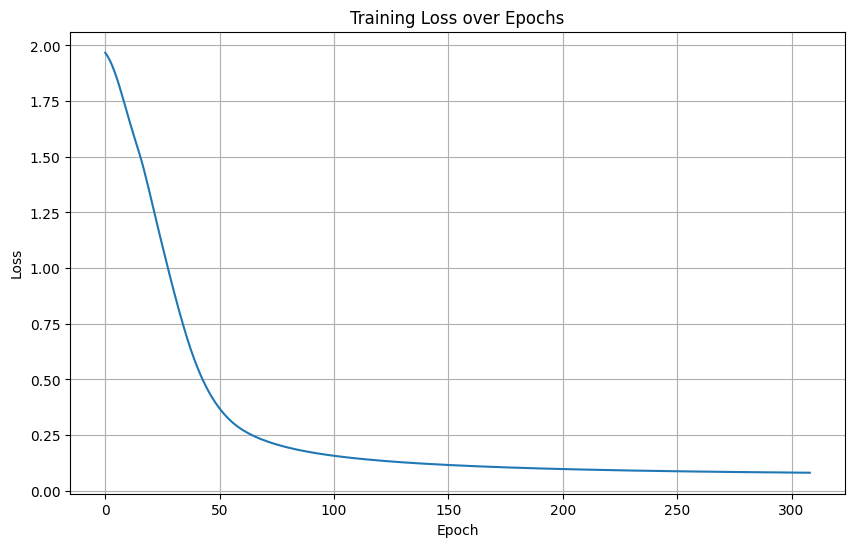

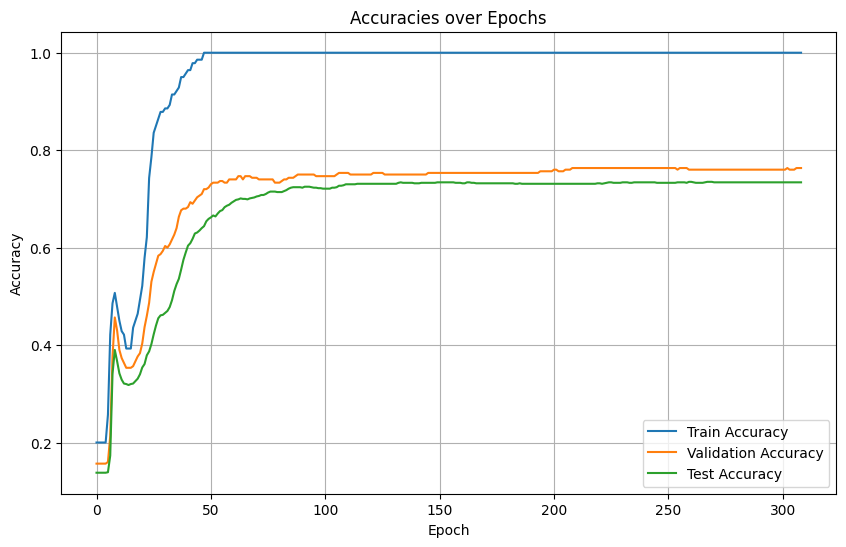

In [19]:


import matplotlib.pyplot as plt

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the accuracies
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracies over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [20]:
#correct classification on the test data

gcn.eval()
output = gcn(features, adj)
test_output = output[idx_test]
test_labels = labels[idx_test]

predicted_labels = test_output.max(1)[1].type_as(test_labels)

correctly_classified_indices = (predicted_labels == test_labels).nonzero(as_tuple=True)[0]
incorrectly_classified_indices = (predicted_labels != test_labels).nonzero(as_tuple=True)[0]

print("Examples of correct classifications on the test data:")
for i in correctly_classified_indices[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels[i].item()
    actual_class_index = test_labels[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


Examples of correct classifications on the test data:
Node Index (in original dataset): 500, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 501, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 502, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 503, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 504, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 505, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 507, Predicted Class: Genetic_Algorithms, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 508, Predicted Class: Genetic_Algorithms, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 510, Predicted Class: Theory, Actual Class: Theory
Node Index (in original dataset): 512, Predicted Class: Case_Based, Actua

In [21]:

print("\nExamples of incorrect classifications on the test data:")
for i in incorrectly_classified_indices[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels[i].item()
    actual_class_index = test_labels[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")




Examples of incorrect classifications on the test data:
Node Index (in original dataset): 506, Predicted Class: Genetic_Algorithms, Actual Class: Rule_Learning
Node Index (in original dataset): 509, Predicted Class: Genetic_Algorithms, Actual Class: Probabilistic_Methods
Node Index (in original dataset): 511, Predicted Class: Case_Based, Actual Class: Theory
Node Index (in original dataset): 518, Predicted Class: Case_Based, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 520, Predicted Class: Rule_Learning, Actual Class: Case_Based
Node Index (in original dataset): 521, Predicted Class: Genetic_Algorithms, Actual Class: Probabilistic_Methods
Node Index (in original dataset): 522, Predicted Class: Theory, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 523, Predicted Class: Genetic_Algorithms, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 524, Predicted Class: Genetic_Algorithms, Actual Class: Case_Based
Node Index (in ori

In [22]:
# classification results
correct_count = len(correctly_classified_indices)
incorrect_count = len(incorrectly_classified_indices)
total_test_samples = len(test_labels)

print(f"\nTotal test samples: {total_test_samples}")
print(f"Correctly classified: {correct_count}")
print(f"Incorrectly classified: {incorrect_count}")


Total test samples: 1000
Correctly classified: 734
Incorrectly classified: 266


To do: How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

#GraphSage

In [18]:


from torch_geometric.nn import SAGEConv

class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        return x


# Note: GraphSAGE in torch_geometric requires `edge_index` which is the COO format of the adjacency matrix.
# Our `adj` is already in sparse COO format. We need its indices.
edge_index = adj._indices()

# Define GraphSAGE model parameters
in_channels_gs = features.shape[1]
hidden_channels_gs = 50
out_channels_gs = labels.max().item() + 1
dropout_rate_gs = 0.5

graphsage = GraphSAGE(in_channels_gs, hidden_channels_gs, out_channels_gs, dropout_rate_gs)



In [ ]:
# Let's rewrite compute_accuracy to be compatible
def compute_accuracy_graphsage(model, features, edge_index, labels, indices):
    """
    Computes the accuracy of the model on the data specified by indices for GraphSAGE.
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation
        output = model(features, edge_index)
        sliced_output = output[indices]
        sliced_labels = labels[indices]
        preds = sliced_output.max(1)[1].type_as(sliced_labels)
        correct = preds.eq(sliced_labels).double()
        correct = correct.sum()
        acc = correct / len(sliced_labels)
    return acc

In [20]:
weight_decay_value_gs = 5e-4
opt_gs = optim.Adam(graphsage.parameters(), lr=0.01, weight_decay=weight_decay_value_gs)

losses_gs = []
train_accuracies_gs = []
val_accuracies_gs = []
test_accuracies_gs = []

# Add lists to store best validation accuracy and corresponding test accuracy for early stopping
best_val_acc_gs = 0
best_test_acc_gs = 0
epochs_no_improve_gs = 0
patience_gs = 100 # Number of epochs to wait for improvement before stopping

print("\n--- Training GraphSAGE ---")
for epoch in trange(1000):
    graphsage.train() # Set model to training mode
    opt_gs.zero_grad()
    output_gs = graphsage(features, edge_index)
    loss_gs = F.cross_entropy(output_gs[idx_train], labels[idx_train])

    loss_gs.backward()
    opt_gs.step()

    losses_gs.append(loss_gs.item())

    train_acc_gs = compute_accuracy_graphsage(graphsage, features, edge_index, labels, idx_train)
    val_acc_gs = compute_accuracy_graphsage(graphsage, features, edge_index, labels, idx_val)
    test_acc_gs = compute_accuracy_graphsage(graphsage, features, edge_index, labels, idx_test)

    train_accuracies_gs.append(train_acc_gs.item())
    val_accuracies_gs.append(val_acc_gs.item())
    test_accuracies_gs.append(test_acc_gs.item())

    # Check for early stopping
    if val_acc_gs > best_val_acc_gs:
        best_val_acc_gs = val_acc_gs
        best_test_acc_gs = test_acc_gs # Store the test accuracy when validation accuracy improves
        epochs_no_improve_gs = 0
    else:
        epochs_no_improve_gs += 1
        if epochs_no_improve_gs == patience_gs:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print loss and accuracies for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss_gs.item():.4f}, Train Acc: {train_acc_gs:.4f}, Val Acc: {val_acc_gs:.4f}, Test Acc: {test_acc_gs:.4f}")

# After the training loop, you can access the lists and the best test accuracy
print(f"\nBest Validation Accuracy (GraphSAGE): {best_val_acc_gs:.4f}")
print(f"Test Accuracy at Best Validation (GraphSAGE): {best_test_acc_gs:.4f}")




--- Training GraphSAGE ---


  0%|          | 1/1000 [00:00<06:15,  2.66it/s]

Epoch 1, Loss: 1.9687, Train Acc: 0.0571, Val Acc: 0.0667, Test Acc: 0.0570


  0%|          | 2/1000 [00:00<06:13,  2.67it/s]

Epoch 2, Loss: 1.9418, Train Acc: 0.4571, Val Acc: 0.3867, Test Acc: 0.3310


  0%|          | 3/1000 [00:01<06:11,  2.68it/s]

Epoch 3, Loss: 1.9081, Train Acc: 0.4071, Val Acc: 0.3700, Test Acc: 0.3290


  0%|          | 4/1000 [00:01<06:06,  2.72it/s]

Epoch 4, Loss: 1.8689, Train Acc: 0.4286, Val Acc: 0.3867, Test Acc: 0.3350


  0%|          | 5/1000 [00:01<06:05,  2.72it/s]

Epoch 5, Loss: 1.8273, Train Acc: 0.4286, Val Acc: 0.3867, Test Acc: 0.3350


  1%|          | 6/1000 [00:02<06:06,  2.71it/s]

Epoch 6, Loss: 1.7741, Train Acc: 0.4357, Val Acc: 0.3800, Test Acc: 0.3320


  1%|          | 7/1000 [00:02<06:05,  2.72it/s]

Epoch 7, Loss: 1.7146, Train Acc: 0.4286, Val Acc: 0.3700, Test Acc: 0.3320


  1%|          | 8/1000 [00:02<06:03,  2.73it/s]

Epoch 8, Loss: 1.6435, Train Acc: 0.4357, Val Acc: 0.3700, Test Acc: 0.3330


  1%|          | 9/1000 [00:03<06:06,  2.70it/s]

Epoch 9, Loss: 1.6171, Train Acc: 0.4357, Val Acc: 0.3700, Test Acc: 0.3320


  1%|          | 10/1000 [00:03<06:10,  2.67it/s]

Epoch 10, Loss: 1.5258, Train Acc: 0.4357, Val Acc: 0.3700, Test Acc: 0.3320


  1%|          | 11/1000 [00:04<06:34,  2.51it/s]

Epoch 11, Loss: 1.4933, Train Acc: 0.4429, Val Acc: 0.3700, Test Acc: 0.3340


  1%|          | 12/1000 [00:04<06:59,  2.35it/s]

Epoch 12, Loss: 1.4444, Train Acc: 0.4714, Val Acc: 0.3967, Test Acc: 0.3420


  1%|▏         | 13/1000 [00:05<07:19,  2.25it/s]

Epoch 13, Loss: 1.3949, Train Acc: 0.5214, Val Acc: 0.4167, Test Acc: 0.3540


  1%|▏         | 14/1000 [00:05<07:35,  2.17it/s]

Epoch 14, Loss: 1.3166, Train Acc: 0.5429, Val Acc: 0.4633, Test Acc: 0.3700


  2%|▏         | 15/1000 [00:06<07:41,  2.13it/s]

Epoch 15, Loss: 1.2473, Train Acc: 0.6500, Val Acc: 0.5033, Test Acc: 0.3920


  2%|▏         | 16/1000 [00:06<07:43,  2.12it/s]

Epoch 16, Loss: 1.1769, Train Acc: 0.7071, Val Acc: 0.5733, Test Acc: 0.4200


  2%|▏         | 17/1000 [00:06<07:11,  2.28it/s]

Epoch 17, Loss: 1.1099, Train Acc: 0.8286, Val Acc: 0.6267, Test Acc: 0.4630


  2%|▏         | 18/1000 [00:07<06:49,  2.40it/s]

Epoch 18, Loss: 1.0703, Train Acc: 0.8714, Val Acc: 0.6600, Test Acc: 0.5370


  2%|▏         | 19/1000 [00:07<06:34,  2.49it/s]

Epoch 19, Loss: 0.9664, Train Acc: 0.8929, Val Acc: 0.7067, Test Acc: 0.5810


  2%|▏         | 20/1000 [00:08<06:23,  2.56it/s]

Epoch 20, Loss: 0.9018, Train Acc: 0.9071, Val Acc: 0.7167, Test Acc: 0.6130


  2%|▏         | 21/1000 [00:08<06:16,  2.60it/s]

Epoch 21, Loss: 0.8611, Train Acc: 0.9214, Val Acc: 0.7267, Test Acc: 0.6350


  2%|▏         | 22/1000 [00:08<06:10,  2.64it/s]

Epoch 22, Loss: 0.7890, Train Acc: 0.9214, Val Acc: 0.7333, Test Acc: 0.6510


  2%|▏         | 23/1000 [00:09<06:06,  2.67it/s]

Epoch 23, Loss: 0.7590, Train Acc: 0.9286, Val Acc: 0.7367, Test Acc: 0.6620


  2%|▏         | 24/1000 [00:09<06:05,  2.67it/s]

Epoch 24, Loss: 0.6923, Train Acc: 0.9357, Val Acc: 0.7500, Test Acc: 0.6730


  2%|▎         | 25/1000 [00:09<06:01,  2.70it/s]

Epoch 25, Loss: 0.6410, Train Acc: 0.9357, Val Acc: 0.7567, Test Acc: 0.6830


  3%|▎         | 26/1000 [00:10<05:56,  2.73it/s]

Epoch 26, Loss: 0.5826, Train Acc: 0.9500, Val Acc: 0.7633, Test Acc: 0.6950


  3%|▎         | 27/1000 [00:10<05:57,  2.73it/s]

Epoch 27, Loss: 0.5375, Train Acc: 0.9500, Val Acc: 0.7667, Test Acc: 0.7000


  3%|▎         | 28/1000 [00:10<05:55,  2.73it/s]

Epoch 28, Loss: 0.4860, Train Acc: 0.9500, Val Acc: 0.7767, Test Acc: 0.7120


  3%|▎         | 29/1000 [00:11<05:53,  2.75it/s]

Epoch 29, Loss: 0.4905, Train Acc: 0.9500, Val Acc: 0.7733, Test Acc: 0.7270


  3%|▎         | 30/1000 [00:11<05:55,  2.73it/s]

Epoch 30, Loss: 0.4293, Train Acc: 0.9500, Val Acc: 0.7800, Test Acc: 0.7320


  3%|▎         | 31/1000 [00:12<05:55,  2.73it/s]

Epoch 31, Loss: 0.4006, Train Acc: 0.9643, Val Acc: 0.7867, Test Acc: 0.7420


  3%|▎         | 32/1000 [00:12<05:56,  2.72it/s]

Epoch 32, Loss: 0.4086, Train Acc: 0.9786, Val Acc: 0.7833, Test Acc: 0.7420


  3%|▎         | 33/1000 [00:12<05:56,  2.71it/s]

Epoch 33, Loss: 0.3462, Train Acc: 0.9786, Val Acc: 0.7900, Test Acc: 0.7470


  3%|▎         | 34/1000 [00:13<05:56,  2.71it/s]

Epoch 34, Loss: 0.3260, Train Acc: 0.9786, Val Acc: 0.7900, Test Acc: 0.7540


  4%|▎         | 35/1000 [00:13<05:58,  2.69it/s]

Epoch 35, Loss: 0.3002, Train Acc: 0.9929, Val Acc: 0.7967, Test Acc: 0.7590


  4%|▎         | 36/1000 [00:13<05:54,  2.72it/s]

Epoch 36, Loss: 0.2716, Train Acc: 0.9929, Val Acc: 0.7933, Test Acc: 0.7600


  4%|▎         | 37/1000 [00:14<05:51,  2.74it/s]

Epoch 37, Loss: 0.2997, Train Acc: 0.9929, Val Acc: 0.7967, Test Acc: 0.7630


  4%|▍         | 38/1000 [00:14<05:53,  2.72it/s]

Epoch 38, Loss: 0.2849, Train Acc: 1.0000, Val Acc: 0.8033, Test Acc: 0.7650


  4%|▍         | 39/1000 [00:15<05:51,  2.74it/s]

Epoch 39, Loss: 0.2115, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7660


  4%|▍         | 40/1000 [00:15<05:47,  2.76it/s]

Epoch 40, Loss: 0.2347, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7700


  4%|▍         | 41/1000 [00:15<05:51,  2.73it/s]

Epoch 41, Loss: 0.2160, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7710


  4%|▍         | 42/1000 [00:16<05:50,  2.74it/s]

Epoch 42, Loss: 0.2250, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7710


  4%|▍         | 43/1000 [00:16<05:47,  2.75it/s]

Epoch 43, Loss: 0.2237, Train Acc: 1.0000, Val Acc: 0.8033, Test Acc: 0.7740


  4%|▍         | 44/1000 [00:16<06:23,  2.49it/s]

Epoch 44, Loss: 0.1979, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7740


  4%|▍         | 45/1000 [00:17<06:45,  2.36it/s]

Epoch 45, Loss: 0.1805, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7870


  5%|▍         | 46/1000 [00:17<07:14,  2.19it/s]

Epoch 46, Loss: 0.2027, Train Acc: 1.0000, Val Acc: 0.8167, Test Acc: 0.7920


  5%|▍         | 47/1000 [00:18<07:20,  2.16it/s]

Epoch 47, Loss: 0.1971, Train Acc: 1.0000, Val Acc: 0.8200, Test Acc: 0.7940


  5%|▍         | 48/1000 [00:18<07:33,  2.10it/s]

Epoch 48, Loss: 0.1731, Train Acc: 1.0000, Val Acc: 0.8133, Test Acc: 0.7980


  5%|▍         | 49/1000 [00:19<07:25,  2.14it/s]

Epoch 49, Loss: 0.1659, Train Acc: 1.0000, Val Acc: 0.8167, Test Acc: 0.8000


  5%|▌         | 50/1000 [00:19<07:00,  2.26it/s]

Epoch 50, Loss: 0.1747, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7970


  5%|▌         | 51/1000 [00:20<06:41,  2.37it/s]

Epoch 51, Loss: 0.1740, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7870


  5%|▌         | 52/1000 [00:20<06:22,  2.48it/s]

Epoch 52, Loss: 0.1710, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7850


  5%|▌         | 53/1000 [00:20<06:15,  2.52it/s]

Epoch 53, Loss: 0.1727, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7820


  5%|▌         | 54/1000 [00:21<06:04,  2.59it/s]

Epoch 54, Loss: 0.1707, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7810


  6%|▌         | 55/1000 [00:21<05:57,  2.64it/s]

Epoch 55, Loss: 0.1472, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7770


  6%|▌         | 56/1000 [00:22<05:55,  2.66it/s]

Epoch 56, Loss: 0.1495, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7790


  6%|▌         | 57/1000 [00:22<05:54,  2.66it/s]

Epoch 57, Loss: 0.1437, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7830


  6%|▌         | 58/1000 [00:22<05:50,  2.69it/s]

Epoch 58, Loss: 0.1665, Train Acc: 1.0000, Val Acc: 0.8033, Test Acc: 0.7860


  6%|▌         | 59/1000 [00:23<05:51,  2.68it/s]

Epoch 59, Loss: 0.1476, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7920


  6%|▌         | 60/1000 [00:23<05:47,  2.71it/s]

Epoch 60, Loss: 0.1718, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7910


  6%|▌         | 61/1000 [00:23<05:46,  2.71it/s]

Epoch 61, Loss: 0.1462, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7920


  6%|▌         | 62/1000 [00:24<05:45,  2.71it/s]

Epoch 62, Loss: 0.1371, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7910


  6%|▋         | 63/1000 [00:24<05:43,  2.72it/s]

Epoch 63, Loss: 0.1407, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7890


  6%|▋         | 64/1000 [00:24<05:42,  2.73it/s]

Epoch 64, Loss: 0.1538, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7890


  6%|▋         | 65/1000 [00:25<05:48,  2.68it/s]

Epoch 65, Loss: 0.1674, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7920


  7%|▋         | 66/1000 [00:25<05:46,  2.69it/s]

Epoch 66, Loss: 0.1408, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7930


  7%|▋         | 67/1000 [00:26<05:44,  2.71it/s]

Epoch 67, Loss: 0.1534, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7900


  7%|▋         | 68/1000 [00:26<05:45,  2.69it/s]

Epoch 68, Loss: 0.1190, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7910


  7%|▋         | 69/1000 [00:26<05:44,  2.70it/s]

Epoch 69, Loss: 0.1418, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.7920


  7%|▋         | 70/1000 [00:27<05:44,  2.70it/s]

Epoch 70, Loss: 0.1418, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7920


  7%|▋         | 71/1000 [00:27<05:41,  2.72it/s]

Epoch 71, Loss: 0.1198, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7870


  7%|▋         | 72/1000 [00:27<05:40,  2.73it/s]

Epoch 72, Loss: 0.1441, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7890


  7%|▋         | 73/1000 [00:28<05:41,  2.71it/s]

Epoch 73, Loss: 0.1259, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7900


  7%|▋         | 74/1000 [00:28<05:39,  2.72it/s]

Epoch 74, Loss: 0.1262, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7920


  8%|▊         | 75/1000 [00:29<05:38,  2.73it/s]

Epoch 75, Loss: 0.1128, Train Acc: 1.0000, Val Acc: 0.8167, Test Acc: 0.7890


  8%|▊         | 76/1000 [00:29<05:49,  2.64it/s]

Epoch 76, Loss: 0.1322, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7920


  8%|▊         | 77/1000 [00:29<06:22,  2.42it/s]

Epoch 77, Loss: 0.1354, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7940


  8%|▊         | 78/1000 [00:30<06:40,  2.30it/s]

Epoch 78, Loss: 0.1194, Train Acc: 1.0000, Val Acc: 0.8133, Test Acc: 0.7950


  8%|▊         | 79/1000 [00:30<06:53,  2.23it/s]

Epoch 79, Loss: 0.1302, Train Acc: 1.0000, Val Acc: 0.8133, Test Acc: 0.7930


  8%|▊         | 80/1000 [00:31<07:05,  2.16it/s]

Epoch 80, Loss: 0.1258, Train Acc: 1.0000, Val Acc: 0.8133, Test Acc: 0.7960


  8%|▊         | 81/1000 [00:31<07:16,  2.10it/s]

Epoch 81, Loss: 0.1096, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7940


  8%|▊         | 82/1000 [00:32<06:51,  2.23it/s]

Epoch 82, Loss: 0.1119, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7970


  8%|▊         | 83/1000 [00:32<06:30,  2.35it/s]

Epoch 83, Loss: 0.1261, Train Acc: 1.0000, Val Acc: 0.8033, Test Acc: 0.7890


  8%|▊         | 84/1000 [00:32<06:14,  2.45it/s]

Epoch 84, Loss: 0.1216, Train Acc: 1.0000, Val Acc: 0.8033, Test Acc: 0.7860


  8%|▊         | 85/1000 [00:33<06:01,  2.53it/s]

Epoch 85, Loss: 0.1084, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7870


  9%|▊         | 86/1000 [00:33<05:57,  2.56it/s]

Epoch 86, Loss: 0.1119, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7880


  9%|▊         | 87/1000 [00:34<05:49,  2.61it/s]

Epoch 87, Loss: 0.1261, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.7900


  9%|▉         | 88/1000 [00:34<05:43,  2.66it/s]

Epoch 88, Loss: 0.1181, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.7910


  9%|▉         | 89/1000 [00:34<05:42,  2.66it/s]

Epoch 89, Loss: 0.1122, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7930


  9%|▉         | 90/1000 [00:35<05:37,  2.70it/s]

Epoch 90, Loss: 0.0939, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7930


  9%|▉         | 91/1000 [00:35<05:42,  2.66it/s]

Epoch 91, Loss: 0.1090, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7950


  9%|▉         | 92/1000 [00:35<05:41,  2.66it/s]

Epoch 92, Loss: 0.1055, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7890


  9%|▉         | 93/1000 [00:36<05:36,  2.69it/s]

Epoch 93, Loss: 0.1151, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7930


  9%|▉         | 94/1000 [00:36<05:36,  2.69it/s]

Epoch 94, Loss: 0.1073, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7910


 10%|▉         | 95/1000 [00:37<05:33,  2.71it/s]

Epoch 95, Loss: 0.1029, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7890


 10%|▉         | 96/1000 [00:37<05:32,  2.72it/s]

Epoch 96, Loss: 0.1073, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7900


 10%|▉         | 97/1000 [00:37<05:35,  2.69it/s]

Epoch 97, Loss: 0.1104, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7910


 10%|▉         | 98/1000 [00:38<05:32,  2.71it/s]

Epoch 98, Loss: 0.0973, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7930


 10%|▉         | 99/1000 [00:38<05:31,  2.72it/s]

Epoch 99, Loss: 0.1189, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7950


 10%|█         | 100/1000 [00:38<05:32,  2.71it/s]

Epoch 100, Loss: 0.1026, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7930


 10%|█         | 101/1000 [00:39<05:30,  2.72it/s]

Epoch 101, Loss: 0.1016, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7920


 10%|█         | 102/1000 [00:39<05:27,  2.74it/s]

Epoch 102, Loss: 0.1057, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7920


 10%|█         | 103/1000 [00:40<05:31,  2.71it/s]

Epoch 103, Loss: 0.1030, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7960


 10%|█         | 104/1000 [00:40<05:27,  2.73it/s]

Epoch 104, Loss: 0.0922, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7950


 10%|█         | 105/1000 [00:40<05:29,  2.72it/s]

Epoch 105, Loss: 0.1015, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7930


 11%|█         | 106/1000 [00:41<05:28,  2.72it/s]

Epoch 106, Loss: 0.1019, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7910


 11%|█         | 107/1000 [00:41<05:26,  2.74it/s]

Epoch 107, Loss: 0.1033, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7900


 11%|█         | 108/1000 [00:41<05:32,  2.68it/s]

Epoch 108, Loss: 0.0912, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7920


 11%|█         | 109/1000 [00:42<05:55,  2.50it/s]

Epoch 109, Loss: 0.0948, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7910


 11%|█         | 110/1000 [00:42<06:21,  2.33it/s]

Epoch 110, Loss: 0.1025, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7890


 11%|█         | 111/1000 [00:43<06:37,  2.24it/s]

Epoch 111, Loss: 0.0865, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7920


 11%|█         | 112/1000 [00:43<06:47,  2.18it/s]

Epoch 112, Loss: 0.1042, Train Acc: 1.0000, Val Acc: 0.8133, Test Acc: 0.7940


 11%|█▏        | 113/1000 [00:44<06:58,  2.12it/s]

Epoch 113, Loss: 0.0970, Train Acc: 1.0000, Val Acc: 0.8133, Test Acc: 0.7920


 11%|█▏        | 114/1000 [00:44<06:57,  2.12it/s]

Epoch 114, Loss: 0.0896, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7930


 12%|█▏        | 115/1000 [00:45<06:31,  2.26it/s]

Epoch 115, Loss: 0.0930, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7990


 12%|█▏        | 116/1000 [00:45<06:08,  2.40it/s]

Epoch 116, Loss: 0.1032, Train Acc: 1.0000, Val Acc: 0.8033, Test Acc: 0.7940


 12%|█▏        | 117/1000 [00:45<05:54,  2.49it/s]

Epoch 117, Loss: 0.0893, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.8010


 12%|█▏        | 118/1000 [00:46<05:46,  2.54it/s]

Epoch 118, Loss: 0.0782, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7970


 12%|█▏        | 119/1000 [00:46<05:37,  2.61it/s]

Epoch 119, Loss: 0.0936, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7990


 12%|█▏        | 120/1000 [00:46<05:31,  2.66it/s]

Epoch 120, Loss: 0.0969, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.7960


 12%|█▏        | 121/1000 [00:47<05:29,  2.67it/s]

Epoch 121, Loss: 0.0987, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.7950


 12%|█▏        | 122/1000 [00:47<05:25,  2.70it/s]

Epoch 122, Loss: 0.1103, Train Acc: 1.0000, Val Acc: 0.7867, Test Acc: 0.7930


 12%|█▏        | 123/1000 [00:48<05:31,  2.65it/s]

Epoch 123, Loss: 0.0823, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7860


 12%|█▏        | 124/1000 [00:48<05:28,  2.66it/s]

Epoch 124, Loss: 0.0854, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7870


 12%|█▎        | 125/1000 [00:48<05:26,  2.68it/s]

Epoch 125, Loss: 0.0901, Train Acc: 1.0000, Val Acc: 0.8033, Test Acc: 0.7890


 13%|█▎        | 126/1000 [00:49<05:24,  2.69it/s]

Epoch 126, Loss: 0.0776, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7900


 13%|█▎        | 127/1000 [00:49<05:23,  2.70it/s]

Epoch 127, Loss: 0.0877, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7890


 13%|█▎        | 128/1000 [00:49<05:22,  2.71it/s]

Epoch 128, Loss: 0.0940, Train Acc: 1.0000, Val Acc: 0.8100, Test Acc: 0.7900


 13%|█▎        | 129/1000 [00:50<05:23,  2.69it/s]

Epoch 129, Loss: 0.0922, Train Acc: 1.0000, Val Acc: 0.8067, Test Acc: 0.7880


 13%|█▎        | 130/1000 [00:50<05:21,  2.71it/s]

Epoch 130, Loss: 0.0806, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7920


 13%|█▎        | 131/1000 [00:51<05:21,  2.71it/s]

Epoch 131, Loss: 0.0835, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7960


 13%|█▎        | 132/1000 [00:51<05:21,  2.70it/s]

Epoch 132, Loss: 0.0761, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7980


 13%|█▎        | 133/1000 [00:51<05:19,  2.72it/s]

Epoch 133, Loss: 0.0872, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.8020


 13%|█▎        | 134/1000 [00:52<05:18,  2.72it/s]

Epoch 134, Loss: 0.0905, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.8070


 14%|█▎        | 135/1000 [00:52<05:18,  2.71it/s]

Epoch 135, Loss: 0.0809, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.8080


 14%|█▎        | 136/1000 [00:52<05:16,  2.73it/s]

Epoch 136, Loss: 0.0959, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.8050


 14%|█▎        | 137/1000 [00:53<05:20,  2.70it/s]

Epoch 137, Loss: 0.0819, Train Acc: 1.0000, Val Acc: 0.7900, Test Acc: 0.8040


 14%|█▍        | 138/1000 [00:53<05:22,  2.67it/s]

Epoch 138, Loss: 0.0727, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.8000


 14%|█▍        | 139/1000 [00:53<05:20,  2.68it/s]

Epoch 139, Loss: 0.0793, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7930


 14%|█▍        | 140/1000 [00:54<05:19,  2.69it/s]

Epoch 140, Loss: 0.0921, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7900


 14%|█▍        | 141/1000 [00:54<05:18,  2.70it/s]

Epoch 141, Loss: 0.0994, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7880


 14%|█▍        | 142/1000 [00:55<05:47,  2.47it/s]

Epoch 142, Loss: 0.0921, Train Acc: 1.0000, Val Acc: 0.7933, Test Acc: 0.7910


 14%|█▍        | 143/1000 [00:55<06:06,  2.34it/s]

Epoch 143, Loss: 0.0753, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.7920


 14%|█▍        | 144/1000 [00:56<06:20,  2.25it/s]

Epoch 144, Loss: 0.0725, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7920


 14%|█▍        | 145/1000 [00:56<06:34,  2.17it/s]

Epoch 145, Loss: 0.0820, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.7930


 15%|█▍        | 146/1000 [00:57<06:46,  2.10it/s]

Epoch 146, Loss: 0.0819, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.8000


 15%|█▍        | 146/1000 [00:57<05:37,  2.53it/s]

Early stopping at epoch 147

Best Validation Accuracy (GraphSAGE): 0.8200
Test Accuracy at Best Validation (GraphSAGE): 0.7940


In [23]:


graphsage.eval()
output_gs = graphsage(features, edge_index)
test_output_gs = output_gs[idx_test]
test_labels_gs = labels[idx_test] # Assuming test_labels is the same as for GCN

predicted_labels_gs = test_output_gs.max(1)[1].type_as(test_labels_gs)

correctly_classified_indices_gs = (predicted_labels_gs == test_labels_gs).nonzero(as_tuple=True)[0]
incorrectly_classified_indices_gs = (predicted_labels_gs != test_labels_gs).nonzero(as_tuple=True)[0]

print("Examples of correct classifications on the test data (GraphSAGE):")
for i in correctly_classified_indices_gs[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels_gs[i].item()
    actual_class_index = test_labels_gs[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


print("\nExamples of incorrect classifications on the test data (GraphSAGE):")
for i in incorrectly_classified_indices_gs[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels_gs[i].item()
    actual_class_index = test_labels_gs[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


# Visualization of classification results (GraphSAGE)
correct_count_gs = len(correctly_classified_indices_gs)
incorrect_count_gs = len(incorrectly_classified_indices_gs)
total_test_samples_gs = len(test_labels_gs)

print(f"\nTotal test samples (GraphSAGE): {total_test_samples_gs}")
print(f"Correctly classified (GraphSAGE): {correct_count_gs}")
print(f"Incorrectly classified (GraphSAGE): {incorrect_count_gs}")

Examples of correct classifications on the test data (GraphSAGE):
Node Index (in original dataset): 500, Predicted Class: Probabilistic_Methods, Actual Class: Probabilistic_Methods
Node Index (in original dataset): 501, Predicted Class: Theory, Actual Class: Theory
Node Index (in original dataset): 502, Predicted Class: Probabilistic_Methods, Actual Class: Probabilistic_Methods
Node Index (in original dataset): 503, Predicted Class: Theory, Actual Class: Theory
Node Index (in original dataset): 504, Predicted Class: Theory, Actual Class: Theory
Node Index (in original dataset): 505, Predicted Class: Theory, Actual Class: Theory
Node Index (in original dataset): 507, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 508, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 512, Predicted Class: Theory, Actual Class: Theory
Node Index (in original dataset): 513, Predicted Class: Genetic_Algorithms, Actual Class: Gen

#GAT

In [23]:
!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=3ce65cc575d3a5cee3e81e78f34f3f07a2e26564a36d9b6ee81852393c9d7793
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli

In [23]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads, dropout):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=heads, dropout=dropout)
        # Apply multi-head attention in the first layer, then average the results.
        # The output dimension of self.conv1 will be hidden_channels * heads.
        # The second layer will take this as input.
        self.conv2 = GATConv(hidden_channels * heads, out_channels, heads=1, dropout=dropout)
        # The second layer can use a single head for final classification

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index)) # Use ELU activation
        x = self.conv2(x, edge_index)
        return x


In [24]:
# Define GAT model parameters
in_channels_gat = features.shape[1]
hidden_channels_gat = 8 # Common to use 8 hidden units per head in the first layer
out_channels_gat = labels.max().item() + 1
heads_gat = 8 # Number of attention heads in the first layer
dropout_rate_gat = 0.6 # Dropout rate


gat = GAT(in_channels_gat, hidden_channels_gat, out_channels_gat, heads_gat, dropout_rate_gat)

In [25]:
def compute_accuracy_gat(model, features, edge_index, labels, indices):
    """
    Computes the accuracy of the model on the data specified by indices for GAT.
    """
    model.eval() # Set the model to evaluation mode
    with torch.no_grad(): # Disable gradient computation
        output = model(features, edge_index)
        sliced_output = output[indices]
        sliced_labels = labels[indices]
        preds = sliced_output.max(1)[1].type_as(sliced_labels)
        correct = preds.eq(sliced_labels).double()
        correct = correct.sum()
        acc = correct / len(sliced_labels)
    return acc

In [26]:
weight_decay_value_gat = 5e-4 # Common weight decay value
opt_gat = optim.Adam(gat.parameters(), lr=0.005, weight_decay=weight_decay_value_gat) # Use a smaller learning rate
edge_index = adj._indices()

losses_gat = []
train_accuracies_gat = []
val_accuracies_gat = []
test_accuracies_gat = []

best_val_acc_gat = 0
best_test_acc_gat = 0
epochs_no_improve_gat = 0
patience_gat = 100 # Number of epochs to wait for improvement before stopping

print("\n--- Training GAT ---")
for epoch in trange(1000):
    gat.train() # Set model to training mode
    opt_gat.zero_grad()
    output_gat = gat(features, edge_index)
    loss_gat = F.cross_entropy(output_gat[idx_train], labels[idx_train])

    loss_gat.backward()
    opt_gat.step()

    losses_gat.append(loss_gat.item())

    train_acc_gat = compute_accuracy_gat(gat, features, edge_index, labels, idx_train)
    val_acc_gat = compute_accuracy_gat(gat, features, edge_index, labels, idx_val)
    test_acc_gat = compute_accuracy_gat(gat, features, edge_index, labels, idx_test)

    train_accuracies_gat.append(train_acc_gat.item())
    val_accuracies_gat.append(val_acc_gat.item())
    test_accuracies_gat.append(test_acc_gat.item())

    # Check for early stopping
    if val_acc_gat > best_val_acc_gat:
        best_val_acc_gat = val_acc_gat
        best_test_acc_gat = test_acc_gat # Store the test accuracy when validation accuracy improves
        epochs_no_improve_gat = 0
    else:
        epochs_no_improve_gat += 1
        if epochs_no_improve_gat == patience_gat:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print loss and accuracies for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss_gat.item():.4f}, Train Acc: {train_acc_gat:.4f}, Val Acc: {val_acc_gat:.4f}, Test Acc: {test_acc_gat:.4f}")

# After the training loop, you can access the lists and the best test accuracy
print(f"\nBest Validation Accuracy (GAT): {best_val_acc_gat:.4f}")
print(f"Test Accuracy at Best Validation (GAT): {best_test_acc_gat:.4f}")


--- Training GAT ---


  0%|          | 1/1000 [00:00<02:23,  6.95it/s]

Epoch 1, Loss: 1.9459, Train Acc: 0.3071, Val Acc: 0.3533, Test Acc: 0.3170


  0%|          | 2/1000 [00:00<02:11,  7.59it/s]

Epoch 2, Loss: 1.9216, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 3/1000 [00:00<02:02,  8.13it/s]

Epoch 3, Loss: 1.8955, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 4/1000 [00:00<02:00,  8.29it/s]

Epoch 4, Loss: 1.8767, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 5/1000 [00:00<01:59,  8.31it/s]

Epoch 5, Loss: 1.8534, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 6/1000 [00:00<01:56,  8.50it/s]

Epoch 6, Loss: 1.8171, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 7/1000 [00:00<01:54,  8.68it/s]

Epoch 7, Loss: 1.8051, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 8/1000 [00:00<01:52,  8.79it/s]

Epoch 8, Loss: 1.7882, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 9/1000 [00:01<01:51,  8.89it/s]

Epoch 9, Loss: 1.7627, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 10/1000 [00:01<01:54,  8.61it/s]

Epoch 10, Loss: 1.7410, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 11/1000 [00:01<01:53,  8.75it/s]

Epoch 11, Loss: 1.7136, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 12/1000 [00:01<01:51,  8.86it/s]

Epoch 12, Loss: 1.6981, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|▏         | 13/1000 [00:01<01:51,  8.82it/s]

Epoch 13, Loss: 1.7035, Train Acc: 0.3000, Val Acc: 0.3500, Test Acc: 0.3110


  1%|▏         | 14/1000 [00:01<01:51,  8.87it/s]

Epoch 14, Loss: 1.7200, Train Acc: 0.3429, Val Acc: 0.3633, Test Acc: 0.3170


  2%|▏         | 15/1000 [00:01<01:50,  8.93it/s]

Epoch 15, Loss: 1.6620, Train Acc: 0.3929, Val Acc: 0.3633, Test Acc: 0.3230


  2%|▏         | 16/1000 [00:01<01:49,  8.98it/s]

Epoch 16, Loss: 1.6962, Train Acc: 0.4071, Val Acc: 0.3700, Test Acc: 0.3290


  2%|▏         | 17/1000 [00:01<01:48,  9.03it/s]

Epoch 17, Loss: 1.6461, Train Acc: 0.4357, Val Acc: 0.3933, Test Acc: 0.3430


  2%|▏         | 18/1000 [00:02<01:48,  9.02it/s]

Epoch 18, Loss: 1.5842, Train Acc: 0.4643, Val Acc: 0.4067, Test Acc: 0.3570


  2%|▏         | 19/1000 [00:02<01:52,  8.70it/s]

Epoch 19, Loss: 1.6189, Train Acc: 0.4857, Val Acc: 0.4533, Test Acc: 0.3660


  2%|▏         | 20/1000 [00:02<01:51,  8.80it/s]

Epoch 20, Loss: 1.6382, Train Acc: 0.5071, Val Acc: 0.4867, Test Acc: 0.3850


  2%|▏         | 21/1000 [00:02<01:50,  8.89it/s]

Epoch 21, Loss: 1.6327, Train Acc: 0.5429, Val Acc: 0.5267, Test Acc: 0.4010


  2%|▏         | 22/1000 [00:02<01:50,  8.87it/s]

Epoch 22, Loss: 1.5853, Train Acc: 0.5786, Val Acc: 0.5467, Test Acc: 0.4170


  2%|▏         | 23/1000 [00:02<01:50,  8.86it/s]

Epoch 23, Loss: 1.5290, Train Acc: 0.6071, Val Acc: 0.5700, Test Acc: 0.4290


  2%|▏         | 24/1000 [00:02<01:50,  8.86it/s]

Epoch 24, Loss: 1.5732, Train Acc: 0.6071, Val Acc: 0.5833, Test Acc: 0.4410


  2%|▎         | 25/1000 [00:02<01:49,  8.92it/s]

Epoch 25, Loss: 1.5230, Train Acc: 0.6214, Val Acc: 0.5867, Test Acc: 0.4440


  3%|▎         | 26/1000 [00:02<01:48,  8.99it/s]

Epoch 26, Loss: 1.5016, Train Acc: 0.6357, Val Acc: 0.5933, Test Acc: 0.4420


  3%|▎         | 27/1000 [00:03<01:47,  9.08it/s]

Epoch 27, Loss: 1.5171, Train Acc: 0.6500, Val Acc: 0.5900, Test Acc: 0.4450


  3%|▎         | 28/1000 [00:03<01:47,  9.08it/s]

Epoch 28, Loss: 1.5143, Train Acc: 0.6500, Val Acc: 0.5967, Test Acc: 0.4470


  3%|▎         | 29/1000 [00:03<01:50,  8.80it/s]

Epoch 29, Loss: 1.4780, Train Acc: 0.6500, Val Acc: 0.5933, Test Acc: 0.4440


  3%|▎         | 30/1000 [00:03<01:50,  8.80it/s]

Epoch 30, Loss: 1.4389, Train Acc: 0.6500, Val Acc: 0.5800, Test Acc: 0.4420


  3%|▎         | 31/1000 [00:03<01:49,  8.86it/s]

Epoch 31, Loss: 1.3953, Train Acc: 0.6643, Val Acc: 0.5767, Test Acc: 0.4430


  3%|▎         | 32/1000 [00:03<01:48,  8.90it/s]

Epoch 32, Loss: 1.3798, Train Acc: 0.6714, Val Acc: 0.5800, Test Acc: 0.4400


  3%|▎         | 33/1000 [00:03<01:48,  8.89it/s]

Epoch 33, Loss: 1.3573, Train Acc: 0.6714, Val Acc: 0.5700, Test Acc: 0.4410


  3%|▎         | 34/1000 [00:03<01:47,  8.97it/s]

Epoch 34, Loss: 1.3818, Train Acc: 0.6857, Val Acc: 0.5800, Test Acc: 0.4420


  4%|▎         | 35/1000 [00:03<01:47,  9.01it/s]

Epoch 35, Loss: 1.3602, Train Acc: 0.7000, Val Acc: 0.5933, Test Acc: 0.4580


  4%|▎         | 36/1000 [00:04<01:52,  8.56it/s]

Epoch 36, Loss: 1.3918, Train Acc: 0.7286, Val Acc: 0.6033, Test Acc: 0.4740


  4%|▎         | 37/1000 [00:04<02:13,  7.20it/s]

Epoch 37, Loss: 1.3053, Train Acc: 0.7357, Val Acc: 0.6233, Test Acc: 0.4790


  4%|▍         | 38/1000 [00:04<02:23,  6.69it/s]

Epoch 38, Loss: 1.3241, Train Acc: 0.7643, Val Acc: 0.6467, Test Acc: 0.4930


  4%|▍         | 39/1000 [00:04<02:30,  6.38it/s]

Epoch 39, Loss: 1.2943, Train Acc: 0.7643, Val Acc: 0.6467, Test Acc: 0.5110


  4%|▍         | 40/1000 [00:04<02:34,  6.20it/s]

Epoch 40, Loss: 1.1947, Train Acc: 0.7857, Val Acc: 0.6600, Test Acc: 0.5340


  4%|▍         | 41/1000 [00:05<02:43,  5.87it/s]

Epoch 41, Loss: 1.2580, Train Acc: 0.7929, Val Acc: 0.6833, Test Acc: 0.5550


  4%|▍         | 42/1000 [00:05<02:43,  5.86it/s]

Epoch 42, Loss: 1.2689, Train Acc: 0.8214, Val Acc: 0.6900, Test Acc: 0.5770


  4%|▍         | 43/1000 [00:05<02:44,  5.80it/s]

Epoch 43, Loss: 1.2479, Train Acc: 0.8286, Val Acc: 0.7000, Test Acc: 0.5980


  4%|▍         | 44/1000 [00:05<02:45,  5.76it/s]

Epoch 44, Loss: 1.1804, Train Acc: 0.8357, Val Acc: 0.7100, Test Acc: 0.6110


  4%|▍         | 45/1000 [00:05<02:45,  5.76it/s]

Epoch 45, Loss: 1.1399, Train Acc: 0.8429, Val Acc: 0.7200, Test Acc: 0.6230


  5%|▍         | 46/1000 [00:05<02:46,  5.75it/s]

Epoch 46, Loss: 1.1899, Train Acc: 0.8500, Val Acc: 0.7300, Test Acc: 0.6440


  5%|▍         | 47/1000 [00:06<02:47,  5.69it/s]

Epoch 47, Loss: 1.2150, Train Acc: 0.8500, Val Acc: 0.7233, Test Acc: 0.6510


  5%|▍         | 48/1000 [00:06<02:46,  5.72it/s]

Epoch 48, Loss: 1.1949, Train Acc: 0.8500, Val Acc: 0.7267, Test Acc: 0.6570


  5%|▍         | 49/1000 [00:06<02:47,  5.67it/s]

Epoch 49, Loss: 1.1059, Train Acc: 0.8500, Val Acc: 0.7300, Test Acc: 0.6610


  5%|▌         | 50/1000 [00:06<02:52,  5.50it/s]

Epoch 50, Loss: 1.1597, Train Acc: 0.8500, Val Acc: 0.7333, Test Acc: 0.6630


  5%|▌         | 51/1000 [00:06<02:49,  5.59it/s]

Epoch 51, Loss: 1.0898, Train Acc: 0.8500, Val Acc: 0.7400, Test Acc: 0.6670


  5%|▌         | 52/1000 [00:06<02:43,  5.80it/s]

Epoch 52, Loss: 1.1483, Train Acc: 0.8500, Val Acc: 0.7400, Test Acc: 0.6660


  5%|▌         | 53/1000 [00:07<02:26,  6.46it/s]

Epoch 53, Loss: 1.0326, Train Acc: 0.8500, Val Acc: 0.7400, Test Acc: 0.6670


  5%|▌         | 54/1000 [00:07<02:14,  7.03it/s]

Epoch 54, Loss: 1.0641, Train Acc: 0.8571, Val Acc: 0.7400, Test Acc: 0.6710


  6%|▌         | 55/1000 [00:07<02:05,  7.56it/s]

Epoch 55, Loss: 1.0971, Train Acc: 0.8643, Val Acc: 0.7467, Test Acc: 0.6750


  6%|▌         | 56/1000 [00:07<01:58,  7.95it/s]

Epoch 56, Loss: 1.0765, Train Acc: 0.8643, Val Acc: 0.7467, Test Acc: 0.6780


  6%|▌         | 57/1000 [00:07<01:55,  8.17it/s]

Epoch 57, Loss: 1.0315, Train Acc: 0.8786, Val Acc: 0.7667, Test Acc: 0.6800


  6%|▌         | 58/1000 [00:07<01:56,  8.07it/s]

Epoch 58, Loss: 0.9897, Train Acc: 0.8929, Val Acc: 0.7700, Test Acc: 0.6950


  6%|▌         | 59/1000 [00:07<01:52,  8.39it/s]

Epoch 59, Loss: 1.0240, Train Acc: 0.8929, Val Acc: 0.7800, Test Acc: 0.7050


  6%|▌         | 60/1000 [00:07<01:49,  8.59it/s]

Epoch 60, Loss: 0.9977, Train Acc: 0.9071, Val Acc: 0.7867, Test Acc: 0.7230


  6%|▌         | 61/1000 [00:07<01:47,  8.71it/s]

Epoch 61, Loss: 0.9617, Train Acc: 0.9214, Val Acc: 0.7933, Test Acc: 0.7320


  6%|▌         | 62/1000 [00:08<01:46,  8.85it/s]

Epoch 62, Loss: 0.9385, Train Acc: 0.9214, Val Acc: 0.8000, Test Acc: 0.7400


  6%|▋         | 63/1000 [00:08<01:44,  8.95it/s]

Epoch 63, Loss: 0.9889, Train Acc: 0.9214, Val Acc: 0.8067, Test Acc: 0.7450


  6%|▋         | 64/1000 [00:08<01:44,  8.92it/s]

Epoch 64, Loss: 0.9895, Train Acc: 0.9214, Val Acc: 0.8100, Test Acc: 0.7510


  6%|▋         | 65/1000 [00:08<01:45,  8.90it/s]

Epoch 65, Loss: 0.8823, Train Acc: 0.9214, Val Acc: 0.8067, Test Acc: 0.7600


  7%|▋         | 66/1000 [00:08<01:45,  8.88it/s]

Epoch 66, Loss: 0.9471, Train Acc: 0.9286, Val Acc: 0.8067, Test Acc: 0.7620


  7%|▋         | 67/1000 [00:08<01:49,  8.51it/s]

Epoch 67, Loss: 0.9655, Train Acc: 0.9286, Val Acc: 0.8033, Test Acc: 0.7710


  7%|▋         | 68/1000 [00:08<01:47,  8.69it/s]

Epoch 68, Loss: 0.9147, Train Acc: 0.9429, Val Acc: 0.8100, Test Acc: 0.7730


  7%|▋         | 69/1000 [00:08<01:46,  8.73it/s]

Epoch 69, Loss: 0.8484, Train Acc: 0.9500, Val Acc: 0.8067, Test Acc: 0.7690


  7%|▋         | 70/1000 [00:08<01:45,  8.80it/s]

Epoch 70, Loss: 0.9764, Train Acc: 0.9500, Val Acc: 0.8133, Test Acc: 0.7680


  7%|▋         | 71/1000 [00:09<01:44,  8.89it/s]

Epoch 71, Loss: 0.9733, Train Acc: 0.9500, Val Acc: 0.8100, Test Acc: 0.7700


  7%|▋         | 72/1000 [00:09<01:44,  8.87it/s]

Epoch 72, Loss: 0.8314, Train Acc: 0.9500, Val Acc: 0.8100, Test Acc: 0.7770


  7%|▋         | 73/1000 [00:09<01:44,  8.86it/s]

Epoch 73, Loss: 0.9271, Train Acc: 0.9500, Val Acc: 0.8100, Test Acc: 0.7770


  7%|▋         | 74/1000 [00:09<01:44,  8.87it/s]

Epoch 74, Loss: 0.9227, Train Acc: 0.9500, Val Acc: 0.8100, Test Acc: 0.7800


  8%|▊         | 75/1000 [00:09<01:45,  8.76it/s]

Epoch 75, Loss: 0.8861, Train Acc: 0.9500, Val Acc: 0.8100, Test Acc: 0.7840


  8%|▊         | 76/1000 [00:09<01:48,  8.50it/s]

Epoch 76, Loss: 0.8511, Train Acc: 0.9571, Val Acc: 0.8100, Test Acc: 0.7910


  8%|▊         | 77/1000 [00:09<01:46,  8.64it/s]

Epoch 77, Loss: 0.8271, Train Acc: 0.9571, Val Acc: 0.8133, Test Acc: 0.7980


  8%|▊         | 78/1000 [00:09<01:45,  8.76it/s]

Epoch 78, Loss: 0.8511, Train Acc: 0.9571, Val Acc: 0.8200, Test Acc: 0.8000


  8%|▊         | 79/1000 [00:10<01:43,  8.89it/s]

Epoch 79, Loss: 0.8545, Train Acc: 0.9571, Val Acc: 0.8233, Test Acc: 0.8030


  8%|▊         | 80/1000 [00:10<01:42,  8.93it/s]

Epoch 80, Loss: 0.9450, Train Acc: 0.9643, Val Acc: 0.8333, Test Acc: 0.8060


  8%|▊         | 81/1000 [00:10<01:42,  8.95it/s]

Epoch 81, Loss: 0.8821, Train Acc: 0.9643, Val Acc: 0.8300, Test Acc: 0.8080


  8%|▊         | 82/1000 [00:10<01:42,  8.95it/s]

Epoch 82, Loss: 0.8586, Train Acc: 0.9643, Val Acc: 0.8300, Test Acc: 0.8070


  8%|▊         | 83/1000 [00:10<01:43,  8.87it/s]

Epoch 83, Loss: 0.9094, Train Acc: 0.9643, Val Acc: 0.8300, Test Acc: 0.8060


  8%|▊         | 84/1000 [00:10<01:43,  8.88it/s]

Epoch 84, Loss: 0.8497, Train Acc: 0.9714, Val Acc: 0.8233, Test Acc: 0.8060


  8%|▊         | 85/1000 [00:10<01:46,  8.55it/s]

Epoch 85, Loss: 0.7606, Train Acc: 0.9714, Val Acc: 0.8233, Test Acc: 0.8010


  9%|▊         | 86/1000 [00:10<01:46,  8.61it/s]

Epoch 86, Loss: 0.8768, Train Acc: 0.9714, Val Acc: 0.8233, Test Acc: 0.8010


  9%|▊         | 87/1000 [00:10<01:44,  8.71it/s]

Epoch 87, Loss: 0.7711, Train Acc: 0.9714, Val Acc: 0.8233, Test Acc: 0.8000


  9%|▉         | 88/1000 [00:11<01:44,  8.75it/s]

Epoch 88, Loss: 0.7999, Train Acc: 0.9714, Val Acc: 0.8233, Test Acc: 0.8010


  9%|▉         | 89/1000 [00:11<01:44,  8.76it/s]

Epoch 89, Loss: 0.7594, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8000


  9%|▉         | 90/1000 [00:11<01:43,  8.80it/s]

Epoch 90, Loss: 0.6996, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.7990


  9%|▉         | 91/1000 [00:11<01:44,  8.71it/s]

Epoch 91, Loss: 0.7963, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.7990


  9%|▉         | 92/1000 [00:11<01:43,  8.77it/s]

Epoch 92, Loss: 0.7114, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8080


  9%|▉         | 93/1000 [00:11<01:44,  8.71it/s]

Epoch 93, Loss: 0.8203, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8140


  9%|▉         | 94/1000 [00:11<01:46,  8.50it/s]

Epoch 94, Loss: 0.8124, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8130


 10%|▉         | 95/1000 [00:11<01:44,  8.62it/s]

Epoch 95, Loss: 0.6648, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8140


 10%|▉         | 96/1000 [00:11<01:43,  8.71it/s]

Epoch 96, Loss: 0.7130, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8150


 10%|▉         | 97/1000 [00:12<01:42,  8.85it/s]

Epoch 97, Loss: 0.7576, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8130


 10%|▉         | 98/1000 [00:12<01:41,  8.86it/s]

Epoch 98, Loss: 0.8675, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8150


 10%|▉         | 99/1000 [00:12<01:42,  8.81it/s]

Epoch 99, Loss: 0.7485, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8160


 10%|█         | 100/1000 [00:12<01:41,  8.86it/s]

Epoch 100, Loss: 0.7373, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8160


 10%|█         | 101/1000 [00:12<01:41,  8.84it/s]

Epoch 101, Loss: 0.6491, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8180


 10%|█         | 102/1000 [00:12<01:41,  8.83it/s]

Epoch 102, Loss: 0.7928, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8190


 10%|█         | 103/1000 [00:12<01:43,  8.65it/s]

Epoch 103, Loss: 0.6936, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8180


 10%|█         | 104/1000 [00:12<01:43,  8.66it/s]

Epoch 104, Loss: 0.6982, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8180


 10%|█         | 105/1000 [00:12<01:42,  8.72it/s]

Epoch 105, Loss: 0.7068, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8200


 11%|█         | 106/1000 [00:13<01:41,  8.82it/s]

Epoch 106, Loss: 0.7336, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8210


 11%|█         | 107/1000 [00:13<01:41,  8.82it/s]

Epoch 107, Loss: 0.7080, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8200


 11%|█         | 108/1000 [00:13<01:41,  8.79it/s]

Epoch 108, Loss: 0.7866, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8210


 11%|█         | 109/1000 [00:13<01:40,  8.85it/s]

Epoch 109, Loss: 0.7788, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8250


 11%|█         | 110/1000 [00:13<01:42,  8.71it/s]

Epoch 110, Loss: 0.7577, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8210


 11%|█         | 111/1000 [00:13<01:41,  8.80it/s]

Epoch 111, Loss: 0.7744, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8220


 11%|█         | 112/1000 [00:13<01:43,  8.62it/s]

Epoch 112, Loss: 0.7386, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8240


 11%|█▏        | 113/1000 [00:13<01:42,  8.64it/s]

Epoch 113, Loss: 0.7078, Train Acc: 0.9714, Val Acc: 0.8033, Test Acc: 0.8260


 11%|█▏        | 114/1000 [00:14<01:42,  8.62it/s]

Epoch 114, Loss: 0.6744, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8200


 12%|█▏        | 115/1000 [00:14<01:41,  8.68it/s]

Epoch 115, Loss: 0.7013, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8210


 12%|█▏        | 116/1000 [00:14<01:40,  8.78it/s]

Epoch 116, Loss: 0.6483, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8200


 12%|█▏        | 117/1000 [00:14<01:40,  8.81it/s]

Epoch 117, Loss: 0.6462, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8200


 12%|█▏        | 118/1000 [00:14<01:38,  8.93it/s]

Epoch 118, Loss: 0.7291, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8160


 12%|█▏        | 119/1000 [00:14<01:39,  8.82it/s]

Epoch 119, Loss: 0.6245, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8140


 12%|█▏        | 120/1000 [00:14<01:39,  8.87it/s]

Epoch 120, Loss: 0.7018, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8130


 12%|█▏        | 121/1000 [00:14<01:40,  8.71it/s]

Epoch 121, Loss: 0.6206, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8150


 12%|█▏        | 122/1000 [00:14<01:43,  8.48it/s]

Epoch 122, Loss: 0.6612, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8160


 12%|█▏        | 123/1000 [00:15<01:41,  8.64it/s]

Epoch 123, Loss: 0.7117, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8150


 12%|█▏        | 124/1000 [00:15<01:41,  8.64it/s]

Epoch 124, Loss: 0.7782, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8150


 12%|█▎        | 125/1000 [00:15<01:40,  8.72it/s]

Epoch 125, Loss: 0.6533, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8140


 13%|█▎        | 126/1000 [00:15<01:38,  8.83it/s]

Epoch 126, Loss: 0.7676, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8150


 13%|█▎        | 127/1000 [00:15<01:39,  8.74it/s]

Epoch 127, Loss: 0.7022, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8170


 13%|█▎        | 128/1000 [00:15<01:40,  8.65it/s]

Epoch 128, Loss: 0.6655, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8170


 13%|█▎        | 129/1000 [00:15<01:39,  8.80it/s]

Epoch 129, Loss: 0.6523, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8180


 13%|█▎        | 130/1000 [00:15<01:38,  8.79it/s]

Epoch 130, Loss: 0.7054, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8200


 13%|█▎        | 131/1000 [00:15<01:41,  8.54it/s]

Epoch 131, Loss: 0.6256, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8220


 13%|█▎        | 132/1000 [00:16<01:41,  8.59it/s]

Epoch 132, Loss: 0.6388, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8250


 13%|█▎        | 133/1000 [00:16<01:40,  8.65it/s]

Epoch 133, Loss: 0.6208, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8260


 13%|█▎        | 134/1000 [00:16<01:39,  8.67it/s]

Epoch 134, Loss: 0.7295, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8280


 14%|█▎        | 135/1000 [00:16<01:38,  8.77it/s]

Epoch 135, Loss: 0.6168, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8300


 14%|█▎        | 136/1000 [00:16<01:43,  8.33it/s]

Epoch 136, Loss: 0.5818, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8280


 14%|█▎        | 137/1000 [00:16<02:36,  5.50it/s]

Epoch 137, Loss: 0.5524, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8280


 14%|█▍        | 139/1000 [00:17<02:54,  4.93it/s]

Epoch 138, Loss: 0.6612, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8250
Epoch 139, Loss: 0.7096, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8270


 14%|█▍        | 141/1000 [00:17<02:40,  5.35it/s]

Epoch 140, Loss: 0.6116, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8230
Epoch 141, Loss: 0.6734, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8210


 14%|█▍        | 143/1000 [00:18<02:35,  5.51it/s]

Epoch 142, Loss: 0.6440, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8210
Epoch 143, Loss: 0.6038, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8180


 14%|█▍        | 145/1000 [00:18<02:33,  5.57it/s]

Epoch 144, Loss: 0.6611, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8190
Epoch 145, Loss: 0.7562, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8210


 15%|█▍        | 147/1000 [00:18<02:28,  5.74it/s]

Epoch 146, Loss: 0.6571, Train Acc: 0.9714, Val Acc: 0.8200, Test Acc: 0.8220
Epoch 147, Loss: 0.6499, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8200


 15%|█▍        | 149/1000 [00:19<02:27,  5.79it/s]

Epoch 148, Loss: 0.6322, Train Acc: 0.9714, Val Acc: 0.8033, Test Acc: 0.8190
Epoch 149, Loss: 0.6196, Train Acc: 0.9714, Val Acc: 0.8033, Test Acc: 0.8260


 15%|█▌        | 151/1000 [00:19<02:28,  5.73it/s]

Epoch 150, Loss: 0.6099, Train Acc: 0.9786, Val Acc: 0.8000, Test Acc: 0.8220
Epoch 151, Loss: 0.6296, Train Acc: 0.9857, Val Acc: 0.7933, Test Acc: 0.8210


 15%|█▌        | 153/1000 [00:19<02:28,  5.72it/s]

Epoch 152, Loss: 0.5858, Train Acc: 0.9857, Val Acc: 0.7933, Test Acc: 0.8200
Epoch 153, Loss: 0.6091, Train Acc: 0.9786, Val Acc: 0.7933, Test Acc: 0.8240


 16%|█▌        | 155/1000 [00:20<02:10,  6.48it/s]

Epoch 154, Loss: 0.6556, Train Acc: 0.9786, Val Acc: 0.8000, Test Acc: 0.8270
Epoch 155, Loss: 0.6097, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8270


 16%|█▌        | 157/1000 [00:20<01:54,  7.39it/s]

Epoch 156, Loss: 0.6412, Train Acc: 0.9714, Val Acc: 0.8033, Test Acc: 0.8280
Epoch 157, Loss: 0.6935, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8280


 16%|█▌        | 159/1000 [00:20<01:43,  8.10it/s]

Epoch 158, Loss: 0.6038, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8270
Epoch 159, Loss: 0.7206, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8270


 16%|█▌        | 161/1000 [00:20<01:38,  8.52it/s]

Epoch 160, Loss: 0.5761, Train Acc: 0.9714, Val Acc: 0.8167, Test Acc: 0.8270
Epoch 161, Loss: 0.6009, Train Acc: 0.9714, Val Acc: 0.8133, Test Acc: 0.8290


 16%|█▋        | 163/1000 [00:20<01:35,  8.77it/s]

Epoch 162, Loss: 0.5923, Train Acc: 0.9714, Val Acc: 0.8067, Test Acc: 0.8290
Epoch 163, Loss: 0.5117, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8290


 16%|█▋        | 165/1000 [00:21<01:35,  8.74it/s]

Epoch 164, Loss: 0.6082, Train Acc: 0.9786, Val Acc: 0.8100, Test Acc: 0.8290
Epoch 165, Loss: 0.5370, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8270


 17%|█▋        | 167/1000 [00:21<01:34,  8.77it/s]

Epoch 166, Loss: 0.6721, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8290
Epoch 167, Loss: 0.4952, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8260


 17%|█▋        | 169/1000 [00:21<01:34,  8.81it/s]

Epoch 168, Loss: 0.5641, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8230
Epoch 169, Loss: 0.6140, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8190


 17%|█▋        | 171/1000 [00:21<01:32,  8.91it/s]

Epoch 170, Loss: 0.6815, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8210
Epoch 171, Loss: 0.5629, Train Acc: 0.9786, Val Acc: 0.8100, Test Acc: 0.8250


 17%|█▋        | 173/1000 [00:22<01:31,  9.05it/s]

Epoch 172, Loss: 0.5738, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8260
Epoch 173, Loss: 0.6836, Train Acc: 0.9786, Val Acc: 0.8100, Test Acc: 0.8250


 18%|█▊        | 175/1000 [00:22<01:35,  8.67it/s]

Epoch 174, Loss: 0.6462, Train Acc: 0.9786, Val Acc: 0.8100, Test Acc: 0.8210
Epoch 175, Loss: 0.7101, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8230


 18%|█▊        | 177/1000 [00:22<01:33,  8.77it/s]

Epoch 176, Loss: 0.6774, Train Acc: 0.9786, Val Acc: 0.8100, Test Acc: 0.8240
Epoch 177, Loss: 0.5841, Train Acc: 0.9786, Val Acc: 0.8033, Test Acc: 0.8240


 18%|█▊        | 179/1000 [00:22<01:31,  8.94it/s]

Epoch 178, Loss: 0.5748, Train Acc: 0.9786, Val Acc: 0.8033, Test Acc: 0.8240
Epoch 179, Loss: 0.5800, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8220


 18%|█▊        | 179/1000 [00:22<01:44,  7.82it/s]

Early stopping at epoch 180

Best Validation Accuracy (GAT): 0.8333
Test Accuracy at Best Validation (GAT): 0.8060


In [29]:
print('Number of parameters GAT: ', num_params(gat))

Number of parameters GAT:  92373


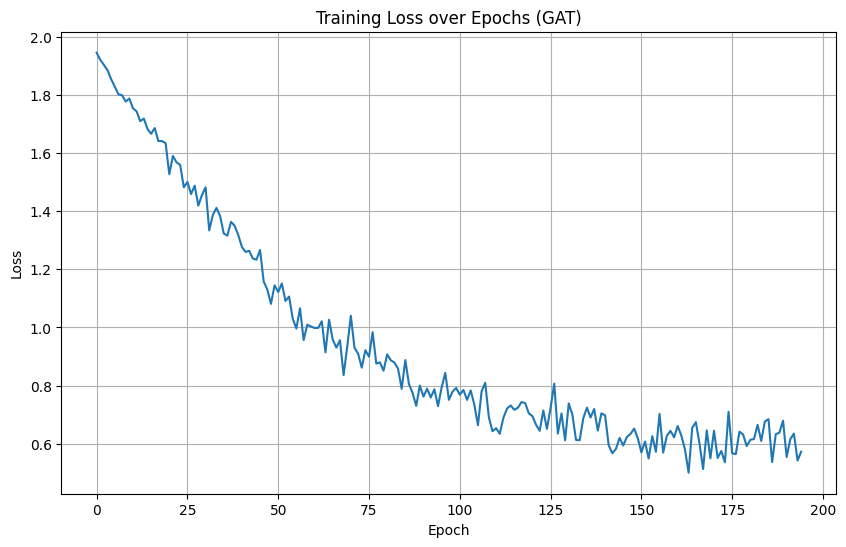

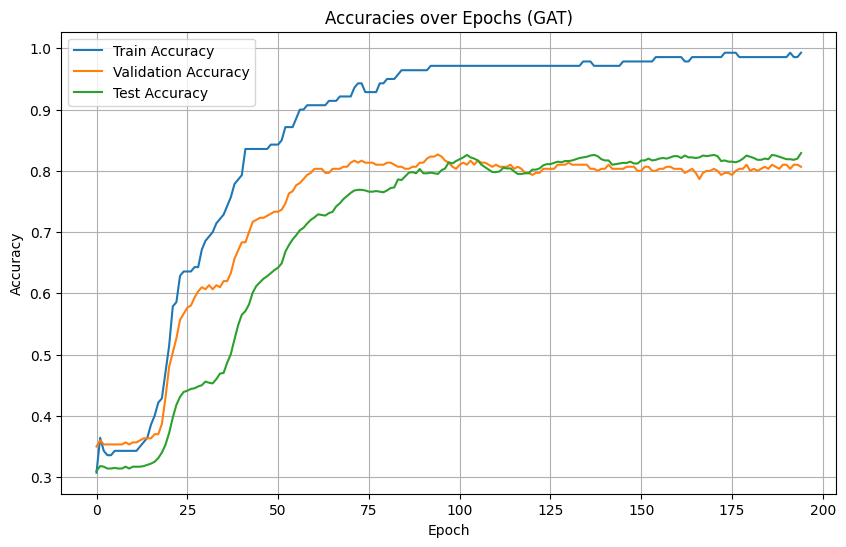

In [30]:
# Plot the loss (GAT)
plt.figure(figsize=(10, 6))
plt.plot(losses_gat)
plt.title('Training Loss over Epochs (GAT)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the accuracies (GAT)
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_gat, label='Train Accuracy')
plt.plot(val_accuracies_gat, label='Validation Accuracy')
plt.plot(test_accuracies_gat, label='Test Accuracy')
plt.title('Accuracies over Epochs (GAT)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [31]:
gat.eval()
output_gat = gat(features, edge_index)
test_output_gat = output_gat[idx_test]
test_labels_gat = labels[idx_test]

predicted_labels_gat = test_output_gat.max(1)[1].type_as(test_labels_gat)

correctly_classified_indices_gat = (predicted_labels_gat == test_labels_gat).nonzero(as_tuple=True)[0]
incorrectly_classified_indices_gat = (predicted_labels_gat != test_labels_gat).nonzero(as_tuple=True)[0]

print("Examples of correct classifications on the test data (GAT):")
for i in correctly_classified_indices_gat[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels_gat[i].item()
    actual_class_index = test_labels_gat[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


print("\nExamples of incorrect classifications on the test data (GAT):")
for i in incorrectly_classified_indices_gat[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels_gat[i].item()
    actual_class_index = test_labels_gat[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


# Visualization of classification results (GAT)
correct_count_gat = len(correctly_classified_indices_gat)
incorrect_count_gat = len(incorrectly_classified_indices_gat)
total_test_samples_gat = len(test_labels_gat)

print(f"\nTotal test samples (GAT): {total_test_samples_gat}")
print(f"Correctly classified (GAT): {correct_count_gat}")
print(f"Incorrectly classified (GAT): {incorrect_count_gat}")

Examples of correct classifications on the test data (GAT):
Node Index (in original dataset): 500, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 501, Predicted Class: Reinforcement_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 502, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 503, Predicted Class: Reinforcement_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 504, Predicted Class: Reinforcement_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 505, Predicted Class: Reinforcement_Learning, Actual Class: Reinforcement_Learning
Node Index (in original dataset): 507, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 508, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 512, Predicted Class: Reinforcement_Learning, Actual C

##Experiments with varying number of attention heads

In [37]:
#  Varying Number of Attention Heads

print("\n--- Experiment: Varying Number of Attention Heads ---")

# Define number of heads to experiment with
heads_to_experiment = [1, 4, 12] # Experiment with 1, 4, and 12 heads (original was 8)

results_heads = {} # To store best test accuracy for each number of heads

for num_heads in heads_to_experiment:
    print(f"\nTraining GAT with {num_heads} attention heads")

    # Re-initialize the model with the new number of heads
    # Keep hidden_channels_gat the same (8), so the first layer output changes (hidden_channels_gat * num_heads)
    current_gat_heads = GAT(in_channels_gat, hidden_channels_gat, out_channels_gat, num_heads, dropout_rate_gat)

    print(f"\nGAT Architecture with {num_heads} heads:")
    print(current_gat_heads)
    print('Number of parameters: ', num_params(current_gat_heads))

    # Re-initialize optimizer
    current_opt_heads = optim.Adam(current_gat_heads.parameters(), lr=0.005, weight_decay=5e-4)

    # Training loop
    best_val_acc_current = 0
    best_test_acc_current = 0
    epochs_no_improve_current = 0
    patience_current = 100

    for epoch in trange(1000):
        current_gat_heads.train()
        current_opt_heads.zero_grad()
        output_current_heads = current_gat_heads(features, edge_index)
        loss_current_heads = F.cross_entropy(output_current_heads[idx_train], labels[idx_train])

        loss_current_heads.backward()
        current_opt_heads.step()

        train_acc_current_heads = compute_accuracy_gat(current_gat_heads, features, edge_index, labels, idx_train)
        val_acc_current_heads = compute_accuracy_gat(current_gat_heads, features, edge_index, labels, idx_val)
        test_acc_current_heads = compute_accuracy_gat(current_gat_heads, features, edge_index, labels, idx_test)

        if val_acc_current_heads > best_val_acc_current:
            best_val_acc_current = val_acc_current_heads
            best_test_acc_current = test_acc_current_heads
            epochs_no_improve_current = 0
        else:
            epochs_no_improve_current += 1
            if epochs_no_improve_current == patience_current:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Optional: print progress less frequently
        # if (epoch + 1) % 100 == 0:
        #    print(f"Epoch {epoch+1}, Loss: {loss_current_heads.item():.4f}, Train Acc: {train_acc_current_heads:.4f}, Val Acc: {val_acc_current_heads:.4f}, Test Acc: {test_acc_current_heads:.4f}")

    print(f"\nBest Validation Accuracy ({num_heads} heads): {best_val_acc_current:.4f}")
    print(f"Test Accuracy at Best Validation ({num_heads} heads): {best_test_acc_current:.4f}")

    results_heads[num_heads] = best_test_acc_current

print("\n--- Summary of Number of Heads Experiment ---")
for num_heads, test_acc in results_heads.items():
    print(f"Number of Heads: {num_heads}, Best Test Accuracy: {test_acc:.4f}")

# Compare with the original GAT (heads_gat = 8)
print(f"Original GAT (8 heads) Best Test Accuracy: {best_test_acc_gat:.4f}")



--- Experiment: Varying Number of Attention Heads ---

Training GAT with 1 attention heads

GAT Architecture with 1 heads:
GAT(
  (conv1): GATConv(1433, 8, heads=1)
  (conv2): GATConv(8, 7, heads=1)
)
Number of parameters:  11565


 40%|███▉      | 396/1000 [00:24<00:37, 16.32it/s]


Early stopping at epoch 397

Best Validation Accuracy (1 heads): 0.8067
Test Accuracy at Best Validation (1 heads): 0.7570

Training GAT with 4 attention heads

GAT Architecture with 4 heads:
GAT(
  (conv1): GATConv(1433, 8, heads=4)
  (conv2): GATConv(32, 7, heads=1)
)
Number of parameters:  46197


 22%|██▏       | 219/1000 [00:22<01:19,  9.80it/s]


Early stopping at epoch 220

Best Validation Accuracy (4 heads): 0.8200
Test Accuracy at Best Validation (4 heads): 0.8010

Training GAT with 12 attention heads

GAT Architecture with 12 heads:
GAT(
  (conv1): GATConv(1433, 8, heads=12)
  (conv2): GATConv(96, 7, heads=1)
)
Number of parameters:  138549


 16%|█▋        | 163/1000 [00:25<02:12,  6.31it/s]

Early stopping at epoch 164

Best Validation Accuracy (12 heads): 0.8300
Test Accuracy at Best Validation (12 heads): 0.8020

--- Summary of Number of Heads Experiment ---
Number of Heads: 1, Best Test Accuracy: 0.7570
Number of Heads: 4, Best Test Accuracy: 0.8010
Number of Heads: 12, Best Test Accuracy: 0.8020
Original GAT (8 heads) Best Test Accuracy: 0.7950


##Experiments with varying number of layers


--- Experiment: Varying Number of Layers ---

Three-Layer GAT Architecture:
ThreeLayerGAT(
  (conv1): GATConv(1433, 8, heads=8)
  (conv2): GATConv(64, 8, heads=8)
  (conv3): GATConv(64, 7, heads=1)
)
Number of parameters Three-Layer GAT:  96661

--- Training Three-Layer GAT ---


  0%|          | 1/1000 [00:00<02:58,  5.59it/s]

Epoch 1, Loss: 1.9452, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 2/1000 [00:00<02:59,  5.55it/s]

Epoch 2, Loss: 1.9161, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 3/1000 [00:00<03:01,  5.49it/s]

Epoch 3, Loss: 1.8804, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 4/1000 [00:00<02:51,  5.79it/s]

Epoch 4, Loss: 1.8433, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 5/1000 [00:00<02:46,  5.99it/s]

Epoch 5, Loss: 1.8070, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 6/1000 [00:01<02:42,  6.12it/s]

Epoch 6, Loss: 1.7827, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 7/1000 [00:01<02:37,  6.30it/s]

Epoch 7, Loss: 1.8229, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 8/1000 [00:01<02:37,  6.29it/s]

Epoch 8, Loss: 1.7805, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 9/1000 [00:01<02:40,  6.19it/s]

Epoch 9, Loss: 1.7386, Train Acc: 0.3857, Val Acc: 0.3667, Test Acc: 0.3220


  1%|          | 10/1000 [00:01<02:40,  6.16it/s]

Epoch 10, Loss: 1.6923, Train Acc: 0.4500, Val Acc: 0.4367, Test Acc: 0.3650


  1%|          | 11/1000 [00:01<02:38,  6.24it/s]

Epoch 11, Loss: 1.6994, Train Acc: 0.5071, Val Acc: 0.5067, Test Acc: 0.4120


  1%|          | 12/1000 [00:01<02:36,  6.29it/s]

Epoch 12, Loss: 1.6737, Train Acc: 0.6000, Val Acc: 0.5400, Test Acc: 0.4310


  1%|▏         | 13/1000 [00:02<02:36,  6.32it/s]

Epoch 13, Loss: 1.6664, Train Acc: 0.6214, Val Acc: 0.5600, Test Acc: 0.4500


  1%|▏         | 14/1000 [00:02<02:35,  6.35it/s]

Epoch 14, Loss: 1.5711, Train Acc: 0.6143, Val Acc: 0.5733, Test Acc: 0.4650


  2%|▏         | 15/1000 [00:02<02:35,  6.34it/s]

Epoch 15, Loss: 1.6091, Train Acc: 0.6143, Val Acc: 0.5867, Test Acc: 0.4660


  2%|▏         | 16/1000 [00:02<02:38,  6.20it/s]

Epoch 16, Loss: 1.5562, Train Acc: 0.6071, Val Acc: 0.5800, Test Acc: 0.4580


  2%|▏         | 17/1000 [00:02<02:37,  6.22it/s]

Epoch 17, Loss: 1.5018, Train Acc: 0.6071, Val Acc: 0.5767, Test Acc: 0.4530


  2%|▏         | 18/1000 [00:02<02:35,  6.30it/s]

Epoch 18, Loss: 1.4965, Train Acc: 0.6286, Val Acc: 0.5767, Test Acc: 0.4480


  2%|▏         | 19/1000 [00:03<02:34,  6.34it/s]

Epoch 19, Loss: 1.4575, Train Acc: 0.6429, Val Acc: 0.5867, Test Acc: 0.4560


  2%|▏         | 20/1000 [00:03<02:32,  6.44it/s]

Epoch 20, Loss: 1.3773, Train Acc: 0.6714, Val Acc: 0.6167, Test Acc: 0.4860


  2%|▏         | 21/1000 [00:03<02:30,  6.49it/s]

Epoch 21, Loss: 1.3916, Train Acc: 0.7071, Val Acc: 0.6300, Test Acc: 0.5310


  2%|▏         | 22/1000 [00:03<02:31,  6.43it/s]

Epoch 22, Loss: 1.2521, Train Acc: 0.7714, Val Acc: 0.6700, Test Acc: 0.5790


  2%|▏         | 23/1000 [00:03<02:36,  6.23it/s]

Epoch 23, Loss: 1.2278, Train Acc: 0.7857, Val Acc: 0.7000, Test Acc: 0.6320


  2%|▏         | 24/1000 [00:03<02:35,  6.26it/s]

Epoch 24, Loss: 1.1387, Train Acc: 0.8143, Val Acc: 0.7267, Test Acc: 0.6700


  2%|▎         | 25/1000 [00:04<02:34,  6.31it/s]

Epoch 25, Loss: 1.2083, Train Acc: 0.8286, Val Acc: 0.7300, Test Acc: 0.7010


  3%|▎         | 26/1000 [00:04<02:33,  6.36it/s]

Epoch 26, Loss: 1.1652, Train Acc: 0.8429, Val Acc: 0.7500, Test Acc: 0.7180


  3%|▎         | 27/1000 [00:04<02:32,  6.38it/s]

Epoch 27, Loss: 1.0832, Train Acc: 0.8500, Val Acc: 0.7500, Test Acc: 0.7280


  3%|▎         | 28/1000 [00:04<02:32,  6.37it/s]

Epoch 28, Loss: 1.1508, Train Acc: 0.8500, Val Acc: 0.7533, Test Acc: 0.7290


  3%|▎         | 29/1000 [00:04<02:37,  6.17it/s]

Epoch 29, Loss: 1.0228, Train Acc: 0.8500, Val Acc: 0.7433, Test Acc: 0.7280


  3%|▎         | 30/1000 [00:04<02:34,  6.27it/s]

Epoch 30, Loss: 0.9497, Train Acc: 0.8571, Val Acc: 0.7667, Test Acc: 0.7300


  3%|▎         | 31/1000 [00:04<02:32,  6.36it/s]

Epoch 31, Loss: 0.9601, Train Acc: 0.8643, Val Acc: 0.7833, Test Acc: 0.7430


  3%|▎         | 32/1000 [00:05<02:33,  6.30it/s]

Epoch 32, Loss: 0.9287, Train Acc: 0.8857, Val Acc: 0.7867, Test Acc: 0.7510


  3%|▎         | 33/1000 [00:05<02:32,  6.35it/s]

Epoch 33, Loss: 0.8847, Train Acc: 0.9000, Val Acc: 0.7933, Test Acc: 0.7670


  3%|▎         | 34/1000 [00:05<02:31,  6.37it/s]

Epoch 34, Loss: 0.8249, Train Acc: 0.9214, Val Acc: 0.7967, Test Acc: 0.7800


  4%|▎         | 35/1000 [00:05<02:30,  6.39it/s]

Epoch 35, Loss: 0.8272, Train Acc: 0.9214, Val Acc: 0.7900, Test Acc: 0.7910


  4%|▎         | 36/1000 [00:05<02:33,  6.28it/s]

Epoch 36, Loss: 0.8405, Train Acc: 0.9214, Val Acc: 0.7833, Test Acc: 0.7940


  4%|▎         | 37/1000 [00:05<02:32,  6.32it/s]

Epoch 37, Loss: 0.6582, Train Acc: 0.9214, Val Acc: 0.7933, Test Acc: 0.7950


  4%|▍         | 38/1000 [00:06<02:31,  6.34it/s]

Epoch 38, Loss: 0.7133, Train Acc: 0.9286, Val Acc: 0.7867, Test Acc: 0.7930


  4%|▍         | 39/1000 [00:06<02:29,  6.42it/s]

Epoch 39, Loss: 0.7700, Train Acc: 0.9286, Val Acc: 0.7900, Test Acc: 0.7940


  4%|▍         | 40/1000 [00:06<02:29,  6.43it/s]

Epoch 40, Loss: 0.7285, Train Acc: 0.9286, Val Acc: 0.7867, Test Acc: 0.8060


  4%|▍         | 41/1000 [00:06<02:52,  5.57it/s]

Epoch 41, Loss: 0.7579, Train Acc: 0.9429, Val Acc: 0.7933, Test Acc: 0.8080


  4%|▍         | 42/1000 [00:06<03:11,  4.99it/s]

Epoch 42, Loss: 0.6969, Train Acc: 0.9429, Val Acc: 0.8133, Test Acc: 0.8110


  4%|▍         | 43/1000 [00:07<03:21,  4.75it/s]

Epoch 43, Loss: 0.6828, Train Acc: 0.9571, Val Acc: 0.8100, Test Acc: 0.8200


  4%|▍         | 44/1000 [00:07<03:30,  4.54it/s]

Epoch 44, Loss: 0.6761, Train Acc: 0.9571, Val Acc: 0.8133, Test Acc: 0.8260


  4%|▍         | 45/1000 [00:07<03:39,  4.36it/s]

Epoch 45, Loss: 0.5897, Train Acc: 0.9571, Val Acc: 0.8233, Test Acc: 0.8310


  5%|▍         | 46/1000 [00:07<03:47,  4.20it/s]

Epoch 46, Loss: 0.7225, Train Acc: 0.9500, Val Acc: 0.8233, Test Acc: 0.8290


  5%|▍         | 47/1000 [00:08<03:50,  4.14it/s]

Epoch 47, Loss: 0.5530, Train Acc: 0.9500, Val Acc: 0.8167, Test Acc: 0.8340


  5%|▍         | 48/1000 [00:08<03:49,  4.14it/s]

Epoch 48, Loss: 0.5486, Train Acc: 0.9429, Val Acc: 0.8200, Test Acc: 0.8220


  5%|▍         | 49/1000 [00:08<03:54,  4.05it/s]

Epoch 49, Loss: 0.5611, Train Acc: 0.9643, Val Acc: 0.8200, Test Acc: 0.8190


  5%|▌         | 50/1000 [00:08<03:53,  4.07it/s]

Epoch 50, Loss: 0.6237, Train Acc: 0.9643, Val Acc: 0.8067, Test Acc: 0.8160


  5%|▌         | 52/1000 [00:09<03:29,  4.52it/s]

Epoch 51, Loss: 0.6696, Train Acc: 0.9643, Val Acc: 0.8100, Test Acc: 0.8150
Epoch 52, Loss: 0.5267, Train Acc: 0.9643, Val Acc: 0.8100, Test Acc: 0.8120


  5%|▌         | 54/1000 [00:09<02:59,  5.27it/s]

Epoch 53, Loss: 0.6497, Train Acc: 0.9571, Val Acc: 0.8100, Test Acc: 0.8100
Epoch 54, Loss: 0.5794, Train Acc: 0.9714, Val Acc: 0.8100, Test Acc: 0.8110


  6%|▌         | 56/1000 [00:09<02:43,  5.79it/s]

Epoch 55, Loss: 0.5754, Train Acc: 0.9714, Val Acc: 0.8000, Test Acc: 0.8200
Epoch 56, Loss: 0.6118, Train Acc: 0.9786, Val Acc: 0.7967, Test Acc: 0.8260


  6%|▌         | 58/1000 [00:10<02:35,  6.07it/s]

Epoch 57, Loss: 0.5781, Train Acc: 0.9786, Val Acc: 0.7800, Test Acc: 0.8320
Epoch 58, Loss: 0.5709, Train Acc: 0.9786, Val Acc: 0.7833, Test Acc: 0.8360


  6%|▌         | 60/1000 [00:10<02:30,  6.26it/s]

Epoch 59, Loss: 0.4592, Train Acc: 0.9786, Val Acc: 0.7867, Test Acc: 0.8310
Epoch 60, Loss: 0.4489, Train Acc: 0.9786, Val Acc: 0.7933, Test Acc: 0.8320


  6%|▌         | 62/1000 [00:10<02:30,  6.24it/s]

Epoch 61, Loss: 0.4498, Train Acc: 0.9786, Val Acc: 0.7867, Test Acc: 0.8340
Epoch 62, Loss: 0.5026, Train Acc: 0.9786, Val Acc: 0.7867, Test Acc: 0.8300


  6%|▋         | 64/1000 [00:11<02:34,  6.07it/s]

Epoch 63, Loss: 0.5110, Train Acc: 0.9786, Val Acc: 0.7933, Test Acc: 0.8310
Epoch 64, Loss: 0.5243, Train Acc: 0.9714, Val Acc: 0.8000, Test Acc: 0.8240


  7%|▋         | 66/1000 [00:11<02:32,  6.12it/s]

Epoch 65, Loss: 0.4377, Train Acc: 0.9714, Val Acc: 0.7967, Test Acc: 0.8160
Epoch 66, Loss: 0.4958, Train Acc: 0.9786, Val Acc: 0.8000, Test Acc: 0.8170


  7%|▋         | 68/1000 [00:11<02:29,  6.22it/s]

Epoch 67, Loss: 0.4412, Train Acc: 0.9786, Val Acc: 0.8033, Test Acc: 0.8160
Epoch 68, Loss: 0.5524, Train Acc: 0.9786, Val Acc: 0.8033, Test Acc: 0.8220


  7%|▋         | 70/1000 [00:12<02:31,  6.12it/s]

Epoch 69, Loss: 0.4465, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8280
Epoch 70, Loss: 0.4863, Train Acc: 0.9786, Val Acc: 0.8133, Test Acc: 0.8330


  7%|▋         | 72/1000 [00:12<02:28,  6.25it/s]

Epoch 71, Loss: 0.4947, Train Acc: 0.9786, Val Acc: 0.7967, Test Acc: 0.8320
Epoch 72, Loss: 0.4764, Train Acc: 0.9786, Val Acc: 0.7867, Test Acc: 0.8350


  7%|▋         | 74/1000 [00:12<02:32,  6.07it/s]

Epoch 73, Loss: 0.4789, Train Acc: 0.9786, Val Acc: 0.7933, Test Acc: 0.8330
Epoch 74, Loss: 0.6000, Train Acc: 0.9786, Val Acc: 0.8033, Test Acc: 0.8350


  8%|▊         | 76/1000 [00:13<02:35,  5.93it/s]

Epoch 75, Loss: 0.4286, Train Acc: 0.9857, Val Acc: 0.8100, Test Acc: 0.8350
Epoch 76, Loss: 0.4713, Train Acc: 0.9786, Val Acc: 0.8233, Test Acc: 0.8380


  8%|▊         | 78/1000 [00:13<02:28,  6.21it/s]

Epoch 77, Loss: 0.4695, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8350
Epoch 78, Loss: 0.4261, Train Acc: 0.9786, Val Acc: 0.8033, Test Acc: 0.8260


  8%|▊         | 80/1000 [00:13<02:28,  6.19it/s]

Epoch 79, Loss: 0.4995, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8260
Epoch 80, Loss: 0.4843, Train Acc: 0.9786, Val Acc: 0.8033, Test Acc: 0.8250


  8%|▊         | 82/1000 [00:14<02:27,  6.22it/s]

Epoch 81, Loss: 0.4455, Train Acc: 0.9929, Val Acc: 0.7967, Test Acc: 0.8180
Epoch 82, Loss: 0.3757, Train Acc: 0.9857, Val Acc: 0.7933, Test Acc: 0.8160


  8%|▊         | 84/1000 [00:14<02:29,  6.11it/s]

Epoch 83, Loss: 0.4678, Train Acc: 0.9857, Val Acc: 0.8000, Test Acc: 0.8200
Epoch 84, Loss: 0.4562, Train Acc: 0.9786, Val Acc: 0.8000, Test Acc: 0.8230


  9%|▊         | 86/1000 [00:14<02:28,  6.16it/s]

Epoch 85, Loss: 0.4765, Train Acc: 0.9786, Val Acc: 0.7967, Test Acc: 0.8220
Epoch 86, Loss: 0.4685, Train Acc: 0.9786, Val Acc: 0.7967, Test Acc: 0.8230


  9%|▉         | 88/1000 [00:15<02:25,  6.28it/s]

Epoch 87, Loss: 0.5384, Train Acc: 0.9714, Val Acc: 0.8000, Test Acc: 0.8230
Epoch 88, Loss: 0.3723, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8230


  9%|▉         | 90/1000 [00:15<02:25,  6.26it/s]

Epoch 89, Loss: 0.5175, Train Acc: 0.9857, Val Acc: 0.8067, Test Acc: 0.8280
Epoch 90, Loss: 0.5046, Train Acc: 0.9786, Val Acc: 0.8000, Test Acc: 0.8320


  9%|▉         | 92/1000 [00:15<02:23,  6.33it/s]

Epoch 91, Loss: 0.4673, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8290
Epoch 92, Loss: 0.4356, Train Acc: 0.9786, Val Acc: 0.8067, Test Acc: 0.8250


  9%|▉         | 94/1000 [00:16<02:20,  6.45it/s]

Epoch 93, Loss: 0.4135, Train Acc: 0.9857, Val Acc: 0.7967, Test Acc: 0.8250
Epoch 94, Loss: 0.4130, Train Acc: 0.9857, Val Acc: 0.7967, Test Acc: 0.8360


 10%|▉         | 96/1000 [00:16<02:24,  6.24it/s]

Epoch 95, Loss: 0.3834, Train Acc: 0.9929, Val Acc: 0.7900, Test Acc: 0.8330
Epoch 96, Loss: 0.3614, Train Acc: 0.9929, Val Acc: 0.7867, Test Acc: 0.8340


 10%|▉         | 98/1000 [00:16<02:22,  6.33it/s]

Epoch 97, Loss: 0.4235, Train Acc: 0.9929, Val Acc: 0.7900, Test Acc: 0.8340
Epoch 98, Loss: 0.3687, Train Acc: 0.9929, Val Acc: 0.7900, Test Acc: 0.8340


 10%|█         | 100/1000 [00:16<02:21,  6.35it/s]

Epoch 99, Loss: 0.3966, Train Acc: 0.9929, Val Acc: 0.7867, Test Acc: 0.8330
Epoch 100, Loss: 0.3696, Train Acc: 0.9929, Val Acc: 0.7900, Test Acc: 0.8360


 10%|█         | 102/1000 [00:17<02:20,  6.40it/s]

Epoch 101, Loss: 0.3857, Train Acc: 0.9929, Val Acc: 0.7933, Test Acc: 0.8370
Epoch 102, Loss: 0.3291, Train Acc: 0.9857, Val Acc: 0.8000, Test Acc: 0.8370


 10%|█         | 104/1000 [00:17<02:20,  6.37it/s]

Epoch 103, Loss: 0.3991, Train Acc: 0.9857, Val Acc: 0.7933, Test Acc: 0.8360
Epoch 104, Loss: 0.4982, Train Acc: 0.9857, Val Acc: 0.7900, Test Acc: 0.8310


 11%|█         | 106/1000 [00:17<02:20,  6.36it/s]

Epoch 105, Loss: 0.4797, Train Acc: 0.9929, Val Acc: 0.7900, Test Acc: 0.8330
Epoch 106, Loss: 0.4409, Train Acc: 0.9857, Val Acc: 0.7900, Test Acc: 0.8320


 11%|█         | 108/1000 [00:18<02:19,  6.38it/s]

Epoch 107, Loss: 0.4383, Train Acc: 0.9857, Val Acc: 0.7867, Test Acc: 0.8300
Epoch 108, Loss: 0.2921, Train Acc: 0.9857, Val Acc: 0.7800, Test Acc: 0.8310


 11%|█         | 110/1000 [00:18<02:22,  6.24it/s]

Epoch 109, Loss: 0.4067, Train Acc: 0.9857, Val Acc: 0.7800, Test Acc: 0.8350
Epoch 110, Loss: 0.5308, Train Acc: 0.9857, Val Acc: 0.7833, Test Acc: 0.8340


 11%|█         | 112/1000 [00:18<02:20,  6.33it/s]

Epoch 111, Loss: 0.4048, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8330
Epoch 112, Loss: 0.3341, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8270


 11%|█▏        | 114/1000 [00:19<02:25,  6.09it/s]

Epoch 113, Loss: 0.3904, Train Acc: 0.9929, Val Acc: 0.7967, Test Acc: 0.8260
Epoch 114, Loss: 0.4126, Train Acc: 0.9929, Val Acc: 0.7967, Test Acc: 0.8280


 12%|█▏        | 115/1000 [00:19<02:45,  5.34it/s]

Epoch 115, Loss: 0.4422, Train Acc: 0.9857, Val Acc: 0.7967, Test Acc: 0.8290


 12%|█▏        | 116/1000 [00:19<03:02,  4.84it/s]

Epoch 116, Loss: 0.3888, Train Acc: 0.9857, Val Acc: 0.8033, Test Acc: 0.8250


 12%|█▏        | 117/1000 [00:19<03:11,  4.61it/s]

Epoch 117, Loss: 0.4548, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8210


 12%|█▏        | 118/1000 [00:20<03:16,  4.48it/s]

Epoch 118, Loss: 0.4082, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8250


 12%|█▏        | 119/1000 [00:20<03:22,  4.35it/s]

Epoch 119, Loss: 0.3899, Train Acc: 0.9929, Val Acc: 0.7967, Test Acc: 0.8320


 12%|█▏        | 120/1000 [00:20<03:26,  4.26it/s]

Epoch 120, Loss: 0.4944, Train Acc: 0.9929, Val Acc: 0.7933, Test Acc: 0.8320


 12%|█▏        | 121/1000 [00:20<03:27,  4.24it/s]

Epoch 121, Loss: 0.4127, Train Acc: 0.9929, Val Acc: 0.7933, Test Acc: 0.8270


 12%|█▏        | 122/1000 [00:21<03:27,  4.23it/s]

Epoch 122, Loss: 0.4407, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8320


 12%|█▏        | 123/1000 [00:21<03:26,  4.25it/s]

Epoch 123, Loss: 0.3579, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8340


 12%|█▏        | 124/1000 [00:21<03:29,  4.17it/s]

Epoch 124, Loss: 0.4475, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8370


 13%|█▎        | 126/1000 [00:22<03:11,  4.57it/s]

Epoch 125, Loss: 0.4084, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8310
Epoch 126, Loss: 0.3620, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8220


 13%|█▎        | 128/1000 [00:22<02:43,  5.33it/s]

Epoch 127, Loss: 0.3499, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8240
Epoch 128, Loss: 0.4349, Train Acc: 0.9929, Val Acc: 0.8100, Test Acc: 0.8210


 13%|█▎        | 130/1000 [00:22<02:34,  5.63it/s]

Epoch 129, Loss: 0.4914, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8240
Epoch 130, Loss: 0.3607, Train Acc: 0.9929, Val Acc: 0.7967, Test Acc: 0.8200


 13%|█▎        | 132/1000 [00:22<02:26,  5.94it/s]

Epoch 131, Loss: 0.3498, Train Acc: 0.9929, Val Acc: 0.7967, Test Acc: 0.8200
Epoch 132, Loss: 0.3395, Train Acc: 0.9929, Val Acc: 0.7900, Test Acc: 0.8250


 13%|█▎        | 134/1000 [00:23<02:21,  6.12it/s]

Epoch 133, Loss: 0.3373, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8300
Epoch 134, Loss: 0.4693, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8310


 14%|█▎        | 136/1000 [00:23<02:19,  6.19it/s]

Epoch 135, Loss: 0.5065, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.8340
Epoch 136, Loss: 0.3582, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.8310


 14%|█▍        | 138/1000 [00:23<02:20,  6.14it/s]

Epoch 137, Loss: 0.4712, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.8290
Epoch 138, Loss: 0.3437, Train Acc: 1.0000, Val Acc: 0.7967, Test Acc: 0.8250


 14%|█▍        | 140/1000 [00:24<02:15,  6.37it/s]

Epoch 139, Loss: 0.4065, Train Acc: 1.0000, Val Acc: 0.8000, Test Acc: 0.8260
Epoch 140, Loss: 0.3226, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8210


 14%|█▍        | 142/1000 [00:24<02:13,  6.41it/s]

Epoch 141, Loss: 0.3785, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8220
Epoch 142, Loss: 0.4208, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8180


 14%|█▍        | 144/1000 [00:24<02:18,  6.18it/s]

Epoch 143, Loss: 0.3825, Train Acc: 0.9929, Val Acc: 0.8000, Test Acc: 0.8180
Epoch 144, Loss: 0.3568, Train Acc: 0.9929, Val Acc: 0.8033, Test Acc: 0.8170


 14%|█▍        | 144/1000 [00:25<02:29,  5.74it/s]


Early stopping at epoch 145

Best Validation Accuracy (Three-Layer GAT): 0.8233
Test Accuracy at Best Validation (Three-Layer GAT): 0.8310


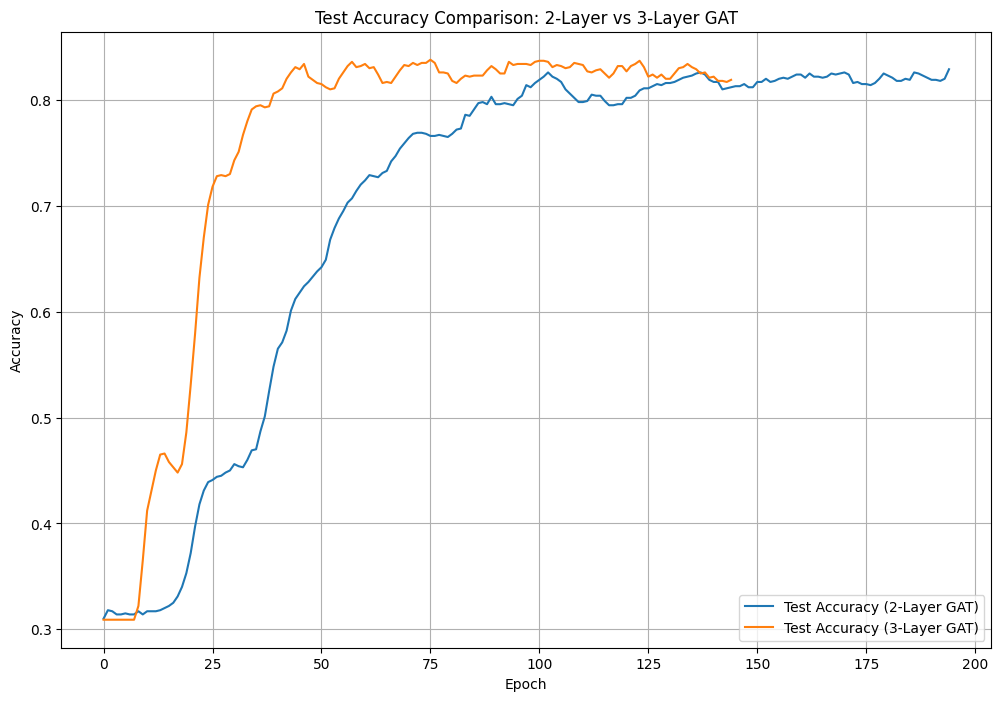

In [38]:
class ThreeLayerGAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels1, hidden_channels2, out_channels, heads1, heads2, dropout):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels1, heads=heads1, dropout=dropout)
        # Output of conv1: hidden_channels1 * heads1
        self.conv2 = GATConv(hidden_channels1 * heads1, hidden_channels2, heads=heads2, dropout=dropout)
        # Output of conv2: hidden_channels2 * heads2
        self.conv3 = GATConv(hidden_channels2 * heads2, out_channels, heads=1, dropout=dropout) # Final layer with single head

    def forward(self, x, edge_index):
        x = F.elu(self.conv1(x, edge_index))
        x = F.elu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)
        return x

print("\n--- Experiment: Varying Number of Layers ---")

# Parameters for the 3-layer GAT
hidden_channels1_3layer = 8
hidden_channels2_3layer = 8
heads1_3layer = 8
heads2_3layer = 8
dropout_rate_3layer = 0.6

three_layer_gat = ThreeLayerGAT(in_channels_gat, hidden_channels1_3layer, hidden_channels2_3layer, out_channels_gat, heads1_3layer, heads2_3layer, dropout_rate_3layer)

print("\nThree-Layer GAT Architecture:")
print(three_layer_gat)
print('Number of parameters Three-Layer GAT: ', num_params(three_layer_gat))

# Training loop for 3-layer GAT
weight_decay_value_3layer = 5e-4
opt_3layer = optim.Adam(three_layer_gat.parameters(), lr=0.005, weight_decay=weight_decay_value_3layer)

losses_3layer = []
train_accuracies_3layer = []
val_accuracies_3layer = []
test_accuracies_3layer = []

best_val_acc_3layer = 0
best_test_acc_3layer = 0
epochs_no_improve_3layer = 0
patience_3layer = 100

print("\n--- Training Three-Layer GAT ---")
for epoch in trange(1000):
    three_layer_gat.train()
    opt_3layer.zero_grad()
    output_3layer = three_layer_gat(features, edge_index)
    loss_3layer = F.cross_entropy(output_3layer[idx_train], labels[idx_train])

    loss_3layer.backward()
    opt_3layer.step()

    losses_3layer.append(loss_3layer.item())

    train_acc_3layer = compute_accuracy_gat(three_layer_gat, features, edge_index, labels, idx_train)
    val_acc_3layer = compute_accuracy_gat(three_layer_gat, features, edge_index, labels, idx_val)
    test_acc_3layer = compute_accuracy_gat(three_layer_gat, features, edge_index, labels, idx_test)

    train_accuracies_3layer.append(train_acc_3layer.item())
    val_accuracies_3layer.append(val_acc_3layer.item())
    test_accuracies_3layer.append(test_acc_3layer.item())

    if val_acc_3layer > best_val_acc_3layer:
        best_val_acc_3layer = val_acc_3layer
        best_test_acc_3layer = test_acc_3layer
        epochs_no_improve_3layer = 0
    else:
        epochs_no_improve_3layer += 1
        if epochs_no_improve_3layer == patience_3layer:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}, Loss: {loss_3layer.item():.4f}, Train Acc: {train_acc_3layer:.4f}, Val Acc: {val_acc_3layer:.4f}, Test Acc: {test_acc_3layer:.4f}")

print(f"\nBest Validation Accuracy (Three-Layer GAT): {best_val_acc_3layer:.4f}")
print(f"Test Accuracy at Best Validation (Three-Layer GAT): {best_test_acc_3layer:.4f}")


# Plotting comparison
plt.figure(figsize=(12, 8))
plt.plot(test_accuracies_gat, label='Test Accuracy (2-Layer GAT)')
plt.plot(test_accuracies_3layer, label='Test Accuracy (3-Layer GAT)')
plt.title('Test Accuracy Comparison: 2-Layer vs 3-Layer GAT')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

##Varying Hidden Feature Dimensionality

In [ ]:
print("\n--- Experiment: Varying Hidden Feature Dimensionality ---")

# Define models with different hidden dimensions
hidden_dims_to_experiment = [16, 32, 64] # Experiment with 16, 32, and 64 hidden units per head

results_hidden_dim = {} # To store best test accuracy for each hidden dimension

for hidden_dim in hidden_dims_to_experiment:
    print(f"\nTraining GAT with hidden dimension: {hidden_dim} per head")

    # Re-initialize the model with the new hidden dimension
    # The total output dimension of the first layer will be hidden_dim * heads
    current_gat = GAT(in_channels_gat, hidden_dim, out_channels_gat, heads_gat, dropout_rate_gat)

    print(f"\nGAT Architecture with hidden_dim={hidden_dim} per head:")
    print(current_gat)
    print('Number of parameters: ', num_params(current_gat))

    # Re-initialize optimizer
    current_opt = optim.Adam(current_gat.parameters(), lr=0.005, weight_decay=5e-4)

    # Training loop
    best_val_acc_current = 0
    best_test_acc_current = 0
    epochs_no_improve_current = 0
    patience_current = 100

    for epoch in trange(1000):
        current_gat.train()
        current_opt.zero_grad()
        output_current = current_gat(features, edge_index)
        loss_current = F.cross_entropy(output_current[idx_train], labels[idx_train])

        loss_current.backward()
        current_opt.step()

        train_acc_current = compute_accuracy_gat(current_gat, features, edge_index, labels, idx_train)
        val_acc_current = compute_accuracy_gat(current_gat, features, edge_index, labels, idx_val)
        test_acc_current = compute_accuracy_gat(current_gat, features, edge_index, labels, idx_test)

        if val_acc_current > best_val_acc_current:
            best_val_acc_current = val_acc_current
            best_test_acc_current = test_acc_current
            epochs_no_improve_current = 0
        else:
            epochs_no_improve_current += 1
            if epochs_no_improve_current == patience_current:
                print(f"Early stopping at epoch {epoch+1}")
                break

        # Optional: print progress less frequently
        # if (epoch + 1) % 100 == 0:
        #    print(f"Epoch {epoch+1}, Loss: {loss_current.item():.4f}, Train Acc: {train_acc_current:.4f}, Val Acc: {val_acc_current:.4f}, Test Acc: {test_acc_current:.4f}")

    print(f"\nBest Validation Accuracy (hidden_dim={hidden_dim} per head): {best_val_acc_current:.4f}")
    print(f"Test Accuracy at Best Validation (hidden_dim={hidden_dim} per head): {best_test_acc_current:.4f}")

    results_hidden_dim[hidden_dim] = best_test_acc_current

print("\n--- Summary of Hidden Dimension Experiment ---")
for hidden_dim, test_acc in results_hidden_dim.items():
    print(f"Hidden Dimension per head: {hidden_dim}, Best Test Accuracy: {test_acc:.4f}")

# Compare with the original GAT (hidden_channels_gat = 8 per head)
print(f"Original GAT (hidden_dim=8 per head) Best Test Accuracy: {best_test_acc_gat:.4f}")

## Varying dropout rate

#Transformers

Different convolution operations: https://pytorch-geometric.readthedocs.io/en/2.5.2/modules/nn.html#convolutional-layers

In [31]:
from torch_geometric.nn import TransformerConv

class GraphTransformerNoPooling(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads, dropout_rate):
        super().__init__()
        self.conv1 = TransformerConv(in_channels, hidden_channels, heads=heads, dropout=dropout_rate)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate)
        self.conv3 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)

        x = self.conv2(x, edge_index)
        x = F.elu(x)

        x = self.conv3(x, edge_index)
        # Optional: ELU before final linear layer
        # x = F.elu(x)

        x = self.lin(x)
        return x

In [33]:
in_channels_trans_np = features.shape[1]
hidden_channels_trans_np = 8 # Similar to GAT hidden dimension per head
out_channels_trans_np = labels.max().item() + 1
heads_trans_np = 8 # Number of attention heads
dropout_rate_trans_np = 0.6 # Dropout rate

graph_transformer_np = GraphTransformerNoPooling(in_channels_trans_np, hidden_channels_trans_np, out_channels_trans_np, heads_trans_np, dropout_rate_trans_np)
print("\nGraph Transformer (No Pooling) Architecture:")
print(graph_transformer_np)
print('Number of parameters Graph Transformer (No Pooling): ', num_params(graph_transformer_np))


Graph Transformer (No Pooling) Architecture:
GraphTransformerNoPooling(
  (conv1): TransformerConv(1433, 8, heads=8)
  (conv2): TransformerConv(64, 8, heads=8)
  (conv3): TransformerConv(64, 8, heads=8)
  (lin): Linear(in_features=64, out_features=7, bias=True)
)
Number of parameters Graph Transformer (No Pooling):  400839


In [34]:
# Define optimizer for Graph Transformer (No Pooling)
weight_decay_value_trans_np = 5e-4 # Common weight decay value
opt_trans_np = optim.Adam(graph_transformer_np.parameters(), lr=0.005, weight_decay=weight_decay_value_trans_np)

# Training loop for Graph Transformer (No Pooling)
losses_trans_np = []
train_accuracies_trans_np = []
val_accuracies_trans_np = []
test_accuracies_trans_np = []

best_val_acc_trans_np = 0
best_test_acc_trans_np = 0
epochs_no_improve_trans_np = 0
patience_trans_np = 100 # Number of epochs to wait for improvement before stopping

print("\n--- Training Graph Transformer (No Pooling) ---")
for epoch in trange(1000):
    graph_transformer_np.train() # Set model to training mode
    opt_trans_np.zero_grad()
    output_trans_np = graph_transformer_np(features, edge_index)
    loss_trans_np = F.cross_entropy(output_trans_np[idx_train], labels[idx_train])

    loss_trans_np.backward()
    opt_trans_np.step()

    losses_trans_np.append(loss_trans_np.item())

    # Use the same accuracy computation function as GAT since the output format is similar
    train_acc_trans_np = compute_accuracy_gat(graph_transformer_np, features, edge_index, labels, idx_train)
    val_acc_trans_np = compute_accuracy_gat(graph_transformer_np, features, edge_index, labels, idx_val)
    test_acc_trans_np = compute_accuracy_gat(graph_transformer_np, features, edge_index, labels, idx_test)

    train_accuracies_trans_np.append(train_acc_trans_np.item())
    val_accuracies_trans_np.append(val_acc_trans_np.item())
    test_accuracies_trans_np.append(test_acc_trans_np.item())

    # Check for early stopping
    if val_acc_trans_np > best_val_acc_trans_np:
        best_val_acc_trans_np = val_acc_trans_np
        best_test_acc_trans_np = test_acc_trans_np # Store the test accuracy when validation accuracy improves
        epochs_no_improve_trans_np = 0
    else:
        epochs_no_improve_trans_np += 1
        if epochs_no_improve_trans_np == patience_trans_np:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print loss and accuracies for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss_trans_np.item():.4f}, Train Acc: {train_acc_trans_np:.4f}, Val Acc: {val_acc_trans_np:.4f}, Test Acc: {test_acc_trans_np:.4f}")

# After the training loop, you can access the lists and the best test accuracy
print(f"\nBest Validation Accuracy (Graph Transformer No Pooling): {best_val_acc_trans_np:.4f}")
print(f"Test Accuracy at Best Validation (Graph Transformer No Pooling): {best_test_acc_trans_np:.4f}")


--- Training Graph Transformer (No Pooling) ---


  0%|          | 1/1000 [00:00<14:49,  1.12it/s]

Epoch 1, Loss: 1.9366, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 2/1000 [00:01<12:36,  1.32it/s]

Epoch 2, Loss: 1.8747, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 3/1000 [00:02<17:07,  1.03s/it]

Epoch 3, Loss: 1.8156, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 4/1000 [00:04<21:09,  1.27s/it]

Epoch 4, Loss: 1.7969, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 5/1000 [00:05<21:51,  1.32s/it]

Epoch 5, Loss: 1.8034, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 6/1000 [00:06<18:19,  1.11s/it]

Epoch 6, Loss: 1.7565, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 7/1000 [00:07<15:38,  1.06it/s]

Epoch 7, Loss: 1.7147, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  1%|          | 8/1000 [00:08<14:41,  1.13it/s]

Epoch 8, Loss: 1.6794, Train Acc: 0.3929, Val Acc: 0.3600, Test Acc: 0.3190


  1%|          | 9/1000 [00:08<14:20,  1.15it/s]

Epoch 9, Loss: 1.6314, Train Acc: 0.5071, Val Acc: 0.4233, Test Acc: 0.3570


  1%|          | 10/1000 [00:09<11:51,  1.39it/s]

Epoch 10, Loss: 1.5428, Train Acc: 0.6143, Val Acc: 0.5300, Test Acc: 0.4040


  1%|          | 11/1000 [00:09<10:09,  1.62it/s]

Epoch 11, Loss: 1.4331, Train Acc: 0.7214, Val Acc: 0.5800, Test Acc: 0.4320


  1%|          | 12/1000 [00:10<09:01,  1.82it/s]

Epoch 12, Loss: 1.2791, Train Acc: 0.7143, Val Acc: 0.6000, Test Acc: 0.4520


  1%|▏         | 13/1000 [00:10<08:09,  2.02it/s]

Epoch 13, Loss: 1.1245, Train Acc: 0.7357, Val Acc: 0.6033, Test Acc: 0.4680


  1%|▏         | 14/1000 [00:10<07:38,  2.15it/s]

Epoch 14, Loss: 0.9536, Train Acc: 0.7571, Val Acc: 0.6333, Test Acc: 0.5150


  2%|▏         | 15/1000 [00:11<07:10,  2.29it/s]

Epoch 15, Loss: 0.8186, Train Acc: 0.8286, Val Acc: 0.6800, Test Acc: 0.5900


  2%|▏         | 16/1000 [00:11<06:54,  2.37it/s]

Epoch 16, Loss: 0.6990, Train Acc: 0.8714, Val Acc: 0.7000, Test Acc: 0.6430


  2%|▏         | 17/1000 [00:11<06:45,  2.42it/s]

Epoch 17, Loss: 0.5926, Train Acc: 0.8857, Val Acc: 0.7100, Test Acc: 0.6800


  2%|▏         | 18/1000 [00:12<06:32,  2.50it/s]

Epoch 18, Loss: 0.5048, Train Acc: 0.9286, Val Acc: 0.7433, Test Acc: 0.6940


  2%|▏         | 19/1000 [00:12<06:33,  2.49it/s]

Epoch 19, Loss: 0.4313, Train Acc: 0.9571, Val Acc: 0.7467, Test Acc: 0.6890


  2%|▏         | 20/1000 [00:13<06:31,  2.50it/s]

Epoch 20, Loss: 0.3661, Train Acc: 0.9500, Val Acc: 0.7533, Test Acc: 0.6560


  2%|▏         | 21/1000 [00:13<06:25,  2.54it/s]

Epoch 21, Loss: 0.2937, Train Acc: 0.9571, Val Acc: 0.7267, Test Acc: 0.6430


  2%|▏         | 22/1000 [00:13<06:25,  2.54it/s]

Epoch 22, Loss: 0.2306, Train Acc: 0.9714, Val Acc: 0.7233, Test Acc: 0.6520


  2%|▏         | 23/1000 [00:14<06:20,  2.57it/s]

Epoch 23, Loss: 0.1928, Train Acc: 0.9714, Val Acc: 0.7133, Test Acc: 0.6540


  2%|▏         | 24/1000 [00:14<06:17,  2.59it/s]

Epoch 24, Loss: 0.1425, Train Acc: 0.9857, Val Acc: 0.7267, Test Acc: 0.6780


  2%|▎         | 25/1000 [00:15<06:18,  2.57it/s]

Epoch 25, Loss: 0.1031, Train Acc: 0.9929, Val Acc: 0.7433, Test Acc: 0.6880


  3%|▎         | 26/1000 [00:15<06:14,  2.60it/s]

Epoch 26, Loss: 0.0795, Train Acc: 0.9929, Val Acc: 0.7500, Test Acc: 0.6990


  3%|▎         | 27/1000 [00:15<06:11,  2.62it/s]

Epoch 27, Loss: 0.0567, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.6940


  3%|▎         | 28/1000 [00:16<07:08,  2.27it/s]

Epoch 28, Loss: 0.0367, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.6920


  3%|▎         | 29/1000 [00:16<07:55,  2.04it/s]

Epoch 29, Loss: 0.0295, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.6910


  3%|▎         | 30/1000 [00:17<08:23,  1.93it/s]

Epoch 30, Loss: 0.0259, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.6950


  3%|▎         | 31/1000 [00:18<08:53,  1.82it/s]

Epoch 31, Loss: 0.0131, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7040


  3%|▎         | 32/1000 [00:18<08:56,  1.80it/s]

Epoch 32, Loss: 0.0118, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7030


  3%|▎         | 33/1000 [00:19<08:02,  2.01it/s]

Epoch 33, Loss: 0.0089, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7010


  3%|▎         | 34/1000 [00:19<07:31,  2.14it/s]

Epoch 34, Loss: 0.0083, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6940


  4%|▎         | 35/1000 [00:19<07:06,  2.26it/s]

Epoch 35, Loss: 0.0063, Train Acc: 1.0000, Val Acc: 0.7233, Test Acc: 0.6870


  4%|▎         | 36/1000 [00:20<06:51,  2.35it/s]

Epoch 36, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.7067, Test Acc: 0.6730


  4%|▎         | 37/1000 [00:20<06:36,  2.43it/s]

Epoch 37, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.6933, Test Acc: 0.6750


  4%|▍         | 38/1000 [00:21<06:26,  2.49it/s]

Epoch 38, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.6867, Test Acc: 0.6720


  4%|▍         | 39/1000 [00:21<06:20,  2.52it/s]

Epoch 39, Loss: 0.0043, Train Acc: 1.0000, Val Acc: 0.6900, Test Acc: 0.6820


  4%|▍         | 40/1000 [00:21<06:18,  2.53it/s]

Epoch 40, Loss: 0.0037, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.6970


  4%|▍         | 41/1000 [00:22<06:18,  2.53it/s]

Epoch 41, Loss: 0.0028, Train Acc: 1.0000, Val Acc: 0.7133, Test Acc: 0.7080


  4%|▍         | 42/1000 [00:22<06:21,  2.51it/s]

Epoch 42, Loss: 0.0025, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.7170


  4%|▍         | 43/1000 [00:22<06:18,  2.53it/s]

Epoch 43, Loss: 0.0045, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.7200


  4%|▍         | 44/1000 [00:23<06:16,  2.54it/s]

Epoch 44, Loss: 0.0028, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.7240


  4%|▍         | 45/1000 [00:23<06:14,  2.55it/s]

Epoch 45, Loss: 0.0025, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7170


  5%|▍         | 46/1000 [00:24<06:10,  2.58it/s]

Epoch 46, Loss: 0.0025, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7190


  5%|▍         | 47/1000 [00:24<06:13,  2.55it/s]

Epoch 47, Loss: 0.0025, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.7250


  5%|▍         | 48/1000 [00:24<06:08,  2.58it/s]

Epoch 48, Loss: 0.0028, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.7250


  5%|▍         | 49/1000 [00:25<06:05,  2.60it/s]

Epoch 49, Loss: 0.0034, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.7280


  5%|▌         | 50/1000 [00:25<06:10,  2.56it/s]

Epoch 50, Loss: 0.0034, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.7310


  5%|▌         | 51/1000 [00:26<06:08,  2.58it/s]

Epoch 51, Loss: 0.0023, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.7370


  5%|▌         | 52/1000 [00:26<06:07,  2.58it/s]

Epoch 52, Loss: 0.0027, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7380


  5%|▌         | 53/1000 [00:26<06:04,  2.60it/s]

Epoch 53, Loss: 0.0039, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7410


  5%|▌         | 54/1000 [00:27<06:01,  2.62it/s]

Epoch 54, Loss: 0.0039, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7400


  6%|▌         | 55/1000 [00:27<06:02,  2.61it/s]

Epoch 55, Loss: 0.0038, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.7380


  6%|▌         | 56/1000 [00:28<06:03,  2.59it/s]

Epoch 56, Loss: 0.0043, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7420


  6%|▌         | 57/1000 [00:28<06:01,  2.61it/s]

Epoch 57, Loss: 0.0040, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7410


  6%|▌         | 58/1000 [00:29<07:48,  2.01it/s]

Epoch 58, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7440


  6%|▌         | 59/1000 [00:30<11:48,  1.33it/s]

Epoch 59, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7450


  6%|▌         | 60/1000 [00:31<12:55,  1.21it/s]

Epoch 60, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7420


  6%|▌         | 61/1000 [00:32<12:48,  1.22it/s]

Epoch 61, Loss: 0.0071, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7480


  6%|▌         | 62/1000 [00:32<11:45,  1.33it/s]

Epoch 62, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7460


  6%|▋         | 63/1000 [00:33<10:59,  1.42it/s]

Epoch 63, Loss: 0.0077, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7490


  6%|▋         | 64/1000 [00:34<10:29,  1.49it/s]

Epoch 64, Loss: 0.0072, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7450


  6%|▋         | 65/1000 [00:34<10:04,  1.55it/s]

Epoch 65, Loss: 0.0071, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7450


  7%|▋         | 66/1000 [00:35<09:47,  1.59it/s]

Epoch 66, Loss: 0.0083, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7400


  7%|▋         | 67/1000 [00:35<09:22,  1.66it/s]

Epoch 67, Loss: 0.0083, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7410


  7%|▋         | 68/1000 [00:36<08:21,  1.86it/s]

Epoch 68, Loss: 0.0070, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7400


  7%|▋         | 69/1000 [00:36<07:36,  2.04it/s]

Epoch 69, Loss: 0.0100, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7370


  7%|▋         | 70/1000 [00:36<07:03,  2.20it/s]

Epoch 70, Loss: 0.0097, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.7400


  7%|▋         | 71/1000 [00:37<06:45,  2.29it/s]

Epoch 71, Loss: 0.0077, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.7410


  7%|▋         | 72/1000 [00:37<06:30,  2.37it/s]

Epoch 72, Loss: 0.0079, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7430


  7%|▋         | 73/1000 [00:38<06:23,  2.42it/s]

Epoch 73, Loss: 0.0077, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7430


  7%|▋         | 74/1000 [00:38<06:30,  2.37it/s]

Epoch 74, Loss: 0.0085, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7420


  8%|▊         | 75/1000 [00:38<06:23,  2.41it/s]

Epoch 75, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7370


  8%|▊         | 76/1000 [00:39<06:16,  2.45it/s]

Epoch 76, Loss: 0.0077, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7320


  8%|▊         | 77/1000 [00:39<06:09,  2.50it/s]

Epoch 77, Loss: 0.0085, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7290


  8%|▊         | 78/1000 [00:40<06:02,  2.54it/s]

Epoch 78, Loss: 0.0084, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7330


  8%|▊         | 79/1000 [00:40<06:02,  2.54it/s]

Epoch 79, Loss: 0.0085, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7270


  8%|▊         | 80/1000 [00:41<07:23,  2.07it/s]

Epoch 80, Loss: 0.0097, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7280


  8%|▊         | 81/1000 [00:41<08:34,  1.78it/s]

Epoch 81, Loss: 0.0080, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7300


  8%|▊         | 82/1000 [00:43<11:16,  1.36it/s]

Epoch 82, Loss: 0.0087, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7310


  8%|▊         | 83/1000 [00:44<13:31,  1.13it/s]

Epoch 83, Loss: 0.0080, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7360


  8%|▊         | 84/1000 [00:45<14:17,  1.07it/s]

Epoch 84, Loss: 0.0080, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7380


  8%|▊         | 85/1000 [00:46<13:19,  1.15it/s]

Epoch 85, Loss: 0.0098, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7410


  9%|▊         | 86/1000 [00:46<11:02,  1.38it/s]

Epoch 86, Loss: 0.0085, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.7330


  9%|▊         | 87/1000 [00:46<09:30,  1.60it/s]

Epoch 87, Loss: 0.0084, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7330


  9%|▉         | 88/1000 [00:47<08:24,  1.81it/s]

Epoch 88, Loss: 0.0081, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7350


  9%|▉         | 89/1000 [00:47<07:37,  1.99it/s]

Epoch 89, Loss: 0.0098, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7300


  9%|▉         | 90/1000 [00:48<07:04,  2.14it/s]

Epoch 90, Loss: 0.0076, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7330


  9%|▉         | 91/1000 [00:48<06:39,  2.27it/s]

Epoch 91, Loss: 0.0076, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7330


  9%|▉         | 92/1000 [00:48<06:26,  2.35it/s]

Epoch 92, Loss: 0.0063, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7410


  9%|▉         | 93/1000 [00:49<06:13,  2.43it/s]

Epoch 93, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7380


  9%|▉         | 94/1000 [00:49<06:04,  2.48it/s]

Epoch 94, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7420


 10%|▉         | 95/1000 [00:49<06:04,  2.48it/s]

Epoch 95, Loss: 0.0072, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7420


 10%|▉         | 96/1000 [00:50<06:17,  2.40it/s]

Epoch 96, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7450


 10%|▉         | 97/1000 [00:50<07:04,  2.12it/s]

Epoch 97, Loss: 0.0142, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7100


 10%|▉         | 98/1000 [00:51<07:29,  2.01it/s]

Epoch 98, Loss: 0.0113, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7320


 10%|▉         | 99/1000 [00:52<07:57,  1.89it/s]

Epoch 99, Loss: 0.0081, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7370


 10%|█         | 100/1000 [00:52<08:12,  1.83it/s]

Epoch 100, Loss: 0.0087, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.7290


 10%|█         | 101/1000 [00:53<08:38,  1.73it/s]

Epoch 101, Loss: 0.0153, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7250


 10%|█         | 102/1000 [00:54<08:48,  1.70it/s]

Epoch 102, Loss: 0.0084, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6830


 10%|█         | 103/1000 [00:54<08:39,  1.73it/s]

Epoch 103, Loss: 0.0169, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7400


 10%|█         | 104/1000 [00:54<07:50,  1.90it/s]

Epoch 104, Loss: 0.0073, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.7360


 10%|█         | 105/1000 [00:55<07:28,  2.00it/s]

Epoch 105, Loss: 0.0120, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7290


 11%|█         | 106/1000 [00:56<07:55,  1.88it/s]

Epoch 106, Loss: 0.0097, Train Acc: 1.0000, Val Acc: 0.7767, Test Acc: 0.7370


 11%|█         | 107/1000 [00:56<08:11,  1.82it/s]

Epoch 107, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7120


 11%|█         | 108/1000 [00:57<08:27,  1.76it/s]

Epoch 108, Loss: 0.0070, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.6980


 11%|█         | 109/1000 [00:57<08:34,  1.73it/s]

Epoch 109, Loss: 0.0104, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7350


 11%|█         | 110/1000 [00:58<08:12,  1.81it/s]

Epoch 110, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7510


 11%|█         | 111/1000 [00:58<07:58,  1.86it/s]

Epoch 111, Loss: 0.0045, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7520


 11%|█         | 112/1000 [00:59<08:13,  1.80it/s]

Epoch 112, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7500


 11%|█▏        | 113/1000 [00:59<08:18,  1.78it/s]

Epoch 113, Loss: 0.0077, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7570


 11%|█▏        | 114/1000 [01:00<08:20,  1.77it/s]

Epoch 114, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7510


 12%|█▏        | 115/1000 [01:01<08:30,  1.73it/s]

Epoch 115, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7370


 12%|█▏        | 116/1000 [01:01<08:03,  1.83it/s]

Epoch 116, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7350


 12%|█▏        | 117/1000 [01:02<08:19,  1.77it/s]

Epoch 117, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7370


 12%|█▏        | 118/1000 [01:02<08:45,  1.68it/s]

Epoch 118, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7233, Test Acc: 0.7350


 12%|█▏        | 119/1000 [01:03<08:46,  1.67it/s]

Epoch 119, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.7340


 12%|█▏        | 120/1000 [01:04<08:46,  1.67it/s]

Epoch 120, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7390


 12%|█▏        | 121/1000 [01:04<09:08,  1.60it/s]

Epoch 121, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7390


 12%|█▏        | 122/1000 [01:05<09:01,  1.62it/s]

Epoch 122, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7460


 12%|█▏        | 123/1000 [01:06<09:05,  1.61it/s]

Epoch 123, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7440


 12%|█▏        | 124/1000 [01:06<08:13,  1.77it/s]

Epoch 124, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7460


 12%|█▎        | 125/1000 [01:06<07:30,  1.94it/s]

Epoch 125, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7550


 13%|█▎        | 126/1000 [01:07<06:54,  2.11it/s]

Epoch 126, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7590


 13%|█▎        | 127/1000 [01:07<06:33,  2.22it/s]

Epoch 127, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7600


 13%|█▎        | 128/1000 [01:08<06:14,  2.33it/s]

Epoch 128, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7520


 13%|█▎        | 129/1000 [01:08<06:43,  2.16it/s]

Epoch 129, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7450


 13%|█▎        | 130/1000 [01:09<07:19,  1.98it/s]

Epoch 130, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7450


 13%|█▎        | 131/1000 [01:10<09:39,  1.50it/s]

Epoch 131, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7510


 13%|█▎        | 132/1000 [01:11<12:31,  1.15it/s]

Epoch 132, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7550


 13%|█▎        | 133/1000 [01:12<11:21,  1.27it/s]

Epoch 133, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7570


 13%|█▎        | 134/1000 [01:12<10:30,  1.37it/s]

Epoch 134, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7580


 14%|█▎        | 135/1000 [01:13<09:58,  1.45it/s]

Epoch 135, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7540


 14%|█▎        | 136/1000 [01:13<09:03,  1.59it/s]

Epoch 136, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7530


 14%|█▎        | 137/1000 [01:14<08:02,  1.79it/s]

Epoch 137, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7530


 14%|█▍        | 138/1000 [01:14<07:15,  1.98it/s]

Epoch 138, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7530


 14%|█▍        | 139/1000 [01:14<06:44,  2.13it/s]

Epoch 139, Loss: 0.0085, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7550


 14%|█▍        | 140/1000 [01:15<06:22,  2.25it/s]

Epoch 140, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7560


 14%|█▍        | 141/1000 [01:15<06:08,  2.33it/s]

Epoch 141, Loss: 0.0078, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7550


 14%|█▍        | 142/1000 [01:16<06:01,  2.38it/s]

Epoch 142, Loss: 0.0081, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7580


 14%|█▍        | 143/1000 [01:16<05:49,  2.45it/s]

Epoch 143, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7570


 14%|█▍        | 144/1000 [01:16<05:45,  2.48it/s]

Epoch 144, Loss: 0.0079, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7500


 14%|█▍        | 145/1000 [01:17<05:43,  2.49it/s]

Epoch 145, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7520


 15%|█▍        | 146/1000 [01:17<05:38,  2.53it/s]

Epoch 146, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7480


 15%|█▍        | 147/1000 [01:18<05:35,  2.54it/s]

Epoch 147, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7460


 15%|█▍        | 148/1000 [01:18<05:35,  2.54it/s]

Epoch 148, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7510


 15%|█▍        | 149/1000 [01:18<05:33,  2.55it/s]

Epoch 149, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7510


 15%|█▌        | 150/1000 [01:19<05:33,  2.55it/s]

Epoch 150, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7570


 15%|█▌        | 151/1000 [01:19<05:35,  2.53it/s]

Epoch 151, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7560


 15%|█▌        | 152/1000 [01:20<05:31,  2.55it/s]

Epoch 152, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7500


 15%|█▌        | 153/1000 [01:20<05:31,  2.56it/s]

Epoch 153, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7520


 15%|█▌        | 154/1000 [01:20<05:29,  2.57it/s]

Epoch 154, Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7520


 16%|█▌        | 155/1000 [01:21<05:26,  2.59it/s]

Epoch 155, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7510


 16%|█▌        | 156/1000 [01:21<06:19,  2.23it/s]

Epoch 156, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7767, Test Acc: 0.7500


 16%|█▌        | 157/1000 [01:22<06:59,  2.01it/s]

Epoch 157, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7520


 16%|█▌        | 158/1000 [01:23<07:24,  1.89it/s]

Epoch 158, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7460


 16%|█▌        | 159/1000 [01:23<07:41,  1.82it/s]

Epoch 159, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7500


 16%|█▌        | 160/1000 [01:24<07:47,  1.80it/s]

Epoch 160, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7500


 16%|█▌        | 161/1000 [01:24<07:07,  1.96it/s]

Epoch 161, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7767, Test Acc: 0.7550


 16%|█▌        | 162/1000 [01:24<06:34,  2.13it/s]

Epoch 162, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7580


 16%|█▋        | 163/1000 [01:25<06:09,  2.27it/s]

Epoch 163, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7580


 16%|█▋        | 164/1000 [01:25<05:58,  2.34it/s]

Epoch 164, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7490


 16%|█▋        | 165/1000 [01:26<05:44,  2.42it/s]

Epoch 165, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7520


 17%|█▋        | 166/1000 [01:26<05:34,  2.49it/s]

Epoch 166, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7520


 17%|█▋        | 167/1000 [01:26<05:32,  2.50it/s]

Epoch 167, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7510


 17%|█▋        | 168/1000 [01:27<05:27,  2.54it/s]

Epoch 168, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7767, Test Acc: 0.7500


 17%|█▋        | 169/1000 [01:27<05:25,  2.55it/s]

Epoch 169, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7510


 17%|█▋        | 170/1000 [01:28<05:23,  2.57it/s]

Epoch 170, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7550


 17%|█▋        | 171/1000 [01:28<05:18,  2.61it/s]

Epoch 171, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7610


 17%|█▋        | 172/1000 [01:28<05:20,  2.58it/s]

Epoch 172, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7590


 17%|█▋        | 173/1000 [01:29<05:35,  2.47it/s]

Epoch 173, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7540


 17%|█▋        | 174/1000 [01:29<06:35,  2.09it/s]

Epoch 174, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7560


 18%|█▊        | 175/1000 [01:30<06:39,  2.07it/s]

Epoch 175, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7520


 18%|█▊        | 176/1000 [01:30<06:16,  2.19it/s]

Epoch 176, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7600


 18%|█▊        | 177/1000 [01:31<05:57,  2.30it/s]

Epoch 177, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7630


 18%|█▊        | 178/1000 [01:31<05:45,  2.38it/s]

Epoch 178, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7620


 18%|█▊        | 179/1000 [01:31<05:38,  2.43it/s]

Epoch 179, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7580


 18%|█▊        | 180/1000 [01:32<05:30,  2.48it/s]

Epoch 180, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7540


 18%|█▊        | 181/1000 [01:32<05:27,  2.50it/s]

Epoch 181, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7530


 18%|█▊        | 182/1000 [01:33<05:27,  2.50it/s]

Epoch 182, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7520


 18%|█▊        | 183/1000 [01:33<05:25,  2.51it/s]

Epoch 183, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7500


 18%|█▊        | 184/1000 [01:33<05:28,  2.48it/s]

Epoch 184, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7530


 18%|█▊        | 185/1000 [01:34<05:40,  2.39it/s]

Epoch 185, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7500


 19%|█▊        | 186/1000 [01:35<06:45,  2.01it/s]

Epoch 186, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7510


 19%|█▊        | 187/1000 [01:35<07:05,  1.91it/s]

Epoch 187, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7580


 19%|█▉        | 188/1000 [01:36<07:25,  1.82it/s]

Epoch 188, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7590


 19%|█▉        | 189/1000 [01:36<07:36,  1.78it/s]

Epoch 189, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7530


 19%|█▉        | 190/1000 [01:37<07:10,  1.88it/s]

Epoch 190, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7520


 19%|█▉        | 191/1000 [01:37<06:51,  1.96it/s]

Epoch 191, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7510


 19%|█▉        | 192/1000 [01:38<07:12,  1.87it/s]

Epoch 192, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7520


 19%|█▉        | 193/1000 [01:38<07:23,  1.82it/s]

Epoch 193, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7540


 19%|█▉        | 194/1000 [01:39<07:04,  1.90it/s]

Epoch 194, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7833, Test Acc: 0.7590


 20%|█▉        | 195/1000 [01:39<07:09,  1.87it/s]

Epoch 195, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7620


 20%|█▉        | 196/1000 [01:40<06:38,  2.02it/s]

Epoch 196, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7620


 20%|█▉        | 197/1000 [01:41<07:03,  1.90it/s]

Epoch 197, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7600


 20%|█▉        | 198/1000 [01:41<08:16,  1.62it/s]

Epoch 198, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7530


 20%|█▉        | 199/1000 [01:42<07:30,  1.78it/s]

Epoch 199, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7540


 20%|██        | 200/1000 [01:42<07:49,  1.70it/s]

Epoch 200, Loss: 0.0073, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7460


 20%|██        | 201/1000 [01:43<07:45,  1.72it/s]

Epoch 201, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7420


 20%|██        | 202/1000 [01:43<07:12,  1.85it/s]

Epoch 202, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7490


 20%|██        | 203/1000 [01:44<06:42,  1.98it/s]

Epoch 203, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7610


 20%|██        | 204/1000 [01:44<06:44,  1.97it/s]

Epoch 204, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7570


 20%|██        | 205/1000 [01:45<07:14,  1.83it/s]

Epoch 205, Loss: 0.0093, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7560


 21%|██        | 206/1000 [01:45<06:59,  1.89it/s]

Epoch 206, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7460


 21%|██        | 207/1000 [01:46<06:26,  2.05it/s]

Epoch 207, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7530


 21%|██        | 208/1000 [01:46<06:29,  2.04it/s]

Epoch 208, Loss: 0.0046, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.7500


 21%|██        | 209/1000 [01:47<07:32,  1.75it/s]

Epoch 209, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.7440


 21%|██        | 210/1000 [01:48<08:48,  1.50it/s]

Epoch 210, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7360


 21%|██        | 211/1000 [01:49<10:08,  1.30it/s]

Epoch 211, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7320


 21%|██        | 212/1000 [01:50<10:31,  1.25it/s]

Epoch 212, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7470


 21%|██▏       | 213/1000 [01:51<09:46,  1.34it/s]

Epoch 213, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7620


 21%|██▏       | 214/1000 [01:51<08:20,  1.57it/s]

Epoch 214, Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7670


 22%|██▏       | 215/1000 [01:51<07:45,  1.69it/s]

Epoch 215, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7630


 22%|██▏       | 216/1000 [01:52<07:08,  1.83it/s]

Epoch 216, Loss: 0.0046, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7580


 22%|██▏       | 217/1000 [01:53<07:38,  1.71it/s]

Epoch 217, Loss: 0.0045, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7370


 22%|██▏       | 218/1000 [01:53<08:04,  1.61it/s]

Epoch 218, Loss: 0.0038, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7240


 22%|██▏       | 219/1000 [01:54<08:02,  1.62it/s]

Epoch 219, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7360


 22%|██▏       | 220/1000 [01:55<08:29,  1.53it/s]

Epoch 220, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7510


 22%|██▏       | 221/1000 [01:55<08:21,  1.55it/s]

Epoch 221, Loss: 0.0042, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7580


 22%|██▏       | 222/1000 [01:56<08:13,  1.57it/s]

Epoch 222, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7580


 22%|██▏       | 223/1000 [01:56<08:03,  1.61it/s]

Epoch 223, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7590


 22%|██▏       | 224/1000 [01:57<08:06,  1.60it/s]

Epoch 224, Loss: 0.0042, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7460


 22%|██▎       | 225/1000 [01:57<07:10,  1.80it/s]

Epoch 225, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7550


 23%|██▎       | 226/1000 [01:58<06:33,  1.97it/s]

Epoch 226, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7520


 23%|██▎       | 227/1000 [01:58<06:01,  2.14it/s]

Epoch 227, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7560


 23%|██▎       | 228/1000 [01:59<06:27,  1.99it/s]

Epoch 228, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7550


 23%|██▎       | 229/1000 [01:59<06:46,  1.90it/s]

Epoch 229, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7580


 23%|██▎       | 230/1000 [02:00<07:41,  1.67it/s]

Epoch 230, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7580


 23%|██▎       | 231/1000 [02:01<08:55,  1.44it/s]

Epoch 231, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7620


 23%|██▎       | 232/1000 [02:02<11:00,  1.16it/s]

Epoch 232, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7640


 23%|██▎       | 233/1000 [02:03<10:49,  1.18it/s]

Epoch 233, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.7600


 23%|██▎       | 234/1000 [02:04<10:17,  1.24it/s]

Epoch 234, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7580


 24%|██▎       | 235/1000 [02:04<09:02,  1.41it/s]

Epoch 235, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7420


 24%|██▎       | 236/1000 [02:05<07:49,  1.63it/s]

Epoch 236, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7510


 24%|██▎       | 237/1000 [02:05<06:56,  1.83it/s]

Epoch 237, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7600


 24%|██▍       | 238/1000 [02:05<06:23,  1.99it/s]

Epoch 238, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7620


 24%|██▍       | 239/1000 [02:06<05:54,  2.14it/s]

Epoch 239, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7630


 24%|██▍       | 240/1000 [02:06<05:37,  2.25it/s]

Epoch 240, Loss: 0.0046, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7480


 24%|██▍       | 241/1000 [02:07<05:23,  2.35it/s]

Epoch 241, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7480


 24%|██▍       | 242/1000 [02:07<05:11,  2.44it/s]

Epoch 242, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7580


 24%|██▍       | 243/1000 [02:07<05:07,  2.46it/s]

Epoch 243, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7590


 24%|██▍       | 244/1000 [02:08<05:01,  2.50it/s]

Epoch 244, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7650


 24%|██▍       | 245/1000 [02:08<04:57,  2.54it/s]

Epoch 245, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7660


 25%|██▍       | 246/1000 [02:09<04:57,  2.54it/s]

Epoch 246, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7833, Test Acc: 0.7600


 25%|██▍       | 247/1000 [02:09<04:52,  2.57it/s]

Epoch 247, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7560


 25%|██▍       | 248/1000 [02:09<04:55,  2.55it/s]

Epoch 248, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.7530


 25%|██▍       | 249/1000 [02:10<04:51,  2.58it/s]

Epoch 249, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.7510


 25%|██▌       | 250/1000 [02:10<04:48,  2.60it/s]

Epoch 250, Loss: 0.0042, Train Acc: 1.0000, Val Acc: 0.7833, Test Acc: 0.7580


 25%|██▌       | 251/1000 [02:10<04:50,  2.58it/s]

Epoch 251, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7650


 25%|██▌       | 252/1000 [02:11<04:47,  2.60it/s]

Epoch 252, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7600


 25%|██▌       | 253/1000 [02:11<04:46,  2.61it/s]

Epoch 253, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7560


 25%|██▌       | 254/1000 [02:12<04:48,  2.59it/s]

Epoch 254, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7470


 26%|██▌       | 255/1000 [02:12<04:46,  2.60it/s]

Epoch 255, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7500


 26%|██▌       | 256/1000 [02:12<04:48,  2.58it/s]

Epoch 256, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7630


 26%|██▌       | 257/1000 [02:13<04:47,  2.58it/s]

Epoch 257, Loss: 0.0045, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7610


 26%|██▌       | 258/1000 [02:13<04:45,  2.60it/s]

Epoch 258, Loss: 0.0044, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7590


 26%|██▌       | 259/1000 [02:14<04:53,  2.52it/s]

Epoch 259, Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7630


 26%|██▌       | 260/1000 [02:14<05:36,  2.20it/s]

Epoch 260, Loss: 0.0045, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.7560


 26%|██▌       | 261/1000 [02:15<06:09,  2.00it/s]

Epoch 261, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.7520


 26%|██▌       | 262/1000 [02:15<06:33,  1.88it/s]

Epoch 262, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7500


 26%|██▋       | 263/1000 [02:16<06:47,  1.81it/s]

Epoch 263, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7500


 26%|██▋       | 264/1000 [02:17<06:38,  1.85it/s]

Epoch 264, Loss: 0.0063, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7590


 26%|██▋       | 265/1000 [02:17<06:06,  2.00it/s]

Epoch 265, Loss: 0.0040, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.7620


 27%|██▋       | 266/1000 [02:17<05:40,  2.16it/s]

Epoch 266, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7620


 27%|██▋       | 267/1000 [02:18<05:23,  2.26it/s]

Epoch 267, Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.7700, Test Acc: 0.7560


 27%|██▋       | 268/1000 [02:18<05:12,  2.34it/s]

Epoch 268, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.7800, Test Acc: 0.7560


 27%|██▋       | 269/1000 [02:18<05:03,  2.41it/s]

Epoch 269, Loss: 0.0045, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7460


 27%|██▋       | 270/1000 [02:19<04:59,  2.43it/s]

Epoch 270, Loss: 0.0046, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7500


 27%|██▋       | 271/1000 [02:19<04:54,  2.48it/s]

Epoch 271, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7530


 27%|██▋       | 272/1000 [02:20<04:51,  2.50it/s]

Epoch 272, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7590


 27%|██▋       | 273/1000 [02:20<04:50,  2.50it/s]

Epoch 273, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7650


 27%|██▋       | 274/1000 [02:20<04:45,  2.54it/s]

Epoch 274, Loss: 0.0045, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7640


 28%|██▊       | 275/1000 [02:21<04:43,  2.55it/s]

Epoch 275, Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.7767, Test Acc: 0.7690


 28%|██▊       | 276/1000 [02:21<04:44,  2.54it/s]

Epoch 276, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7670


 28%|██▊       | 277/1000 [02:22<04:44,  2.54it/s]

Epoch 277, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7630


 28%|██▊       | 278/1000 [02:22<04:50,  2.48it/s]

Epoch 278, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7490


 28%|██▊       | 279/1000 [02:22<04:46,  2.51it/s]

Epoch 279, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7440


 28%|██▊       | 280/1000 [02:23<04:44,  2.53it/s]

Epoch 280, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7733, Test Acc: 0.7490


 28%|██▊       | 281/1000 [02:23<04:44,  2.53it/s]

Epoch 281, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7710


 28%|██▊       | 282/1000 [02:24<04:42,  2.54it/s]

Epoch 282, Loss: 0.0044, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7690


 28%|██▊       | 283/1000 [02:24<04:42,  2.54it/s]

Epoch 283, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7640


 28%|██▊       | 284/1000 [02:24<04:40,  2.56it/s]

Epoch 284, Loss: 0.0047, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7430


 28%|██▊       | 285/1000 [02:25<04:40,  2.55it/s]

Epoch 285, Loss: 0.0044, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7340


 29%|██▊       | 286/1000 [02:25<04:40,  2.54it/s]

Epoch 286, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7240


 29%|██▊       | 287/1000 [02:26<04:39,  2.55it/s]

Epoch 287, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.7467, Test Acc: 0.7560


 29%|██▉       | 288/1000 [02:26<04:36,  2.57it/s]

Epoch 288, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7650


 29%|██▉       | 289/1000 [02:26<04:38,  2.55it/s]

Epoch 289, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7540


 29%|██▉       | 290/1000 [02:27<05:16,  2.24it/s]

Epoch 290, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.7667, Test Acc: 0.7530


 29%|██▉       | 291/1000 [02:28<05:52,  2.01it/s]

Epoch 291, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7480


 29%|██▉       | 292/1000 [02:28<06:14,  1.89it/s]

Epoch 292, Loss: 0.0035, Train Acc: 1.0000, Val Acc: 0.7533, Test Acc: 0.7420


 29%|██▉       | 293/1000 [02:29<06:32,  1.80it/s]

Epoch 293, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.7490


 29%|██▉       | 293/1000 [02:29<06:01,  1.96it/s]

Early stopping at epoch 294

Best Validation Accuracy (Graph Transformer No Pooling): 0.7833
Test Accuracy at Best Validation (Graph Transformer No Pooling): 0.7590


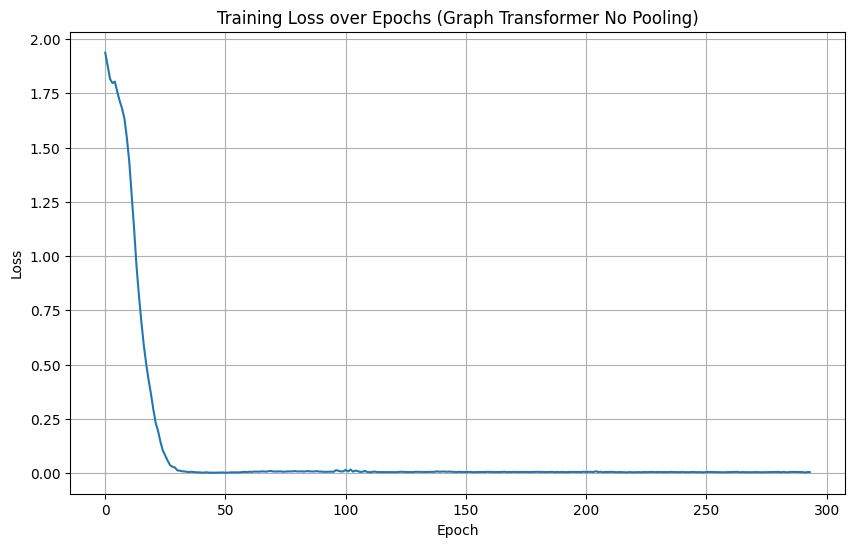

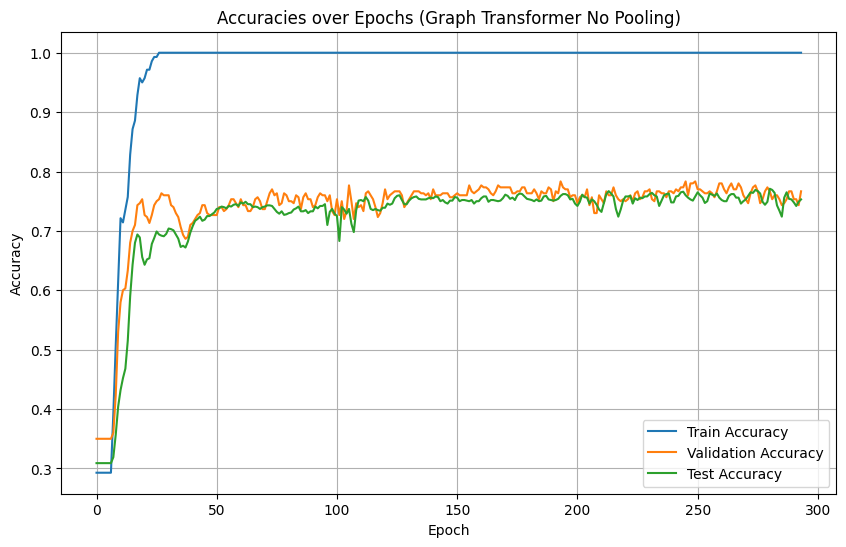

In [35]:
# Plot the loss (Graph Transformer No Pooling)
plt.figure(figsize=(10, 6))
plt.plot(losses_trans_np)
plt.title('Training Loss over Epochs (Graph Transformer No Pooling)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the accuracies (Graph Transformer No Pooling)
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_trans_np, label='Train Accuracy')
plt.plot(val_accuracies_trans_np, label='Validation Accuracy')
plt.plot(test_accuracies_trans_np, label='Test Accuracy')
plt.title('Accuracies over Epochs (Graph Transformer No Pooling)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

In [36]:
# Visualization of classification results (Graph Transformer No Pooling)
graph_transformer_np.eval()
output_trans_np = graph_transformer_np(features, edge_index)
test_output_trans_np = output_trans_np[idx_test]
test_labels_trans_np = labels[idx_test]

predicted_labels_trans_np = test_output_trans_np.max(1)[1].type_as(test_labels_trans_np)

correctly_classified_indices_trans_np = (predicted_labels_trans_np == test_labels_trans_np).nonzero(as_tuple=True)[0]
incorrectly_classified_indices_trans_np = (predicted_labels_trans_np != test_labels_trans_np).nonzero(as_tuple=True)[0]

print("Examples of correct classifications on the test data (Graph Transformer No Pooling):")
for i in correctly_classified_indices_trans_np[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels_trans_np[i].item()
    actual_class_index = test_labels_trans_np[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


print("\nExamples of incorrect classifications on the test data (Graph Transformer No Pooling):")
for i in incorrectly_classified_indices_trans_np[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels_trans_np[i].item()
    actual_class_index = test_labels_trans_np[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


# Visualization of classification results (Graph Transformer No Pooling)
correct_count_trans_np = len(correctly_classified_indices_trans_np)
incorrect_count_trans_np = len(incorrectly_classified_indices_trans_np)
total_test_samples_trans_np = len(test_labels_trans_np)

print(f"\nTotal test samples (Graph Transformer No Pooling): {total_test_samples_trans_np}")
print(f"Correctly classified (Graph Transformer No Pooling): {correct_count_trans_np}")
print(f"Incorrectly classified (Graph Transformer No Pooling): {incorrect_count_trans_np}")


Examples of correct classifications on the test data (Graph Transformer No Pooling):
Node Index (in original dataset): 500, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 501, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 502, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 503, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 504, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 505, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 507, Predicted Class: Genetic_Algorithms, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 508, Predicted Class: Genetic_Algorithms, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 512, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 

##Transformer with Positional Encodings


Graph Transformer with Positional Encoding Architecture:
GraphTransformerWithPositionalEncoding(
  (feature_projection): Linear(in_features=1433, out_features=64, bias=True)
  (conv1): TransformerConv(64, 8, heads=8)
  (lin): Linear(in_features=64, out_features=7, bias=True)
)
Number of parameters Graph Transformer with Positional Encoding:  108871

--- Training Graph Transformer with Positional Encoding ---


  0%|          | 1/1000 [00:00<01:58,  8.40it/s]

Epoch 1, Loss: 1.9307, Train Acc: 0.3214, Val Acc: 0.3400, Test Acc: 0.2500


  0%|          | 2/1000 [00:00<02:01,  8.21it/s]

Epoch 2, Loss: 1.7838, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.2760


  0%|          | 3/1000 [00:00<02:02,  8.11it/s]

Epoch 3, Loss: 1.7144, Train Acc: 0.3071, Val Acc: 0.3500, Test Acc: 0.2880


  0%|          | 4/1000 [00:00<02:06,  7.85it/s]

Epoch 4, Loss: 1.6601, Train Acc: 0.4000, Val Acc: 0.3533, Test Acc: 0.2730


  0%|          | 5/1000 [00:00<02:06,  7.89it/s]

Epoch 5, Loss: 1.5951, Train Acc: 0.5000, Val Acc: 0.3500, Test Acc: 0.2600


  1%|          | 6/1000 [00:00<02:04,  8.01it/s]

Epoch 6, Loss: 1.5289, Train Acc: 0.5929, Val Acc: 0.3600, Test Acc: 0.2510


  1%|          | 7/1000 [00:00<02:02,  8.12it/s]

Epoch 7, Loss: 1.4606, Train Acc: 0.6357, Val Acc: 0.3667, Test Acc: 0.2510


  1%|          | 8/1000 [00:00<02:01,  8.20it/s]

Epoch 8, Loss: 1.3846, Train Acc: 0.6714, Val Acc: 0.3600, Test Acc: 0.2570


  1%|          | 9/1000 [00:01<01:59,  8.29it/s]

Epoch 9, Loss: 1.3008, Train Acc: 0.6643, Val Acc: 0.3800, Test Acc: 0.2630


  1%|          | 10/1000 [00:01<01:59,  8.30it/s]

Epoch 10, Loss: 1.2135, Train Acc: 0.6786, Val Acc: 0.3800, Test Acc: 0.2660


  1%|          | 11/1000 [00:01<01:57,  8.41it/s]

Epoch 11, Loss: 1.1274, Train Acc: 0.7000, Val Acc: 0.3900, Test Acc: 0.2710


  1%|          | 12/1000 [00:01<01:57,  8.37it/s]

Epoch 12, Loss: 1.0437, Train Acc: 0.7357, Val Acc: 0.3867, Test Acc: 0.2800


  1%|▏         | 13/1000 [00:01<02:01,  8.13it/s]

Epoch 13, Loss: 0.9604, Train Acc: 0.7857, Val Acc: 0.3867, Test Acc: 0.2640


  1%|▏         | 14/1000 [00:01<02:00,  8.20it/s]

Epoch 14, Loss: 0.8761, Train Acc: 0.8143, Val Acc: 0.3800, Test Acc: 0.2670


  2%|▏         | 15/1000 [00:01<01:59,  8.23it/s]

Epoch 15, Loss: 0.7914, Train Acc: 0.8286, Val Acc: 0.3667, Test Acc: 0.2700


  2%|▏         | 16/1000 [00:01<01:59,  8.25it/s]

Epoch 16, Loss: 0.7078, Train Acc: 0.8571, Val Acc: 0.3700, Test Acc: 0.2720


  2%|▏         | 17/1000 [00:02<02:01,  8.11it/s]

Epoch 17, Loss: 0.6258, Train Acc: 0.8714, Val Acc: 0.3867, Test Acc: 0.2820


  2%|▏         | 18/1000 [00:02<02:19,  7.03it/s]

Epoch 18, Loss: 0.5452, Train Acc: 0.9071, Val Acc: 0.3867, Test Acc: 0.2940


  2%|▏         | 19/1000 [00:02<02:32,  6.45it/s]

Epoch 19, Loss: 0.4677, Train Acc: 0.9214, Val Acc: 0.3900, Test Acc: 0.2970


  2%|▏         | 20/1000 [00:02<02:43,  6.01it/s]

Epoch 20, Loss: 0.3957, Train Acc: 0.9500, Val Acc: 0.3900, Test Acc: 0.3020


  2%|▏         | 21/1000 [00:02<02:50,  5.73it/s]

Epoch 21, Loss: 0.3292, Train Acc: 0.9714, Val Acc: 0.3967, Test Acc: 0.3110


  2%|▏         | 22/1000 [00:03<02:53,  5.63it/s]

Epoch 22, Loss: 0.2685, Train Acc: 0.9857, Val Acc: 0.3800, Test Acc: 0.3170


  2%|▏         | 23/1000 [00:03<02:56,  5.55it/s]

Epoch 23, Loss: 0.2156, Train Acc: 1.0000, Val Acc: 0.3767, Test Acc: 0.3080


  2%|▏         | 24/1000 [00:03<02:57,  5.51it/s]

Epoch 24, Loss: 0.1714, Train Acc: 1.0000, Val Acc: 0.3767, Test Acc: 0.3030


  2%|▎         | 25/1000 [00:03<02:58,  5.48it/s]

Epoch 25, Loss: 0.1348, Train Acc: 1.0000, Val Acc: 0.3833, Test Acc: 0.3090


  3%|▎         | 26/1000 [00:03<03:01,  5.36it/s]

Epoch 26, Loss: 0.1051, Train Acc: 1.0000, Val Acc: 0.3800, Test Acc: 0.3110


  3%|▎         | 27/1000 [00:03<03:01,  5.36it/s]

Epoch 27, Loss: 0.0819, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3130


  3%|▎         | 28/1000 [00:04<03:02,  5.31it/s]

Epoch 28, Loss: 0.0641, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3150


  3%|▎         | 29/1000 [00:04<03:00,  5.37it/s]

Epoch 29, Loss: 0.0506, Train Acc: 1.0000, Val Acc: 0.3900, Test Acc: 0.3140


  3%|▎         | 30/1000 [00:04<04:46,  3.38it/s]

Epoch 30, Loss: 0.0403, Train Acc: 1.0000, Val Acc: 0.3967, Test Acc: 0.3210


  3%|▎         | 32/1000 [00:05<04:19,  3.73it/s]

Epoch 31, Loss: 0.0326, Train Acc: 1.0000, Val Acc: 0.4000, Test Acc: 0.3210
Epoch 32, Loss: 0.0268, Train Acc: 1.0000, Val Acc: 0.4067, Test Acc: 0.3230


  3%|▎         | 34/1000 [00:05<03:06,  5.19it/s]

Epoch 33, Loss: 0.0223, Train Acc: 1.0000, Val Acc: 0.4033, Test Acc: 0.3220
Epoch 34, Loss: 0.0188, Train Acc: 1.0000, Val Acc: 0.4000, Test Acc: 0.3200


  4%|▎         | 36/1000 [00:05<02:32,  6.31it/s]

Epoch 35, Loss: 0.0160, Train Acc: 1.0000, Val Acc: 0.4067, Test Acc: 0.3170
Epoch 36, Loss: 0.0138, Train Acc: 1.0000, Val Acc: 0.4067, Test Acc: 0.3140


  4%|▍         | 38/1000 [00:06<02:13,  7.21it/s]

Epoch 37, Loss: 0.0120, Train Acc: 1.0000, Val Acc: 0.4067, Test Acc: 0.3160
Epoch 38, Loss: 0.0106, Train Acc: 1.0000, Val Acc: 0.4100, Test Acc: 0.3170


  4%|▍         | 40/1000 [00:06<02:03,  7.75it/s]

Epoch 39, Loss: 0.0096, Train Acc: 1.0000, Val Acc: 0.4133, Test Acc: 0.3140
Epoch 40, Loss: 0.0088, Train Acc: 1.0000, Val Acc: 0.4100, Test Acc: 0.3150


  4%|▍         | 42/1000 [00:06<02:00,  7.94it/s]

Epoch 41, Loss: 0.0081, Train Acc: 1.0000, Val Acc: 0.4100, Test Acc: 0.3130
Epoch 42, Loss: 0.0076, Train Acc: 1.0000, Val Acc: 0.4133, Test Acc: 0.3120


  4%|▍         | 44/1000 [00:06<02:00,  7.91it/s]

Epoch 43, Loss: 0.0072, Train Acc: 1.0000, Val Acc: 0.4133, Test Acc: 0.3110
Epoch 44, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.4100, Test Acc: 0.3100


  5%|▍         | 46/1000 [00:07<01:56,  8.17it/s]

Epoch 45, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.4100, Test Acc: 0.3080
Epoch 46, Loss: 0.0063, Train Acc: 1.0000, Val Acc: 0.4100, Test Acc: 0.3060


  5%|▍         | 48/1000 [00:07<01:55,  8.26it/s]

Epoch 47, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.4033, Test Acc: 0.3040
Epoch 48, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.3967, Test Acc: 0.3030


  5%|▌         | 50/1000 [00:07<01:57,  8.06it/s]

Epoch 49, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3030
Epoch 50, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.3967, Test Acc: 0.3030


  5%|▌         | 52/1000 [00:07<02:00,  7.84it/s]

Epoch 51, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3030
Epoch 52, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3030


  5%|▌         | 54/1000 [00:08<01:57,  8.08it/s]

Epoch 53, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3030
Epoch 54, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3020


  6%|▌         | 56/1000 [00:08<01:55,  8.14it/s]

Epoch 55, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3010
Epoch 56, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3010


  6%|▌         | 58/1000 [00:08<01:55,  8.12it/s]

Epoch 57, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.3010
Epoch 58, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.2990


  6%|▌         | 60/1000 [00:08<01:53,  8.25it/s]

Epoch 59, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.2980
Epoch 60, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.3933, Test Acc: 0.2970


  6%|▌         | 62/1000 [00:09<01:56,  8.05it/s]

Epoch 61, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.3900, Test Acc: 0.2960
Epoch 62, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.3867, Test Acc: 0.2950


  6%|▋         | 64/1000 [00:09<01:54,  8.17it/s]

Epoch 63, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.3867, Test Acc: 0.2940
Epoch 64, Loss: 0.0063, Train Acc: 1.0000, Val Acc: 0.3867, Test Acc: 0.2920


  7%|▋         | 66/1000 [00:09<01:52,  8.32it/s]

Epoch 65, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.3833, Test Acc: 0.2910
Epoch 66, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.3833, Test Acc: 0.2890


  7%|▋         | 68/1000 [00:09<01:51,  8.34it/s]

Epoch 67, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.3833, Test Acc: 0.2890
Epoch 68, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.3833, Test Acc: 0.2890


  7%|▋         | 70/1000 [00:10<01:52,  8.23it/s]

Epoch 69, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.3833, Test Acc: 0.2890
Epoch 70, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.3800, Test Acc: 0.2890


  7%|▋         | 72/1000 [00:10<01:51,  8.35it/s]

Epoch 71, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.3800, Test Acc: 0.2880
Epoch 72, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.3800, Test Acc: 0.2870


  7%|▋         | 74/1000 [00:10<01:49,  8.42it/s]

Epoch 73, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.3767, Test Acc: 0.2860
Epoch 74, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2860


  8%|▊         | 76/1000 [00:10<01:50,  8.38it/s]

Epoch 75, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3767, Test Acc: 0.2860
Epoch 76, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3767, Test Acc: 0.2870


  8%|▊         | 78/1000 [00:11<01:53,  8.12it/s]

Epoch 77, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3767, Test Acc: 0.2880
Epoch 78, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3767, Test Acc: 0.2900


  8%|▊         | 80/1000 [00:11<01:51,  8.25it/s]

Epoch 79, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2890
Epoch 80, Loss: 0.0070, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2880


  8%|▊         | 82/1000 [00:11<01:50,  8.31it/s]

Epoch 81, Loss: 0.0070, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2880
Epoch 82, Loss: 0.0070, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2880


  8%|▊         | 84/1000 [00:11<01:50,  8.30it/s]

Epoch 83, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2890
Epoch 84, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2890


  9%|▊         | 86/1000 [00:12<01:50,  8.29it/s]

Epoch 85, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2890
Epoch 86, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3667, Test Acc: 0.2900


  9%|▉         | 88/1000 [00:12<01:52,  8.08it/s]

Epoch 87, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.3667, Test Acc: 0.2880
Epoch 88, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2890


  9%|▉         | 90/1000 [00:12<01:50,  8.24it/s]

Epoch 89, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2890
Epoch 90, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2890


  9%|▉         | 92/1000 [00:12<01:51,  8.16it/s]

Epoch 91, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2890
Epoch 92, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2880


  9%|▉         | 94/1000 [00:12<01:51,  8.15it/s]

Epoch 93, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2880
Epoch 94, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2870


 10%|▉         | 96/1000 [00:13<01:52,  8.04it/s]

Epoch 95, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.3667, Test Acc: 0.2880
Epoch 96, Loss: 0.0065, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2870


 10%|▉         | 98/1000 [00:13<01:49,  8.27it/s]

Epoch 97, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2860
Epoch 98, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2860


 10%|█         | 100/1000 [00:13<01:48,  8.27it/s]

Epoch 99, Loss: 0.0063, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2850
Epoch 100, Loss: 0.0063, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2850


 10%|█         | 102/1000 [00:13<01:47,  8.39it/s]

Epoch 101, Loss: 0.0063, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2850
Epoch 102, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2850


 10%|█         | 104/1000 [00:14<01:52,  7.98it/s]

Epoch 103, Loss: 0.0062, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2850
Epoch 104, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2850


 11%|█         | 106/1000 [00:14<01:49,  8.14it/s]

Epoch 105, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2850
Epoch 106, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2860


 11%|█         | 108/1000 [00:14<01:50,  8.05it/s]

Epoch 107, Loss: 0.0060, Train Acc: 1.0000, Val Acc: 0.3667, Test Acc: 0.2880
Epoch 108, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.3667, Test Acc: 0.2870


 11%|█         | 110/1000 [00:14<01:49,  8.14it/s]

Epoch 109, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.3667, Test Acc: 0.2860
Epoch 110, Loss: 0.0059, Train Acc: 1.0000, Val Acc: 0.3667, Test Acc: 0.2870


 11%|█         | 112/1000 [00:15<01:55,  7.70it/s]

Epoch 111, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2870
Epoch 112, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2840


 11%|█▏        | 114/1000 [00:15<02:17,  6.45it/s]

Epoch 113, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2840
Epoch 114, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2840


 12%|█▏        | 116/1000 [00:15<02:29,  5.91it/s]

Epoch 115, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2840
Epoch 116, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2830


 12%|█▏        | 118/1000 [00:16<02:39,  5.55it/s]

Epoch 117, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2830
Epoch 118, Loss: 0.0056, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2830


 12%|█▏        | 120/1000 [00:16<02:40,  5.49it/s]

Epoch 119, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2830
Epoch 120, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2830


 12%|█▏        | 122/1000 [00:17<02:41,  5.45it/s]

Epoch 121, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2830
Epoch 122, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2840


 12%|█▏        | 124/1000 [00:17<02:42,  5.38it/s]

Epoch 123, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2840
Epoch 124, Loss: 0.0054, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2840


 13%|█▎        | 126/1000 [00:17<02:42,  5.38it/s]

Epoch 125, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2840
Epoch 126, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2840


 13%|█▎        | 128/1000 [00:18<02:37,  5.54it/s]

Epoch 127, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2850
Epoch 128, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2850


 13%|█▎        | 130/1000 [00:18<02:14,  6.48it/s]

Epoch 129, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2850
Epoch 130, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2840


 13%|█▎        | 132/1000 [00:18<01:59,  7.28it/s]

Epoch 131, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2840
Epoch 132, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2840


 13%|█▎        | 134/1000 [00:18<01:50,  7.82it/s]

Epoch 133, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2860
Epoch 134, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2850


 14%|█▎        | 136/1000 [00:19<01:47,  8.03it/s]

Epoch 135, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.3733, Test Acc: 0.2850
Epoch 136, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2860


 14%|█▍        | 138/1000 [00:19<01:49,  7.88it/s]

Epoch 137, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2860
Epoch 138, Loss: 0.0050, Train Acc: 1.0000, Val Acc: 0.3700, Test Acc: 0.2860


 14%|█▍        | 138/1000 [00:19<02:02,  7.06it/s]


Early stopping at epoch 139

Best Validation Accuracy (Graph Transformer with Positional Encoding): 0.4133
Test Accuracy at Best Validation (Graph Transformer with Positional Encoding): 0.3140


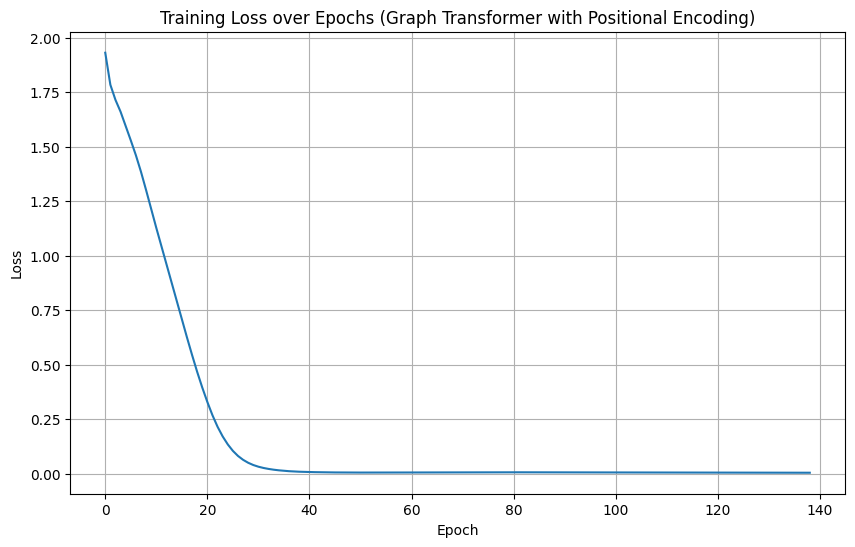

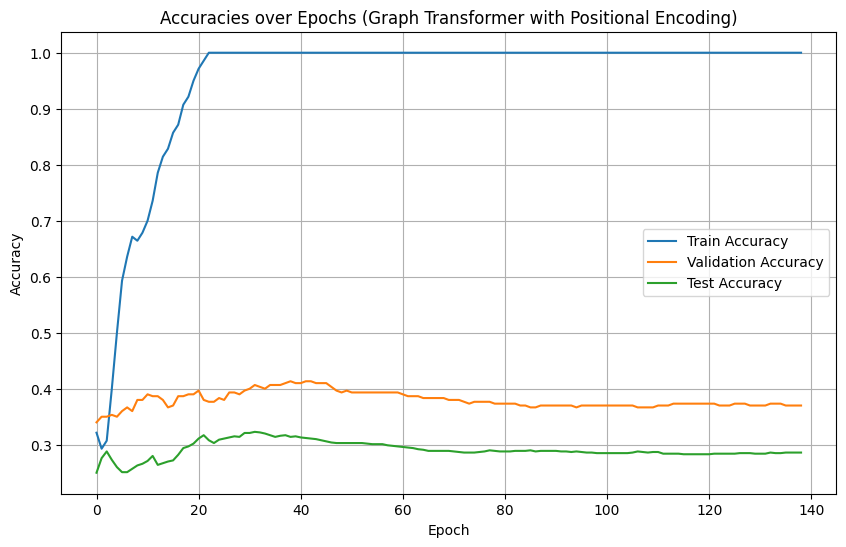

Examples of correct classifications on the test data (Graph Transformer with Positional Encoding):
Node Index (in original dataset): 500, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 502, Predicted Class: Rule_Learning, Actual Class: Rule_Learning
Node Index (in original dataset): 507, Predicted Class: Genetic_Algorithms, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 508, Predicted Class: Genetic_Algorithms, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 517, Predicted Class: Genetic_Algorithms, Actual Class: Genetic_Algorithms
Node Index (in original dataset): 526, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 527, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 528, Predicted Class: Case_Based, Actual Class: Case_Based
Node Index (in original dataset): 535, Predicted Class: Genetic_Algorithms, Actual Class: Genetic

In [51]:
#graph trasnsformers with positional encodings
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define a function for positional encoding
def positional_encoding(max_len, d_model):
    # sinusoidal positional encodings
    pe = torch.zeros(max_len, d_model)
    position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe

class GraphTransformerWithPositionalEncoding(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads, dropout_rate, max_nodes):
        super().__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.heads = heads
        self.dropout_rate = dropout_rate
        self.max_nodes = max_nodes # Maximum number of nodes in the graph

        # Ensure input dimension matches the hidden dimension for positional encoding addition
        # We might need a linear layer to project initial features to hidden_channels * heads
        self.feature_projection = Linear(in_channels, hidden_channels * heads)

        # Positional encoding
        self.pe = positional_encoding(max_nodes, hidden_channels * heads)

        self.conv1 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate)
        #self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate)
        #self.conv3 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x, edge_index):
        # Project input features to match the PE dimension
        x = self.feature_projection(x)

        # Add positional encoding
        # Assuming x is ordered according to node indices (0 to N-1)
        # Ensure features have enough nodes for positional encoding lookup
        num_nodes = x.size(0)
        if num_nodes > self.max_nodes:
             raise ValueError(f"Number of nodes ({num_nodes}) exceeds max_nodes ({self.max_nodes})")
        x = x + self.pe[:num_nodes, :].to(x.device) # Add PE, moving PE to the same device as x

        x = self.conv1(x, edge_index)
        x = F.elu(x)

        #x = self.conv2(x, edge_index)
        #x = F.elu(x)

        #x = self.conv3(x, edge_index)
        # Optional: ELU before final linear layer
        # x = F.elu(x)

        x = self.lin(x)
        return x

# Define Graph Transformer model parameters with positional encoding
in_channels_trans_pe = features.shape[1]
hidden_channels_trans_pe = 8 # Similar to GAT hidden dimension per head
out_channels_trans_pe = labels.max().item() + 1
heads_trans_pe = 8 # Number of attention heads
dropout_rate_trans_pe = 0 # Dropout rate
max_nodes_cora = features.shape[0] # Number of nodes in the Cora dataset

graph_transformer_pe = GraphTransformerWithPositionalEncoding(
    in_channels_trans_pe,
    hidden_channels_trans_pe,
    out_channels_trans_pe,
    heads_trans_pe,
    dropout_rate_trans_pe,
    max_nodes_cora # Pass the maximum number of nodes (total nodes in the dataset)
)

print("\nGraph Transformer with Positional Encoding Architecture:")
print(graph_transformer_pe)
print('Number of parameters Graph Transformer with Positional Encoding: ', num_params(graph_transformer_pe))


# Define optimizer for Graph Transformer with Positional Encoding
weight_decay_value_trans_pe = 5e-4 # Common weight decay value
opt_trans_pe = optim.Adam(graph_transformer_pe.parameters(), lr=0.005, weight_decay=weight_decay_value_trans_pe)

edge_index = adj._indices()

# Training loop for Graph Transformer with Positional Encoding
losses_trans_pe = []
train_accuracies_trans_pe = []
val_accuracies_trans_pe = []
test_accuracies_trans_pe = []

best_val_acc_trans_pe = 0
best_test_acc_trans_pe = 0
epochs_no_improve_trans_pe = 0
patience_trans_pe = 100 # Number of epochs to wait for improvement before stopping

print("\n--- Training Graph Transformer with Positional Encoding ---")
for epoch in trange(1000):
    graph_transformer_pe.train() # Set model to training mode
    opt_trans_pe.zero_grad()
    output_trans_pe = graph_transformer_pe(features, edge_index)
    loss_trans_pe = F.cross_entropy(output_trans_pe[idx_train], labels[idx_train])

    loss_trans_pe.backward()
    opt_trans_pe.step()

    losses_trans_pe.append(loss_trans_pe.item())

    # Use the same accuracy computation function as GAT since the output format is similar
    train_acc_trans_pe = compute_accuracy_gat(graph_transformer_pe, features, edge_index, labels, idx_train)
    val_acc_trans_pe = compute_accuracy_gat(graph_transformer_pe, features, edge_index, labels, idx_val)
    test_acc_trans_pe = compute_accuracy_gat(graph_transformer_pe, features, edge_index, labels, idx_test)

    train_accuracies_trans_pe.append(train_acc_trans_pe.item())
    val_accuracies_trans_pe.append(val_acc_trans_pe.item())
    test_accuracies_trans_pe.append(test_acc_trans_pe.item())

    # Check for early stopping
    if val_acc_trans_pe > best_val_acc_trans_pe:
        best_val_acc_trans_pe = val_acc_trans_pe
        best_test_acc_trans_pe = test_acc_trans_pe # Store the test accuracy when validation accuracy improves
        epochs_no_improve_trans_pe = 0
    else:
        epochs_no_improve_trans_pe += 1
        if epochs_no_improve_trans_pe == patience_trans_pe:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Print loss and accuracies for the current epoch
    print(f"Epoch {epoch+1}, Loss: {loss_trans_pe.item():.4f}, Train Acc: {train_acc_trans_pe:.4f}, Val Acc: {val_acc_trans_pe:.4f}, Test Acc: {test_acc_trans_pe:.4f}")

# After the training loop, you can access the lists and the best test accuracy
print(f"\nBest Validation Accuracy (Graph Transformer with Positional Encoding): {best_val_acc_trans_pe:.4f}")
print(f"Test Accuracy at Best Validation (Graph Transformer with Positional Encoding): {best_test_acc_trans_pe:.4f}")


# Plot the loss (Graph Transformer with Positional Encoding)
plt.figure(figsize=(10, 6))
plt.plot(losses_trans_pe)
plt.title('Training Loss over Epochs (Graph Transformer with Positional Encoding)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

# Plot the accuracies (Graph Transformer with Positional Encoding)
plt.figure(figsize=(10, 6))
plt.plot(train_accuracies_trans_pe, label='Train Accuracy')
plt.plot(val_accuracies_trans_pe, label='Validation Accuracy')
plt.plot(test_accuracies_trans_pe, label='Test Accuracy')
plt.title('Accuracies over Epochs (Graph Transformer with Positional Encoding)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Visualization of classification results (Graph Transformer with Positional Encoding)
graph_transformer_pe.eval()
output_trans_pe = graph_transformer_pe(features, edge_index)
test_output_trans_pe = output_trans_pe[idx_test]
test_labels_trans_pe = labels[idx_test]

predicted_labels_trans_pe = test_output_trans_pe.max(1)[1].type_as(test_labels_trans_pe)

correctly_classified_indices_trans_pe = (predicted_labels_trans_pe == test_labels_trans_pe).nonzero(as_tuple=True)[0]
incorrectly_classified_indices_trans_pe = (predicted_labels_trans_pe != test_labels_trans_pe).nonzero(as_tuple=True)[0]

print("Examples of correct classifications on the test data (Graph Transformer with Positional Encoding):")
for i in correctly_classified_indices_trans_pe[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels_trans_pe[i].item()
    actual_class_index = test_labels_trans_pe[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


print("\nExamples of incorrect classifications on the test data (Graph Transformer with Positional Encoding):")
for i in incorrectly_classified_indices_trans_pe[:10]: # Display up to 10 examples
    node_index_in_test_set = i.item()
    actual_node_index = idx_test[node_index_in_test_set].item()

    predicted_class_index = predicted_labels_trans_pe[i].item()
    actual_class_index = test_labels_trans_pe[i].item()

    predicted_class_name = classes[predicted_class_index]
    actual_class_name = classes[actual_class_index]

    print(f"Node Index (in original dataset): {actual_node_index}, Predicted Class: {predicted_class_name}, Actual Class: {actual_class_name}")


# Visualization of classification results (Graph Transformer with Positional Encoding)
correct_count_trans_pe = len(correctly_classified_indices_trans_pe)
incorrect_count_trans_pe = len(incorrectly_classified_indices_trans_pe)
total_test_samples_trans_pe = len(test_labels_trans_pe)

print(f"\nTotal test samples (Graph Transformer with Positional Encoding): {total_test_samples_trans_pe}")
print(f"Correctly classified (Graph Transformer with Positional Encoding): {correct_count_trans_pe}")
print(f"Incorrectly classified (Graph Transformer with Positional Encoding): {incorrect_count_trans_pe}")


##degree positional encoding

In [50]:
import torch
import math
from torch_geometric.utils import degree
from torch_geometric.nn import TransformerConv
from torch.nn import Linear
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import trange

# Define the degree encoding function
def degree_encoding(edge_index, num_nodes, max_degree=None):
    row, col = edge_index
    deg = torch.bincount(row, minlength=num_nodes).float()
    if max_degree is not None:
        deg = torch.clamp(deg, max=max_degree)
    deg = deg.unsqueeze(1)
    return deg

# Graph Transformer without pooling
class GraphTransformerWithDegreePE(torch.nn.Module):
    def __init__(self, in_channels_orig, pe_channels, hidden_channels, out_channels, heads, dropout_rate):
        super().__init__()
        in_channels_total = in_channels_orig + pe_channels

        self.conv1 = TransformerConv(in_channels_total, hidden_channels, heads=heads, dropout=dropout_rate)
        self.conv2 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate)
        self.conv3 = TransformerConv(hidden_channels * heads, hidden_channels, heads=heads, dropout=dropout_rate)
        self.lin = Linear(hidden_channels * heads, out_channels)

    def forward(self, x_orig, edge_index, pe):
        x = torch.cat([x_orig, pe], dim=-1)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.lin(x)
        return x

# Accuracy computation
def compute_accuracy_standard(model, features, edge_index, pe, labels, indices):
    model.eval()
    with torch.no_grad():
        output = model(features, edge_index, pe)
        sliced_output = output[indices]
        sliced_labels = labels[indices]
        preds = sliced_output.max(1)[1].type_as(sliced_labels)
        correct = preds.eq(sliced_labels).double().sum()
        acc = correct / len(sliced_labels)
    return acc

# Assuming features, edge_index, labels, idx_train, idx_val, idx_test are already defined
num_nodes = features.shape[0]
degree_pe = degree_encoding(edge_index, num_nodes=num_nodes)

in_channels_orig = features.shape[1]
pe_channels = degree_pe.shape[1]
hidden_channels = 8
out_channels = labels.max().item() + 1
heads = 8
dropout_rate = 0.6

model = GraphTransformerWithDegreePE(
    in_channels_orig=in_channels_orig,
    pe_channels=pe_channels,
    hidden_channels=hidden_channels,
    out_channels=out_channels,
    heads=heads,
    dropout_rate=dropout_rate
)

print("\nGraph Transformer Architecture (With Degree PE, No Pooling):")
print(model)

# Helper function to count parameters
def num_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Number of parameters Graph Transformer (With Degree PE):', num_params(model))

optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# Training loop
losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []
best_val_acc = 0
best_test_acc = 0
epochs_no_improve = 0
patience = 100

print("\n--- Training Graph Transformer (With Degree PE) ---")
for epoch in trange(1000):
    model.train()
    optimizer.zero_grad()
    output = model(features, edge_index, degree_pe)
    loss = F.cross_entropy(output[idx_train], labels[idx_train])

    if torch.isnan(loss):
        print(f"Epoch {epoch+1}: NaN loss detected, stopping training.")
        break

    loss.backward()
    optimizer.step()

    losses.append(loss.item())

    train_acc = compute_accuracy_standard(model, features, edge_index, degree_pe, labels, idx_train)
    val_acc = compute_accuracy_standard(model, features, edge_index, degree_pe, labels, idx_val)
    test_acc = compute_accuracy_standard(model, features, edge_index, degree_pe, labels, idx_test)

    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())
    test_accuracies.append(test_acc.item())

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

print(f"\nBest Validation Accuracy: {best_val_acc:.4f}")
print(f"Test Accuracy at Best Validation: {best_test_acc:.4f}")



Graph Transformer Architecture (With Degree PE, No Pooling):
GraphTransformerWithDegreePE(
  (conv1): TransformerConv(1434, 8, heads=8)
  (conv2): TransformerConv(64, 8, heads=8)
  (conv3): TransformerConv(64, 8, heads=8)
  (lin): Linear(in_features=64, out_features=7, bias=True)
)
Number of parameters Graph Transformer (With Degree PE): 401095

--- Training Graph Transformer (With Degree PE, No Pooling) ---


  0%|          | 1/1000 [00:01<16:48,  1.01s/it]

Epoch 1, Loss: 1.9742, Train Acc: 0.2929, Val Acc: 0.3367, Test Acc: 0.3010


  0%|          | 2/1000 [00:02<19:42,  1.18s/it]

Epoch 2, Loss: 1.8493, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 3/1000 [00:03<20:55,  1.26s/it]

Epoch 3, Loss: 1.7769, Train Acc: 0.2929, Val Acc: 0.3500, Test Acc: 0.3090


  0%|          | 4/1000 [00:04<17:17,  1.04s/it]

Epoch 4, Loss: 1.7214, Train Acc: 0.3357, Val Acc: 0.3133, Test Acc: 0.2990


  0%|          | 5/1000 [00:05<14:50,  1.12it/s]

Epoch 5, Loss: 1.6300, Train Acc: 0.4429, Val Acc: 0.3800, Test Acc: 0.3720


  1%|          | 6/1000 [00:05<15:21,  1.08it/s]

Epoch 6, Loss: 1.6239, Train Acc: 0.4286, Val Acc: 0.3567, Test Acc: 0.3200


  1%|          | 7/1000 [00:06<15:00,  1.10it/s]

Epoch 7, Loss: 1.5744, Train Acc: 0.4143, Val Acc: 0.3400, Test Acc: 0.2850


  1%|          | 8/1000 [00:07<13:37,  1.21it/s]

Epoch 8, Loss: 1.5328, Train Acc: 0.4571, Val Acc: 0.3700, Test Acc: 0.3410


  1%|          | 9/1000 [00:08<12:32,  1.32it/s]

Epoch 9, Loss: 1.4884, Train Acc: 0.4857, Val Acc: 0.4000, Test Acc: 0.3660


  1%|          | 10/1000 [00:08<11:54,  1.39it/s]

Epoch 10, Loss: 1.3391, Train Acc: 0.5000, Val Acc: 0.4133, Test Acc: 0.3860


  1%|          | 11/1000 [00:09<10:35,  1.56it/s]

Epoch 11, Loss: 1.4515, Train Acc: 0.4500, Val Acc: 0.3533, Test Acc: 0.2770


  1%|          | 12/1000 [00:09<09:33,  1.72it/s]

Epoch 12, Loss: 1.4321, Train Acc: 0.4000, Val Acc: 0.3267, Test Acc: 0.2420


  1%|▏         | 13/1000 [00:10<08:38,  1.90it/s]

Epoch 13, Loss: 1.3580, Train Acc: 0.4143, Val Acc: 0.3267, Test Acc: 0.2510


  1%|▏         | 14/1000 [00:10<08:03,  2.04it/s]

Epoch 14, Loss: 1.3280, Train Acc: 0.4357, Val Acc: 0.3967, Test Acc: 0.3040


  2%|▏         | 15/1000 [00:10<07:38,  2.15it/s]

Epoch 15, Loss: 1.2444, Train Acc: 0.5143, Val Acc: 0.4400, Test Acc: 0.3420


  2%|▏         | 16/1000 [00:11<07:18,  2.24it/s]

Epoch 16, Loss: 1.2445, Train Acc: 0.5286, Val Acc: 0.4767, Test Acc: 0.3760


  2%|▏         | 17/1000 [00:11<07:07,  2.30it/s]

Epoch 17, Loss: 1.2522, Train Acc: 0.5643, Val Acc: 0.4467, Test Acc: 0.3480


  2%|▏         | 18/1000 [00:12<07:00,  2.34it/s]

Epoch 18, Loss: 1.1172, Train Acc: 0.5000, Val Acc: 0.4033, Test Acc: 0.3070


  2%|▏         | 19/1000 [00:12<07:00,  2.33it/s]

Epoch 19, Loss: 1.0729, Train Acc: 0.5643, Val Acc: 0.4367, Test Acc: 0.3630


  2%|▏         | 20/1000 [00:12<06:57,  2.35it/s]

Epoch 20, Loss: 0.9927, Train Acc: 0.5857, Val Acc: 0.4700, Test Acc: 0.4230


  2%|▏         | 21/1000 [00:13<06:52,  2.37it/s]

Epoch 21, Loss: 1.0005, Train Acc: 0.7643, Val Acc: 0.5900, Test Acc: 0.5110


  2%|▏         | 22/1000 [00:13<06:49,  2.39it/s]

Epoch 22, Loss: 0.8985, Train Acc: 0.7286, Val Acc: 0.5733, Test Acc: 0.4220


  2%|▏         | 23/1000 [00:14<06:48,  2.39it/s]

Epoch 23, Loss: 0.8384, Train Acc: 0.8071, Val Acc: 0.6433, Test Acc: 0.5120


  2%|▏         | 24/1000 [00:14<06:45,  2.41it/s]

Epoch 24, Loss: 0.7410, Train Acc: 0.6000, Val Acc: 0.4567, Test Acc: 0.4070


  2%|▎         | 25/1000 [00:15<06:46,  2.40it/s]

Epoch 25, Loss: 0.7622, Train Acc: 0.6429, Val Acc: 0.5133, Test Acc: 0.4710


  3%|▎         | 26/1000 [00:15<06:44,  2.41it/s]

Epoch 26, Loss: 0.6763, Train Acc: 0.8214, Val Acc: 0.6733, Test Acc: 0.5370


  3%|▎         | 27/1000 [00:15<07:23,  2.19it/s]

Epoch 27, Loss: 0.7091, Train Acc: 0.8286, Val Acc: 0.6433, Test Acc: 0.5150


  3%|▎         | 28/1000 [00:16<09:02,  1.79it/s]

Epoch 28, Loss: 0.6430, Train Acc: 0.8286, Val Acc: 0.6533, Test Acc: 0.5640


  3%|▎         | 29/1000 [00:17<10:07,  1.60it/s]

Epoch 29, Loss: 0.4790, Train Acc: 0.7714, Val Acc: 0.6167, Test Acc: 0.5420


  3%|▎         | 30/1000 [00:18<11:11,  1.44it/s]

Epoch 30, Loss: 0.4831, Train Acc: 0.7714, Val Acc: 0.6200, Test Acc: 0.5490


  3%|▎         | 31/1000 [00:19<13:19,  1.21it/s]

Epoch 31, Loss: 0.4019, Train Acc: 0.8500, Val Acc: 0.6467, Test Acc: 0.5370


  3%|▎         | 32/1000 [00:21<18:38,  1.16s/it]

Epoch 32, Loss: 0.3669, Train Acc: 0.8714, Val Acc: 0.6700, Test Acc: 0.5420


  3%|▎         | 33/1000 [00:22<18:40,  1.16s/it]

Epoch 33, Loss: 0.3210, Train Acc: 0.9000, Val Acc: 0.7067, Test Acc: 0.6020


  3%|▎         | 34/1000 [00:23<17:08,  1.06s/it]

Epoch 34, Loss: 0.2735, Train Acc: 0.9071, Val Acc: 0.7167, Test Acc: 0.6330


  4%|▎         | 35/1000 [00:24<16:41,  1.04s/it]

Epoch 35, Loss: 0.3085, Train Acc: 0.9143, Val Acc: 0.7100, Test Acc: 0.6220


  4%|▎         | 36/1000 [00:25<16:23,  1.02s/it]

Epoch 36, Loss: 0.2825, Train Acc: 0.8929, Val Acc: 0.6667, Test Acc: 0.5450


  4%|▎         | 37/1000 [00:26<15:14,  1.05it/s]

Epoch 37, Loss: 0.2273, Train Acc: 0.8643, Val Acc: 0.6567, Test Acc: 0.5370


  4%|▍         | 38/1000 [00:27<15:10,  1.06it/s]

Epoch 38, Loss: 0.1977, Train Acc: 0.9000, Val Acc: 0.6600, Test Acc: 0.5630


  4%|▍         | 39/1000 [00:28<15:14,  1.05it/s]

Epoch 39, Loss: 0.1836, Train Acc: 0.9143, Val Acc: 0.6733, Test Acc: 0.5570


  4%|▍         | 40/1000 [00:28<14:13,  1.12it/s]

Epoch 40, Loss: 0.1923, Train Acc: 0.9143, Val Acc: 0.6867, Test Acc: 0.5720


  4%|▍         | 41/1000 [00:29<13:00,  1.23it/s]

Epoch 41, Loss: 0.1622, Train Acc: 0.9143, Val Acc: 0.6767, Test Acc: 0.5490


  4%|▍         | 42/1000 [00:30<12:51,  1.24it/s]

Epoch 42, Loss: 0.1778, Train Acc: 0.9071, Val Acc: 0.6967, Test Acc: 0.5590


  4%|▍         | 43/1000 [00:31<12:51,  1.24it/s]

Epoch 43, Loss: 0.1257, Train Acc: 0.9214, Val Acc: 0.6533, Test Acc: 0.5680


  4%|▍         | 44/1000 [00:31<12:40,  1.26it/s]

Epoch 44, Loss: 0.1314, Train Acc: 0.9286, Val Acc: 0.6667, Test Acc: 0.5710


  4%|▍         | 45/1000 [00:33<14:18,  1.11it/s]

Epoch 45, Loss: 0.1727, Train Acc: 0.9500, Val Acc: 0.6933, Test Acc: 0.5780


  5%|▍         | 46/1000 [00:34<15:54,  1.00s/it]

Epoch 46, Loss: 0.0783, Train Acc: 0.9500, Val Acc: 0.6500, Test Acc: 0.5310


  5%|▍         | 47/1000 [00:35<17:28,  1.10s/it]

Epoch 47, Loss: 0.1116, Train Acc: 0.9357, Val Acc: 0.6400, Test Acc: 0.5200


  5%|▍         | 48/1000 [00:36<15:51,  1.00it/s]

Epoch 48, Loss: 0.0998, Train Acc: 0.9357, Val Acc: 0.6567, Test Acc: 0.5670


  5%|▍         | 49/1000 [00:36<13:58,  1.13it/s]

Epoch 49, Loss: 0.0715, Train Acc: 0.9357, Val Acc: 0.6933, Test Acc: 0.5900


  5%|▌         | 50/1000 [00:37<12:50,  1.23it/s]

Epoch 50, Loss: 0.0573, Train Acc: 0.9500, Val Acc: 0.6867, Test Acc: 0.6010


  5%|▌         | 51/1000 [00:38<12:42,  1.24it/s]

Epoch 51, Loss: 0.0520, Train Acc: 0.9643, Val Acc: 0.6800, Test Acc: 0.6010


  5%|▌         | 52/1000 [00:38<11:09,  1.42it/s]

Epoch 52, Loss: 0.0670, Train Acc: 0.9643, Val Acc: 0.6800, Test Acc: 0.6060


  5%|▌         | 53/1000 [00:39<09:48,  1.61it/s]

Epoch 53, Loss: 0.0576, Train Acc: 0.9643, Val Acc: 0.6767, Test Acc: 0.6190


  5%|▌         | 54/1000 [00:39<08:48,  1.79it/s]

Epoch 54, Loss: 0.0555, Train Acc: 0.9643, Val Acc: 0.6767, Test Acc: 0.6030


  6%|▌         | 55/1000 [00:40<08:02,  1.96it/s]

Epoch 55, Loss: 0.0431, Train Acc: 0.9500, Val Acc: 0.6600, Test Acc: 0.5810


  6%|▌         | 56/1000 [00:40<07:39,  2.05it/s]

Epoch 56, Loss: 0.0528, Train Acc: 0.9500, Val Acc: 0.6467, Test Acc: 0.5590


  6%|▌         | 57/1000 [00:40<07:15,  2.16it/s]

Epoch 57, Loss: 0.0391, Train Acc: 0.9500, Val Acc: 0.6467, Test Acc: 0.5580


  6%|▌         | 58/1000 [00:41<07:01,  2.23it/s]

Epoch 58, Loss: 0.0420, Train Acc: 0.9643, Val Acc: 0.6600, Test Acc: 0.5790


  6%|▌         | 59/1000 [00:41<06:53,  2.27it/s]

Epoch 59, Loss: 0.0374, Train Acc: 0.9643, Val Acc: 0.6733, Test Acc: 0.5900


  6%|▌         | 60/1000 [00:42<06:43,  2.33it/s]

Epoch 60, Loss: 0.0274, Train Acc: 0.9857, Val Acc: 0.6800, Test Acc: 0.6020


  6%|▌         | 61/1000 [00:42<06:50,  2.29it/s]

Epoch 61, Loss: 0.0214, Train Acc: 0.9857, Val Acc: 0.6800, Test Acc: 0.6280


  6%|▌         | 62/1000 [00:43<06:43,  2.33it/s]

Epoch 62, Loss: 0.0189, Train Acc: 0.9857, Val Acc: 0.6867, Test Acc: 0.6210


  6%|▋         | 63/1000 [00:43<06:43,  2.32it/s]

Epoch 63, Loss: 0.0253, Train Acc: 0.9857, Val Acc: 0.7100, Test Acc: 0.6110


  6%|▋         | 64/1000 [00:43<06:37,  2.35it/s]

Epoch 64, Loss: 0.0140, Train Acc: 0.9857, Val Acc: 0.6967, Test Acc: 0.6130


  6%|▋         | 65/1000 [00:44<06:33,  2.37it/s]

Epoch 65, Loss: 0.0325, Train Acc: 0.9857, Val Acc: 0.6867, Test Acc: 0.5950


  7%|▋         | 66/1000 [00:44<06:36,  2.35it/s]

Epoch 66, Loss: 0.0195, Train Acc: 0.9857, Val Acc: 0.6800, Test Acc: 0.5970


  7%|▋         | 67/1000 [00:45<06:34,  2.36it/s]

Epoch 67, Loss: 0.0268, Train Acc: 0.9857, Val Acc: 0.6867, Test Acc: 0.6130


  7%|▋         | 68/1000 [00:45<06:39,  2.34it/s]

Epoch 68, Loss: 0.0267, Train Acc: 0.9857, Val Acc: 0.6767, Test Acc: 0.5970


  7%|▋         | 69/1000 [00:46<07:13,  2.15it/s]

Epoch 69, Loss: 0.0204, Train Acc: 0.9786, Val Acc: 0.6700, Test Acc: 0.5880


  7%|▋         | 70/1000 [00:46<08:03,  1.93it/s]

Epoch 70, Loss: 0.0160, Train Acc: 0.9571, Val Acc: 0.6767, Test Acc: 0.5770


  7%|▋         | 71/1000 [00:47<10:26,  1.48it/s]

Epoch 71, Loss: 0.0156, Train Acc: 0.9500, Val Acc: 0.6667, Test Acc: 0.5860


  7%|▋         | 72/1000 [00:48<11:50,  1.31it/s]

Epoch 72, Loss: 0.0301, Train Acc: 0.9571, Val Acc: 0.6733, Test Acc: 0.5900


  7%|▋         | 73/1000 [00:49<11:40,  1.32it/s]

Epoch 73, Loss: 0.0164, Train Acc: 0.9857, Val Acc: 0.7000, Test Acc: 0.6170


  7%|▋         | 74/1000 [00:50<11:29,  1.34it/s]

Epoch 74, Loss: 0.0212, Train Acc: 0.9857, Val Acc: 0.6967, Test Acc: 0.6340


  8%|▊         | 75/1000 [00:50<11:00,  1.40it/s]

Epoch 75, Loss: 0.0188, Train Acc: 0.9857, Val Acc: 0.7000, Test Acc: 0.6390


  8%|▊         | 76/1000 [00:51<10:53,  1.41it/s]

Epoch 76, Loss: 0.0263, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.6670


  8%|▊         | 77/1000 [00:52<09:34,  1.61it/s]

Epoch 77, Loss: 0.0193, Train Acc: 1.0000, Val Acc: 0.6867, Test Acc: 0.6340


  8%|▊         | 78/1000 [00:52<08:38,  1.78it/s]

Epoch 78, Loss: 0.0234, Train Acc: 1.0000, Val Acc: 0.6800, Test Acc: 0.6420


  8%|▊         | 79/1000 [00:52<07:54,  1.94it/s]

Epoch 79, Loss: 0.0238, Train Acc: 1.0000, Val Acc: 0.6967, Test Acc: 0.6420


  8%|▊         | 80/1000 [00:53<07:28,  2.05it/s]

Epoch 80, Loss: 0.0238, Train Acc: 1.0000, Val Acc: 0.6933, Test Acc: 0.6370


  8%|▊         | 81/1000 [00:53<07:08,  2.14it/s]

Epoch 81, Loss: 0.0204, Train Acc: 1.0000, Val Acc: 0.7033, Test Acc: 0.6500


  8%|▊         | 82/1000 [00:54<06:55,  2.21it/s]

Epoch 82, Loss: 0.0254, Train Acc: 1.0000, Val Acc: 0.7033, Test Acc: 0.6830


  8%|▊         | 83/1000 [00:54<06:43,  2.28it/s]

Epoch 83, Loss: 0.0199, Train Acc: 1.0000, Val Acc: 0.6833, Test Acc: 0.6450


  8%|▊         | 84/1000 [00:54<06:33,  2.33it/s]

Epoch 84, Loss: 0.0124, Train Acc: 1.0000, Val Acc: 0.6333, Test Acc: 0.5850


  8%|▊         | 85/1000 [00:55<06:32,  2.33it/s]

Epoch 85, Loss: 0.0198, Train Acc: 0.9786, Val Acc: 0.6200, Test Acc: 0.5640


  9%|▊         | 86/1000 [00:55<06:27,  2.36it/s]

Epoch 86, Loss: 0.0230, Train Acc: 0.9786, Val Acc: 0.6667, Test Acc: 0.6200


  9%|▊         | 87/1000 [00:56<06:25,  2.37it/s]

Epoch 87, Loss: 0.0248, Train Acc: 0.9786, Val Acc: 0.6800, Test Acc: 0.6380


  9%|▉         | 88/1000 [00:56<06:58,  2.18it/s]

Epoch 88, Loss: 0.0222, Train Acc: 0.9643, Val Acc: 0.6767, Test Acc: 0.6280


  9%|▉         | 89/1000 [00:57<07:03,  2.15it/s]

Epoch 89, Loss: 0.0194, Train Acc: 0.9643, Val Acc: 0.6800, Test Acc: 0.6120


  9%|▉         | 90/1000 [00:57<07:33,  2.01it/s]

Epoch 90, Loss: 0.0262, Train Acc: 0.9571, Val Acc: 0.6767, Test Acc: 0.6230


  9%|▉         | 91/1000 [00:58<08:11,  1.85it/s]

Epoch 91, Loss: 0.0234, Train Acc: 0.9500, Val Acc: 0.6600, Test Acc: 0.6140


  9%|▉         | 92/1000 [00:59<08:53,  1.70it/s]

Epoch 92, Loss: 0.0275, Train Acc: 0.9643, Val Acc: 0.6633, Test Acc: 0.5870


  9%|▉         | 93/1000 [01:01<18:37,  1.23s/it]

Epoch 93, Loss: 0.0225, Train Acc: 0.9857, Val Acc: 0.6567, Test Acc: 0.5760


  9%|▉         | 94/1000 [01:03<20:19,  1.35s/it]

Epoch 94, Loss: 0.0376, Train Acc: 0.9857, Val Acc: 0.6800, Test Acc: 0.6330


 10%|▉         | 95/1000 [01:04<18:46,  1.24s/it]

Epoch 95, Loss: 0.0349, Train Acc: 0.9857, Val Acc: 0.6800, Test Acc: 0.6340


 10%|▉         | 96/1000 [01:05<16:28,  1.09s/it]

Epoch 96, Loss: 0.0179, Train Acc: 0.9929, Val Acc: 0.5967, Test Acc: 0.5400


 10%|▉         | 97/1000 [01:06<15:26,  1.03s/it]

Epoch 97, Loss: 0.0274, Train Acc: 1.0000, Val Acc: 0.6333, Test Acc: 0.5890


 10%|▉         | 98/1000 [01:06<13:26,  1.12it/s]

Epoch 98, Loss: 0.0206, Train Acc: 0.9857, Val Acc: 0.6800, Test Acc: 0.6210


 10%|▉         | 99/1000 [01:07<11:16,  1.33it/s]

Epoch 99, Loss: 0.0132, Train Acc: 0.9857, Val Acc: 0.7000, Test Acc: 0.6310


 10%|█         | 100/1000 [01:07<09:45,  1.54it/s]

Epoch 100, Loss: 0.0325, Train Acc: 1.0000, Val Acc: 0.7067, Test Acc: 0.6180


 10%|█         | 101/1000 [01:07<08:42,  1.72it/s]

Epoch 101, Loss: 0.0135, Train Acc: 0.9857, Val Acc: 0.6467, Test Acc: 0.5380


 10%|█         | 102/1000 [01:08<07:53,  1.90it/s]

Epoch 102, Loss: 0.0658, Train Acc: 0.9500, Val Acc: 0.6567, Test Acc: 0.6260


 10%|█         | 103/1000 [01:08<07:21,  2.03it/s]

Epoch 103, Loss: 0.0498, Train Acc: 0.9857, Val Acc: 0.6667, Test Acc: 0.5960


 10%|█         | 104/1000 [01:09<07:01,  2.12it/s]

Epoch 104, Loss: 0.0269, Train Acc: 0.9714, Val Acc: 0.5733, Test Acc: 0.4950


 10%|█         | 105/1000 [01:09<06:44,  2.21it/s]

Epoch 105, Loss: 0.0410, Train Acc: 1.0000, Val Acc: 0.6433, Test Acc: 0.5650


 11%|█         | 106/1000 [01:09<06:35,  2.26it/s]

Epoch 106, Loss: 0.0193, Train Acc: 0.9857, Val Acc: 0.6733, Test Acc: 0.6270


 11%|█         | 107/1000 [01:10<06:24,  2.32it/s]

Epoch 107, Loss: 0.0566, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6510


 11%|█         | 108/1000 [01:10<06:19,  2.35it/s]

Epoch 108, Loss: 0.0210, Train Acc: 0.9857, Val Acc: 0.5700, Test Acc: 0.5090


 11%|█         | 109/1000 [01:11<06:15,  2.37it/s]

Epoch 109, Loss: 0.1608, Train Acc: 0.9071, Val Acc: 0.5467, Test Acc: 0.5210


 11%|█         | 110/1000 [01:11<06:11,  2.39it/s]

Epoch 110, Loss: 0.1266, Train Acc: 0.9000, Val Acc: 0.6133, Test Acc: 0.5940


 11%|█         | 111/1000 [01:12<06:14,  2.37it/s]

Epoch 111, Loss: 0.1877, Train Acc: 0.9857, Val Acc: 0.6267, Test Acc: 0.5650


 11%|█         | 112/1000 [01:12<06:24,  2.31it/s]

Epoch 112, Loss: 0.0242, Train Acc: 0.9071, Val Acc: 0.4833, Test Acc: 0.4330


 11%|█▏        | 113/1000 [01:13<07:14,  2.04it/s]

Epoch 113, Loss: 0.3350, Train Acc: 0.9714, Val Acc: 0.6600, Test Acc: 0.5920


 11%|█▏        | 114/1000 [01:13<07:52,  1.87it/s]

Epoch 114, Loss: 0.1305, Train Acc: 0.8286, Val Acc: 0.5533, Test Acc: 0.4830


 12%|█▏        | 115/1000 [01:14<08:19,  1.77it/s]

Epoch 115, Loss: 0.3218, Train Acc: 0.7786, Val Acc: 0.3533, Test Acc: 0.3660


 12%|█▏        | 116/1000 [01:15<08:43,  1.69it/s]

Epoch 116, Loss: 0.5790, Train Acc: 0.8786, Val Acc: 0.5800, Test Acc: 0.5370


 12%|█▏        | 117/1000 [01:15<08:41,  1.69it/s]

Epoch 117, Loss: 0.2597, Train Acc: 0.7857, Val Acc: 0.5500, Test Acc: 0.5040


 12%|█▏        | 118/1000 [01:16<07:55,  1.86it/s]

Epoch 118, Loss: 0.5127, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.7010


 12%|█▏        | 119/1000 [01:16<07:23,  1.99it/s]

Epoch 119, Loss: 0.0282, Train Acc: 0.7000, Val Acc: 0.4600, Test Acc: 0.4490


 12%|█▏        | 120/1000 [01:16<06:58,  2.10it/s]

Epoch 120, Loss: 1.4518, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7030


 12%|█▏        | 121/1000 [01:17<06:44,  2.17it/s]

Epoch 121, Loss: 0.0161, Train Acc: 0.9071, Val Acc: 0.6100, Test Acc: 0.5450


 12%|█▏        | 122/1000 [01:17<06:32,  2.24it/s]

Epoch 122, Loss: 0.3598, Train Acc: 0.7929, Val Acc: 0.5500, Test Acc: 0.5040


 12%|█▏        | 123/1000 [01:18<06:20,  2.31it/s]

Epoch 123, Loss: 0.6311, Train Acc: 0.8357, Val Acc: 0.6033, Test Acc: 0.5290


 12%|█▏        | 124/1000 [01:18<06:18,  2.31it/s]

Epoch 124, Loss: 0.2966, Train Acc: 0.9357, Val Acc: 0.6000, Test Acc: 0.5030


 12%|█▎        | 125/1000 [01:18<06:13,  2.34it/s]

Epoch 125, Loss: 0.0729, Train Acc: 0.9214, Val Acc: 0.5033, Test Acc: 0.4440


 13%|█▎        | 126/1000 [01:19<06:12,  2.35it/s]

Epoch 126, Loss: 0.0713, Train Acc: 0.9071, Val Acc: 0.4600, Test Acc: 0.3960


 13%|█▎        | 127/1000 [01:19<06:06,  2.38it/s]

Epoch 127, Loss: 0.1798, Train Acc: 0.9571, Val Acc: 0.5233, Test Acc: 0.4430


 13%|█▎        | 128/1000 [01:20<06:02,  2.40it/s]

Epoch 128, Loss: 0.0833, Train Acc: 0.9714, Val Acc: 0.6400, Test Acc: 0.5420


 13%|█▎        | 129/1000 [01:20<06:05,  2.38it/s]

Epoch 129, Loss: 0.0808, Train Acc: 0.9857, Val Acc: 0.7000, Test Acc: 0.6080


 13%|█▎        | 130/1000 [01:21<06:01,  2.41it/s]

Epoch 130, Loss: 0.0304, Train Acc: 0.9857, Val Acc: 0.7033, Test Acc: 0.6430


 13%|█▎        | 131/1000 [01:21<06:06,  2.37it/s]

Epoch 131, Loss: 0.0334, Train Acc: 0.9786, Val Acc: 0.6800, Test Acc: 0.6440


 13%|█▎        | 132/1000 [01:21<06:02,  2.39it/s]

Epoch 132, Loss: 0.1434, Train Acc: 0.9929, Val Acc: 0.6900, Test Acc: 0.6540


 13%|█▎        | 133/1000 [01:22<06:00,  2.41it/s]

Epoch 133, Loss: 0.0952, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.6620


 13%|█▎        | 134/1000 [01:22<06:04,  2.37it/s]

Epoch 134, Loss: 0.0089, Train Acc: 0.9929, Val Acc: 0.7167, Test Acc: 0.6580


 14%|█▎        | 135/1000 [01:23<06:01,  2.39it/s]

Epoch 135, Loss: 0.0038, Train Acc: 0.9786, Val Acc: 0.7067, Test Acc: 0.6360


 14%|█▎        | 136/1000 [01:23<06:03,  2.38it/s]

Epoch 136, Loss: 0.0162, Train Acc: 0.9643, Val Acc: 0.7100, Test Acc: 0.6190


 14%|█▎        | 137/1000 [01:23<05:58,  2.41it/s]

Epoch 137, Loss: 0.0087, Train Acc: 0.9571, Val Acc: 0.6833, Test Acc: 0.5970


 14%|█▍        | 138/1000 [01:24<05:55,  2.42it/s]

Epoch 138, Loss: 0.0043, Train Acc: 0.9429, Val Acc: 0.6767, Test Acc: 0.5780


 14%|█▍        | 139/1000 [01:24<06:00,  2.39it/s]

Epoch 139, Loss: 0.0092, Train Acc: 0.9429, Val Acc: 0.6500, Test Acc: 0.5530


 14%|█▍        | 140/1000 [01:25<05:57,  2.41it/s]

Epoch 140, Loss: 0.0091, Train Acc: 0.9429, Val Acc: 0.6333, Test Acc: 0.5440


 14%|█▍        | 141/1000 [01:25<06:17,  2.28it/s]

Epoch 141, Loss: 0.0131, Train Acc: 0.9357, Val Acc: 0.6300, Test Acc: 0.5350


 14%|█▍        | 142/1000 [01:26<07:06,  2.01it/s]

Epoch 142, Loss: 0.0199, Train Acc: 0.9429, Val Acc: 0.6267, Test Acc: 0.5420


 14%|█▍        | 143/1000 [01:26<07:41,  1.86it/s]

Epoch 143, Loss: 0.0266, Train Acc: 0.9500, Val Acc: 0.6400, Test Acc: 0.5540


 14%|█▍        | 144/1000 [01:27<08:04,  1.77it/s]

Epoch 144, Loss: 0.0130, Train Acc: 0.9643, Val Acc: 0.6567, Test Acc: 0.5740


 14%|█▍        | 145/1000 [01:28<08:22,  1.70it/s]

Epoch 145, Loss: 0.0134, Train Acc: 0.9786, Val Acc: 0.6700, Test Acc: 0.5890


 15%|█▍        | 146/1000 [01:28<07:55,  1.80it/s]

Epoch 146, Loss: 0.0099, Train Acc: 0.9857, Val Acc: 0.6900, Test Acc: 0.6110


 15%|█▍        | 147/1000 [01:29<07:19,  1.94it/s]

Epoch 147, Loss: 0.0049, Train Acc: 0.9857, Val Acc: 0.7000, Test Acc: 0.6330


 15%|█▍        | 148/1000 [01:29<06:54,  2.06it/s]

Epoch 148, Loss: 0.0052, Train Acc: 0.9857, Val Acc: 0.7067, Test Acc: 0.6490


 15%|█▍        | 149/1000 [01:30<06:39,  2.13it/s]

Epoch 149, Loss: 0.0308, Train Acc: 0.9929, Val Acc: 0.7233, Test Acc: 0.6800


 15%|█▌        | 150/1000 [01:30<06:23,  2.22it/s]

Epoch 150, Loss: 0.0070, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.6960


 15%|█▌        | 151/1000 [01:30<06:10,  2.29it/s]

Epoch 151, Loss: 0.0121, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7090


 15%|█▌        | 152/1000 [01:31<06:05,  2.32it/s]

Epoch 152, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7160


 15%|█▌        | 153/1000 [01:31<05:58,  2.36it/s]

Epoch 153, Loss: 0.0061, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7180


 15%|█▌        | 154/1000 [01:32<05:55,  2.38it/s]

Epoch 154, Loss: 0.0146, Train Acc: 1.0000, Val Acc: 0.7633, Test Acc: 0.7210


 16%|█▌        | 155/1000 [01:32<05:51,  2.40it/s]

Epoch 155, Loss: 0.0138, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7150


 16%|█▌        | 156/1000 [01:32<05:48,  2.42it/s]

Epoch 156, Loss: 0.0033, Train Acc: 1.0000, Val Acc: 0.7567, Test Acc: 0.7080


 16%|█▌        | 157/1000 [01:33<05:50,  2.40it/s]

Epoch 157, Loss: 0.0328, Train Acc: 1.0000, Val Acc: 0.7500, Test Acc: 0.6880


 16%|█▌        | 158/1000 [01:33<05:47,  2.42it/s]

Epoch 158, Loss: 0.0037, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.6740


 16%|█▌        | 159/1000 [01:34<05:47,  2.42it/s]

Epoch 159, Loss: 0.0034, Train Acc: 1.0000, Val Acc: 0.7433, Test Acc: 0.6440


 16%|█▌        | 160/1000 [01:34<05:46,  2.42it/s]

Epoch 160, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6320


 16%|█▌        | 161/1000 [01:34<05:45,  2.43it/s]

Epoch 161, Loss: 0.0041, Train Acc: 0.9929, Val Acc: 0.7233, Test Acc: 0.6160


 16%|█▌        | 162/1000 [01:35<05:47,  2.41it/s]

Epoch 162, Loss: 0.0042, Train Acc: 0.9929, Val Acc: 0.7100, Test Acc: 0.6100


 16%|█▋        | 163/1000 [01:35<05:46,  2.42it/s]

Epoch 163, Loss: 0.0082, Train Acc: 0.9857, Val Acc: 0.7133, Test Acc: 0.6060


 16%|█▋        | 164/1000 [01:36<05:47,  2.41it/s]

Epoch 164, Loss: 0.0053, Train Acc: 0.9857, Val Acc: 0.7033, Test Acc: 0.6040


 16%|█▋        | 165/1000 [01:36<05:46,  2.41it/s]

Epoch 165, Loss: 0.0058, Train Acc: 0.9857, Val Acc: 0.7067, Test Acc: 0.6050


 17%|█▋        | 166/1000 [01:37<05:43,  2.43it/s]

Epoch 166, Loss: 0.0054, Train Acc: 0.9857, Val Acc: 0.7067, Test Acc: 0.6050


 17%|█▋        | 167/1000 [01:37<05:46,  2.40it/s]

Epoch 167, Loss: 0.0049, Train Acc: 0.9857, Val Acc: 0.7133, Test Acc: 0.6060


 17%|█▋        | 168/1000 [01:37<05:47,  2.39it/s]

Epoch 168, Loss: 0.0035, Train Acc: 0.9857, Val Acc: 0.7067, Test Acc: 0.6120


 17%|█▋        | 169/1000 [01:38<05:47,  2.39it/s]

Epoch 169, Loss: 0.0053, Train Acc: 0.9929, Val Acc: 0.7100, Test Acc: 0.6140


 17%|█▋        | 170/1000 [01:38<06:13,  2.22it/s]

Epoch 170, Loss: 0.0126, Train Acc: 0.9929, Val Acc: 0.7233, Test Acc: 0.6280


 17%|█▋        | 171/1000 [01:39<06:56,  1.99it/s]

Epoch 171, Loss: 0.0043, Train Acc: 0.9929, Val Acc: 0.7200, Test Acc: 0.6400


 17%|█▋        | 172/1000 [01:40<07:27,  1.85it/s]

Epoch 172, Loss: 0.0035, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6540


 17%|█▋        | 173/1000 [01:40<07:51,  1.76it/s]

Epoch 173, Loss: 0.0090, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6720


 17%|█▋        | 174/1000 [01:41<08:07,  1.69it/s]

Epoch 174, Loss: 0.0038, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.6830


 18%|█▊        | 175/1000 [01:41<07:32,  1.82it/s]

Epoch 175, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.6910


 18%|█▊        | 176/1000 [01:42<06:55,  1.99it/s]

Epoch 176, Loss: 0.0086, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.7010


 18%|█▊        | 177/1000 [01:42<06:44,  2.03it/s]

Epoch 177, Loss: 0.0043, Train Acc: 1.0000, Val Acc: 0.7400, Test Acc: 0.7040


 18%|█▊        | 178/1000 [01:43<06:26,  2.13it/s]

Epoch 178, Loss: 0.0196, Train Acc: 1.0000, Val Acc: 0.7367, Test Acc: 0.6970


 18%|█▊        | 179/1000 [01:43<06:10,  2.21it/s]

Epoch 179, Loss: 0.0051, Train Acc: 1.0000, Val Acc: 0.7333, Test Acc: 0.6890


 18%|█▊        | 180/1000 [01:43<06:06,  2.24it/s]

Epoch 180, Loss: 0.0048, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6810


 18%|█▊        | 181/1000 [01:44<05:59,  2.28it/s]

Epoch 181, Loss: 0.0044, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6770


 18%|█▊        | 182/1000 [01:44<05:58,  2.28it/s]

Epoch 182, Loss: 0.0041, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6700


 18%|█▊        | 183/1000 [01:45<07:24,  1.84it/s]

Epoch 183, Loss: 0.0042, Train Acc: 1.0000, Val Acc: 0.7133, Test Acc: 0.6610


 18%|█▊        | 184/1000 [01:45<06:54,  1.97it/s]

Epoch 184, Loss: 0.0044, Train Acc: 1.0000, Val Acc: 0.7133, Test Acc: 0.6560


 18%|█▊        | 185/1000 [01:46<06:28,  2.10it/s]

Epoch 185, Loss: 0.0049, Train Acc: 0.9929, Val Acc: 0.7133, Test Acc: 0.6480


 19%|█▊        | 186/1000 [01:46<06:18,  2.15it/s]

Epoch 186, Loss: 0.0063, Train Acc: 0.9929, Val Acc: 0.7067, Test Acc: 0.6420


 19%|█▊        | 187/1000 [01:47<06:04,  2.23it/s]

Epoch 187, Loss: 0.0063, Train Acc: 0.9857, Val Acc: 0.7100, Test Acc: 0.6410


 19%|█▉        | 188/1000 [01:47<05:52,  2.30it/s]

Epoch 188, Loss: 0.0061, Train Acc: 0.9929, Val Acc: 0.7100, Test Acc: 0.6380


 19%|█▉        | 189/1000 [01:48<05:51,  2.31it/s]

Epoch 189, Loss: 0.0059, Train Acc: 0.9929, Val Acc: 0.7100, Test Acc: 0.6370


 19%|█▉        | 190/1000 [01:48<05:46,  2.34it/s]

Epoch 190, Loss: 0.0054, Train Acc: 0.9929, Val Acc: 0.7067, Test Acc: 0.6390


 19%|█▉        | 191/1000 [01:48<05:43,  2.36it/s]

Epoch 191, Loss: 0.0057, Train Acc: 0.9929, Val Acc: 0.7067, Test Acc: 0.6380


 19%|█▉        | 192/1000 [01:49<05:36,  2.40it/s]

Epoch 192, Loss: 0.0080, Train Acc: 0.9929, Val Acc: 0.7067, Test Acc: 0.6390


 19%|█▉        | 193/1000 [01:49<05:34,  2.41it/s]

Epoch 193, Loss: 0.0065, Train Acc: 0.9929, Val Acc: 0.7033, Test Acc: 0.6400


 19%|█▉        | 194/1000 [01:50<05:35,  2.40it/s]

Epoch 194, Loss: 0.0051, Train Acc: 0.9929, Val Acc: 0.7033, Test Acc: 0.6410


 20%|█▉        | 195/1000 [01:50<05:33,  2.41it/s]

Epoch 195, Loss: 0.0063, Train Acc: 0.9929, Val Acc: 0.7033, Test Acc: 0.6410


 20%|█▉        | 196/1000 [01:50<05:34,  2.41it/s]

Epoch 196, Loss: 0.0065, Train Acc: 0.9929, Val Acc: 0.7067, Test Acc: 0.6420


 20%|█▉        | 197/1000 [01:51<05:30,  2.43it/s]

Epoch 197, Loss: 0.0062, Train Acc: 0.9929, Val Acc: 0.7100, Test Acc: 0.6450


 20%|█▉        | 198/1000 [01:51<06:16,  2.13it/s]

Epoch 198, Loss: 0.0053, Train Acc: 0.9929, Val Acc: 0.7133, Test Acc: 0.6480


 20%|█▉        | 199/1000 [01:52<06:56,  1.92it/s]

Epoch 199, Loss: 0.0047, Train Acc: 0.9929, Val Acc: 0.7167, Test Acc: 0.6510


 20%|██        | 200/1000 [01:53<07:20,  1.82it/s]

Epoch 200, Loss: 0.0081, Train Acc: 0.9929, Val Acc: 0.7167, Test Acc: 0.6530


 20%|██        | 201/1000 [01:53<07:39,  1.74it/s]

Epoch 201, Loss: 0.0065, Train Acc: 0.9929, Val Acc: 0.7133, Test Acc: 0.6570


 20%|██        | 202/1000 [01:54<07:45,  1.71it/s]

Epoch 202, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6580


 20%|██        | 203/1000 [01:54<07:02,  1.89it/s]

Epoch 203, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6610


 20%|██        | 204/1000 [01:55<06:35,  2.01it/s]

Epoch 204, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6640


 20%|██        | 205/1000 [01:55<06:14,  2.12it/s]

Epoch 205, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6630


 21%|██        | 206/1000 [01:56<06:01,  2.20it/s]

Epoch 206, Loss: 0.0076, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.6660


 21%|██        | 207/1000 [01:56<05:51,  2.26it/s]

Epoch 207, Loss: 0.0057, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6630


 21%|██        | 208/1000 [01:56<05:41,  2.32it/s]

Epoch 208, Loss: 0.0070, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6620


 21%|██        | 209/1000 [01:57<05:37,  2.34it/s]

Epoch 209, Loss: 0.0091, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6640


 21%|██        | 210/1000 [01:57<05:34,  2.36it/s]

Epoch 210, Loss: 0.0073, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6660


 21%|██        | 211/1000 [01:58<05:32,  2.37it/s]

Epoch 211, Loss: 0.0053, Train Acc: 1.0000, Val Acc: 0.7233, Test Acc: 0.6670


 21%|██        | 212/1000 [01:58<05:32,  2.37it/s]

Epoch 212, Loss: 0.0077, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6700


 21%|██▏       | 213/1000 [01:59<05:29,  2.39it/s]

Epoch 213, Loss: 0.0049, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6700


 21%|██▏       | 214/1000 [01:59<05:30,  2.38it/s]

Epoch 214, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6700


 22%|██▏       | 215/1000 [01:59<05:27,  2.40it/s]

Epoch 215, Loss: 0.0064, Train Acc: 1.0000, Val Acc: 0.7300, Test Acc: 0.6710


 22%|██▏       | 216/1000 [02:00<05:27,  2.39it/s]

Epoch 216, Loss: 0.0097, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6720


 22%|██▏       | 217/1000 [02:00<05:30,  2.37it/s]

Epoch 217, Loss: 0.0058, Train Acc: 1.0000, Val Acc: 0.7233, Test Acc: 0.6730


 22%|██▏       | 218/1000 [02:01<05:26,  2.39it/s]

Epoch 218, Loss: 0.0082, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.6740


 22%|██▏       | 219/1000 [02:01<05:27,  2.38it/s]

Epoch 219, Loss: 0.0084, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.6680


 22%|██▏       | 220/1000 [02:01<05:24,  2.40it/s]

Epoch 220, Loss: 0.0071, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.6540


 22%|██▏       | 221/1000 [02:02<05:23,  2.41it/s]

Epoch 221, Loss: 0.0072, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.6480


 22%|██▏       | 222/1000 [02:02<05:24,  2.40it/s]

Epoch 222, Loss: 0.0069, Train Acc: 1.0000, Val Acc: 0.7000, Test Acc: 0.6450


 22%|██▏       | 223/1000 [02:03<05:47,  2.24it/s]

Epoch 223, Loss: 0.0082, Train Acc: 1.0000, Val Acc: 0.7000, Test Acc: 0.6450


 22%|██▏       | 224/1000 [02:03<06:38,  1.95it/s]

Epoch 224, Loss: 0.0078, Train Acc: 1.0000, Val Acc: 0.7033, Test Acc: 0.6440


 22%|██▎       | 225/1000 [02:04<06:13,  2.08it/s]

Epoch 225, Loss: 0.0094, Train Acc: 1.0000, Val Acc: 0.7067, Test Acc: 0.6510


 23%|██▎       | 226/1000 [02:05<06:52,  1.88it/s]

Epoch 226, Loss: 0.0066, Train Acc: 1.0000, Val Acc: 0.7133, Test Acc: 0.6560


 23%|██▎       | 227/1000 [02:05<07:20,  1.75it/s]

Epoch 227, Loss: 0.0052, Train Acc: 1.0000, Val Acc: 0.7133, Test Acc: 0.6530


 23%|██▎       | 228/1000 [02:06<07:33,  1.70it/s]

Epoch 228, Loss: 0.0074, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6550


 23%|██▎       | 229/1000 [02:06<07:46,  1.65it/s]

Epoch 229, Loss: 0.0070, Train Acc: 1.0000, Val Acc: 0.7133, Test Acc: 0.6540


 23%|██▎       | 230/1000 [02:07<07:29,  1.71it/s]

Epoch 230, Loss: 0.0146, Train Acc: 1.0000, Val Acc: 0.7100, Test Acc: 0.6470


 23%|██▎       | 231/1000 [02:07<06:50,  1.87it/s]

Epoch 231, Loss: 0.0056, Train Acc: 0.9929, Val Acc: 0.7033, Test Acc: 0.6440


 23%|██▎       | 232/1000 [02:08<06:21,  2.02it/s]

Epoch 232, Loss: 0.0085, Train Acc: 0.9929, Val Acc: 0.6967, Test Acc: 0.6390


 23%|██▎       | 233/1000 [02:08<06:02,  2.12it/s]

Epoch 233, Loss: 0.0073, Train Acc: 0.9929, Val Acc: 0.7000, Test Acc: 0.6350


 23%|██▎       | 234/1000 [02:09<05:49,  2.19it/s]

Epoch 234, Loss: 0.0078, Train Acc: 0.9929, Val Acc: 0.6967, Test Acc: 0.6370


 24%|██▎       | 235/1000 [02:09<05:38,  2.26it/s]

Epoch 235, Loss: 0.0060, Train Acc: 0.9929, Val Acc: 0.6900, Test Acc: 0.6320


 24%|██▎       | 236/1000 [02:09<05:34,  2.29it/s]

Epoch 236, Loss: 0.0147, Train Acc: 0.9929, Val Acc: 0.6867, Test Acc: 0.6360


 24%|██▎       | 237/1000 [02:10<05:27,  2.33it/s]

Epoch 237, Loss: 0.0059, Train Acc: 0.9929, Val Acc: 0.6900, Test Acc: 0.6460


 24%|██▍       | 238/1000 [02:10<05:23,  2.36it/s]

Epoch 238, Loss: 0.0058, Train Acc: 0.9929, Val Acc: 0.7000, Test Acc: 0.6450


 24%|██▍       | 239/1000 [02:11<05:21,  2.36it/s]

Epoch 239, Loss: 0.0103, Train Acc: 1.0000, Val Acc: 0.7000, Test Acc: 0.6590


 24%|██▍       | 240/1000 [02:11<05:19,  2.38it/s]

Epoch 240, Loss: 0.0076, Train Acc: 1.0000, Val Acc: 0.7067, Test Acc: 0.6730


 24%|██▍       | 241/1000 [02:12<05:18,  2.38it/s]

Epoch 241, Loss: 0.0055, Train Acc: 1.0000, Val Acc: 0.7133, Test Acc: 0.6800


 24%|██▍       | 242/1000 [02:12<05:17,  2.39it/s]

Epoch 242, Loss: 0.0068, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6840


 24%|██▍       | 243/1000 [02:12<05:19,  2.37it/s]

Epoch 243, Loss: 0.0073, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6840


 24%|██▍       | 244/1000 [02:13<05:19,  2.37it/s]

Epoch 244, Loss: 0.0102, Train Acc: 1.0000, Val Acc: 0.7233, Test Acc: 0.6820


 24%|██▍       | 245/1000 [02:13<05:16,  2.39it/s]

Epoch 245, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7267, Test Acc: 0.6800


 25%|██▍       | 246/1000 [02:14<05:21,  2.35it/s]

Epoch 246, Loss: 0.0082, Train Acc: 1.0000, Val Acc: 0.7200, Test Acc: 0.6750


 25%|██▍       | 247/1000 [02:14<05:16,  2.38it/s]

Epoch 247, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.7167, Test Acc: 0.6670


 25%|██▍       | 248/1000 [02:14<05:15,  2.38it/s]

Epoch 248, Loss: 0.0161, Train Acc: 1.0000, Val Acc: 0.7033, Test Acc: 0.6430


 25%|██▍       | 249/1000 [02:15<05:14,  2.38it/s]

Epoch 249, Loss: 0.0067, Train Acc: 1.0000, Val Acc: 0.6967, Test Acc: 0.6340


 25%|██▌       | 250/1000 [02:15<05:13,  2.40it/s]

Epoch 250, Loss: 0.0071, Train Acc: 0.9929, Val Acc: 0.6833, Test Acc: 0.6290


 25%|██▌       | 251/1000 [02:16<05:13,  2.39it/s]

Epoch 251, Loss: 0.0073, Train Acc: 0.9929, Val Acc: 0.6767, Test Acc: 0.6250


 25%|██▌       | 252/1000 [02:16<05:12,  2.40it/s]

Epoch 252, Loss: 0.0074, Train Acc: 0.9857, Val Acc: 0.6733, Test Acc: 0.6220


 25%|██▌       | 252/1000 [02:17<06:46,  1.84it/s]

Early stopping at epoch 253

Best Validation Accuracy: 0.7633
Test Accuracy at Best Validation: 0.7180


##Laplacian eigen vector as positional embedding

In [ ]:


import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse.linalg import eigsh

# Function to compute Laplacian Eigenmap positional encoding
def laplacian_eigenvector_pe(adj_matrix, k):
    """
    Computes Laplacian Eigenvector Positional Encoding.

    Args:
        adj_matrix (scipy.sparse.csr_matrix or coo_matrix): The adjacency matrix.
        k (int): The number of smallest non-trivial eigenvectors to compute.

    Returns:
        torch.FloatTensor: The k smallest non-trivial eigenvectors as positional encodings.
    """
    # Compute the graph Laplacian L = D - A
    # D is the diagonal degree matrix
    degrees = np.array(adj_matrix.sum(1)).flatten()
    D = sp.diags(degrees)

    L = D - adj_matrix

    # Compute the normalized Laplacian L_norm = I - D^(-1/2) A D^(-1/2)
    # Handling zero degrees
    degrees_sqrt_inv = np.power(degrees, -0.5).flatten()
    degrees_sqrt_inv[np.isinf(degrees_sqrt_inv)] = 0.
    D_sqrt_inv = sp.diags(degrees_sqrt_inv)

    # L_norm = I - D_sqrt_inv @ A @ D_sqrt_inv
    I = sp.eye(adj_matrix.shape[0])
    L_norm = I - D_sqrt_inv @ adj_matrix @ D_sqrt_inv

    # Compute the smallest k+1 eigenvectors of the normalized Laplacian
    # eigsh computes eigenvalues and eigenvectors for a symmetric matrix
    # 'sa' means 'smallest algebriac' eigenvalues
    eigenvalues, eigenvectors = eigsh(L_norm, k + 1, which='sa')

    # The smallest eigenvalue is always 0 (corresponding to the trivial eigenvector [1, 1, ..., 1])
    # We need the k smallest non-trivial eigenvectors, which are the next k eigenvectors
    # Sort eigenvectors by eigenvalues
    sorted_indices = np.argsort(eigenvalues)
    # Exclude the first trivial eigenvector (index 0)
    non_trivial_eigenvectors = eigenvectors[:, sorted_indices[1:k+1]]

    # Convert to torch tensor
    pe = torch.FloatTensor(non_trivial_eigenvectors)

    return pe


